Creating sample DNA sequences for demonstration...
Preparing dataset...
Training set: 512 sequences
Validation set: 128 sequences
Test set: 160 sequences

Training models...

Training CNN model...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.8079 - loss: 0.5418 - val_accuracy: 0.5703 - val_loss: 1.5604
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9970 - loss: 0.0022 - val_accuracy: 0.5703 - val_loss: 2.8251
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 1.0000 - loss: 1.9768e-06 - val_accuracy: 0.5703 - val_loss: 4.0571
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 1.0000 - loss: 5.8315e-07 - val_accuracy: 0.5703 - val_loss: 5.0714
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9991 - loss: 0.0066 - val_accuracy: 0.2734 - val_loss: 6.2841
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9955 - loss: 0.0412 - val_accuracy: 0.2734 - val_loss: 9.0953
Epoch 7/30
16/16 ━━━━━━━━━━

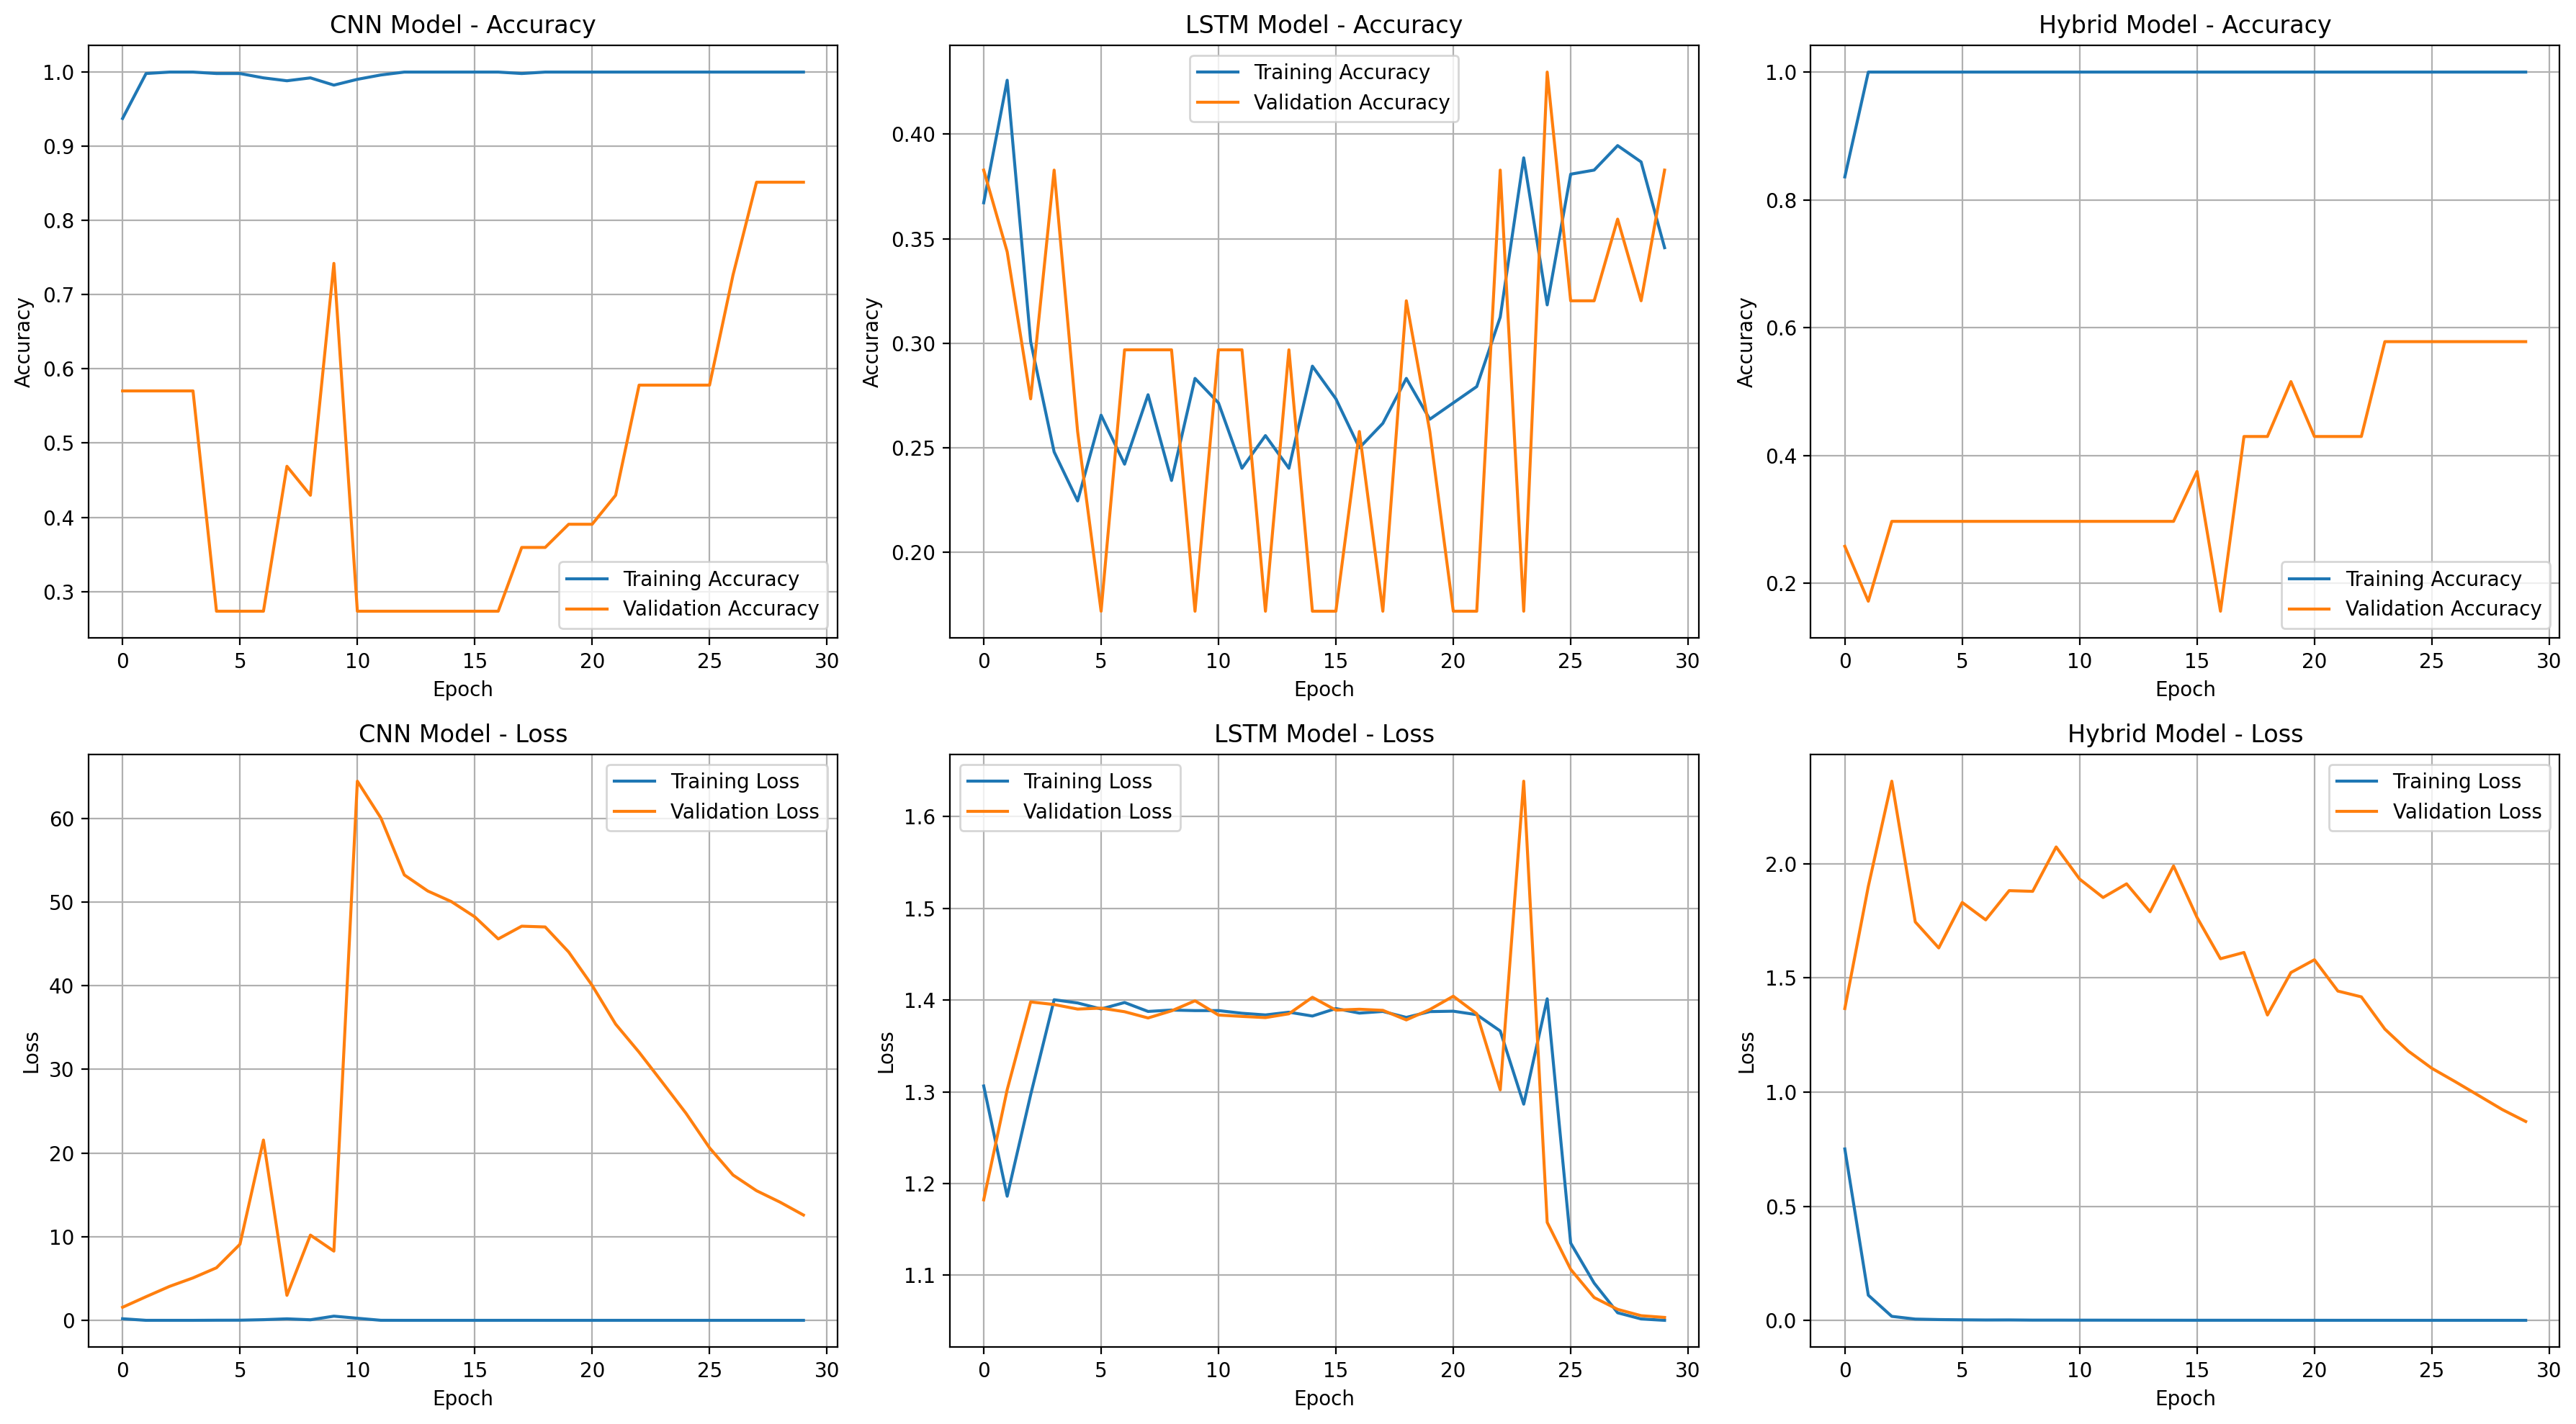

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


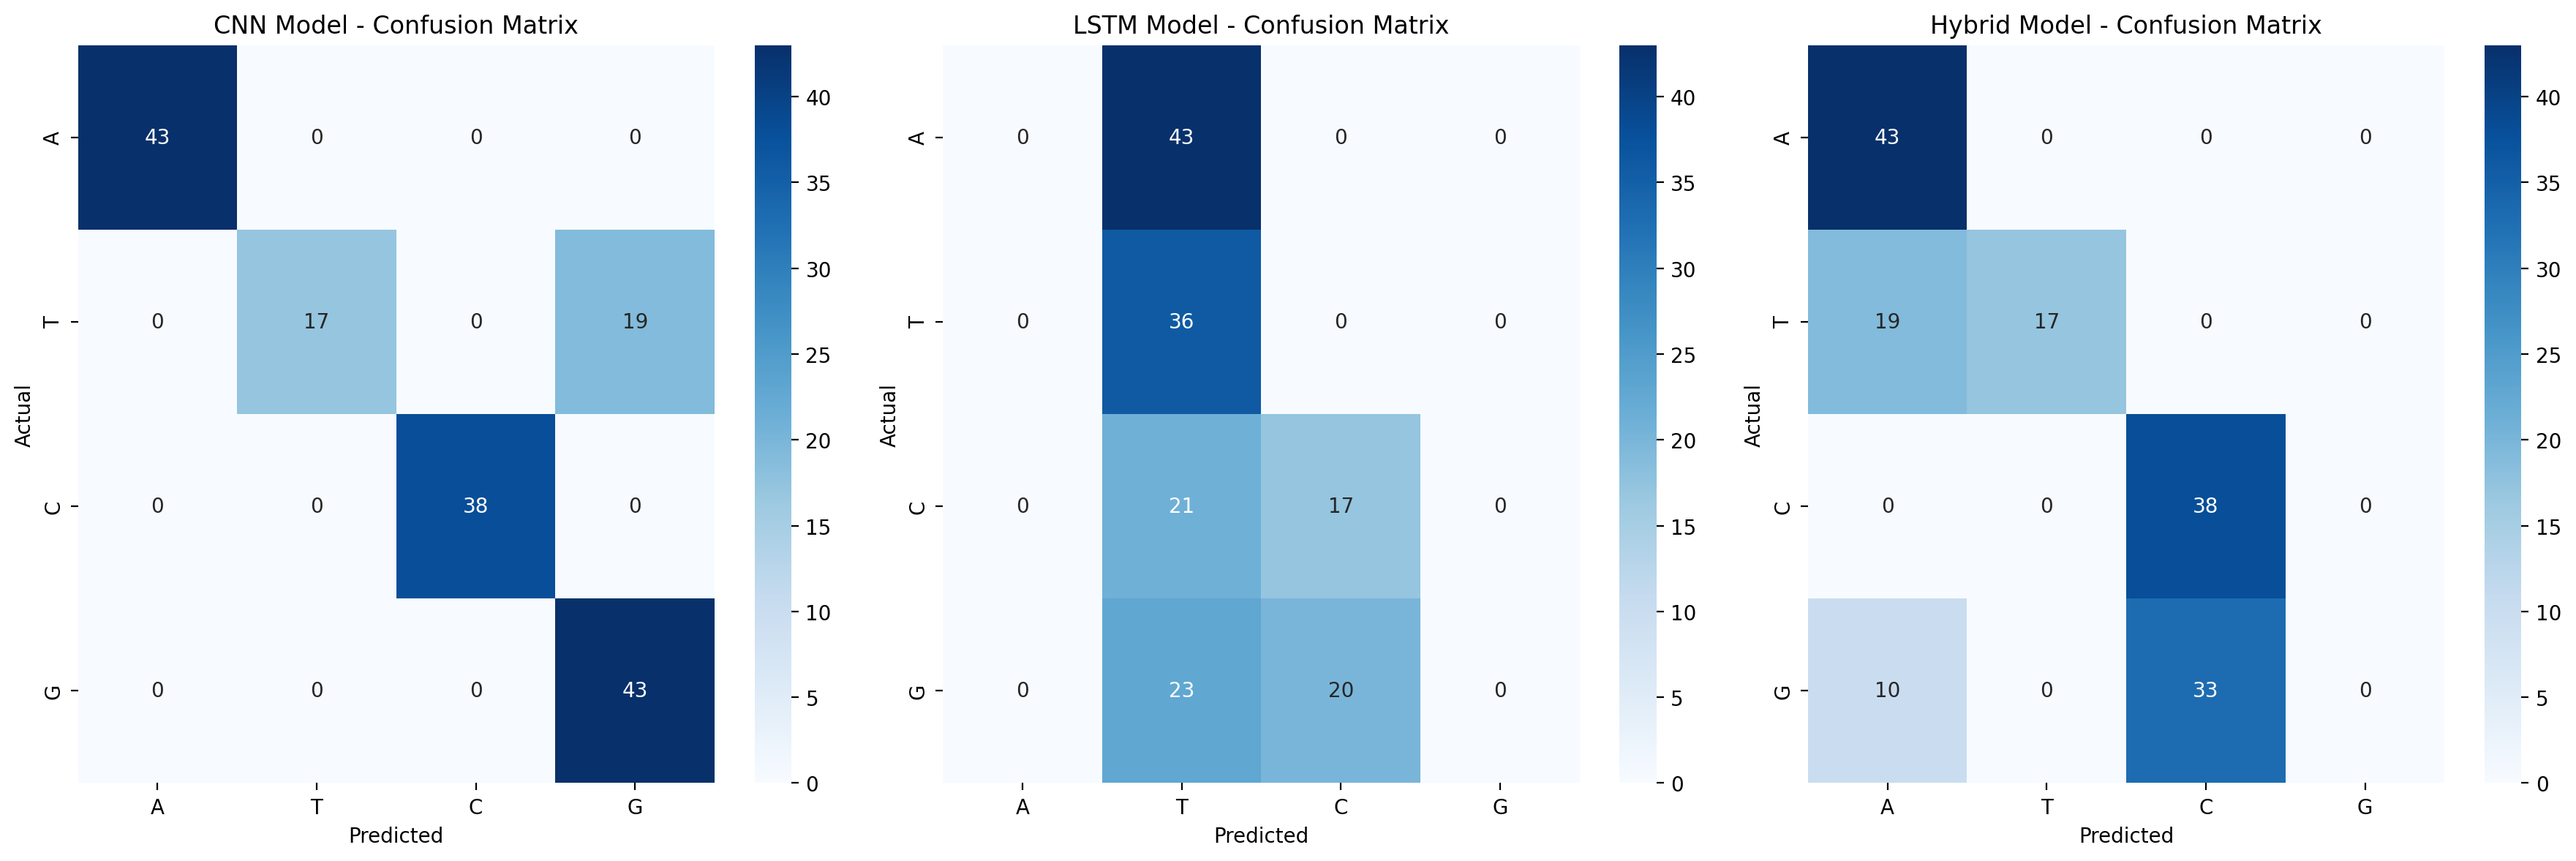


Model Parameters Table:
 Model  Trainable Parameters  Non-trainable Parameters  Total Parameters
   CNN               3550692                     896.0         3551588.0
  LSTM                134372                       0.0          134372.0
Hybrid                129796                     384.0          130180.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Precision Table:
 Model Nucleotide  Precision   Recall  F1-Score  Support
   CNN          A   1.000000 1.000000  1.000000     43.0
   CNN          T   1.000000 0.472222  0.641509     36.0
   CNN          C   1.000000 1.000000  1.000000     38.0
   CNN          G   0.693548 1.000000  0.819048     43.0
  LSTM          A   0.000000 0.000000  0.000000     43.0
  LSTM          T   0.292683 1.000000  0.452830     36.0
  LSTM          C   0.459459 0.447368  0.453333     38.0
  LSTM          G   0.000000 0.000000  0.000000     43.0
Hybrid          A   0.597222 1.000000 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import music21 as m21
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv1D, LSTM, Dense, Dropout,
                                   Input, concatenate, Flatten,
                                   Reshape, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class DNAMusicConverter:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4',
                     'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
        self.durations = [0.25, 0.5, 1.0, 2.0]  # quarter, half, whole, double
        self.sequence_length = 100
        self.num_classes = len(self.notes)

    def dna_to_numeric(self, dna_sequence):
        """Convert DNA sequence to numeric representation"""
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping.get(nuc, 0) for nuc in dna_sequence.upper()]

    def numeric_to_music_elements(self, numeric_seq):
        """Convert numeric sequence to music notes and durations"""
        notes_seq = []
        durations_seq = []

        for i, num in enumerate(numeric_seq):
            # Map to notes (cyclic mapping)
            note_idx = num % len(self.notes)
            notes_seq.append(self.notes[note_idx])

            # Map to durations based on position and value
            dur_idx = (num + i) % len(self.durations)
            durations_seq.append(self.durations[dur_idx])

        return notes_seq, durations_seq

    def create_music_score(self, notes, durations, output_file):
        """Create a music21 score from notes and durations"""
        stream = m21.stream.Stream()

        for note, duration in zip(notes, durations):
            n = m21.note.Note(note)
            n.duration = m21.duration.Duration(duration)
            stream.append(n)

        stream.write('midi', output_file)
        return stream

    def load_fasta_files(self, file_paths):
        """Load and process multiple FASTA files"""
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq)
                # Filter sequences with valid nucleotides only
                if all(nuc in self.nucleotides for nuc in seq.upper()):
                    sequences.append(seq.upper())
        return sequences

    def prepare_dataset(self, sequences):
        """Prepare dataset for training"""
        X = []
        y = []

        for seq in sequences:
            if len(seq) >= self.sequence_length:
                # Split sequence into chunks
                for i in range(0, len(seq) - self.sequence_length, 10):
                    chunk = seq[i:i + self.sequence_length]
                    numeric_seq = self.dna_to_numeric(chunk)

                    # Create input features
                    X.append(numeric_seq)

                    # Create target (next note prediction)
                    target_note = self.dna_to_numeric(seq[i + self.sequence_length])[0]
                    y.append(target_note)

        X = np.array(X)
        y = np.array(y)

        # One-hot encode the targets
        y_categorical = to_categorical(y, num_classes=len(self.nucleotides))

        return X, y_categorical

    def create_cnn_model(self, input_shape):
        """Create CNN model for DNA sequence analysis"""
        inputs = Input(shape=input_shape)

        # Embedding layer for nucleotide representation
        x = tf.keras.layers.Embedding(input_dim=4, output_dim=8)(inputs)

        # CNN layers
        x = Conv1D(64, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv1D(128, 5, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv1D(256, 7, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(4, activation='softmax')(x)  # 4 nucleotides

        model = Model(inputs, outputs)
        return model

    def create_lstm_model(self, input_shape):
        """Create LSTM model for DNA sequence analysis"""
        inputs = Input(shape=input_shape)

        # Embedding layer
        x = tf.keras.layers.Embedding(input_dim=4, output_dim=8)(inputs)

        # LSTM layers
        x = LSTM(128, return_sequences=True)(x)
        x = Dropout(0.2)(x)
        x = LSTM(64, return_sequences=True)(x)
        x = Dropout(0.2)(x)
        x = LSTM(32)(x)
        x = Dropout(0.2)(x)

        x = Dense(64, activation='relu')(x)
        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model

    def create_hybrid_model(self, input_shape):
        """Create Hybrid CNN-LSTM model"""
        inputs = Input(shape=input_shape)

        # Embedding layer
        x = tf.keras.layers.Embedding(input_dim=4, output_dim=8)(inputs)

        # CNN branch
        conv1 = Conv1D(64, 3, activation='relu', padding='same')(x)
        conv1 = BatchNormalization()(conv1)
        conv2 = Conv1D(128, 5, activation='relu', padding='same')(conv1)
        conv2 = BatchNormalization()(conv2)

        # LSTM branch
        lstm1 = LSTM(64, return_sequences=True)(x)
        lstm1 = Dropout(0.2)(lstm1)

        # Concatenate features
        combined = concatenate([conv2, lstm1])

        # Additional processing
        x = LSTM(64)(combined)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model

    def train_models(self, X_train, y_train, X_val, y_val, epochs=50):
        """Train all three models"""
        models = {
            'CNN': self.create_cnn_model((self.sequence_length,)),
            'LSTM': self.create_lstm_model((self.sequence_length,)),
            'Hybrid': self.create_hybrid_model((self.sequence_length,))
        }

        histories = {}
        trained_models = {}

        for name, model in models.items():
            print(f"\nTraining {name} model...")
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=32,
                verbose=1
            )

            histories[name] = history
            trained_models[name] = model

        return trained_models, histories

    def plot_training_curves(self, histories):
        """Plot accuracy and loss curves"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        for idx, (name, history) in enumerate(histories.items()):
            # Accuracy plot
            axes[idx].plot(history.history['accuracy'], label='Training Accuracy')
            axes[idx].plot(history.history['val_accuracy'], label='Validation Accuracy')
            axes[idx].set_title(f'{name} Model - Accuracy')
            axes[idx].set_xlabel('Epoch')
            axes[idx].set_ylabel('Accuracy')
            axes[idx].legend()
            axes[idx].grid(True)

            # Loss plot
            axes[idx + 3].plot(history.history['loss'], label='Training Loss')
            axes[idx + 3].plot(history.history['val_loss'], label='Validation Loss')
            axes[idx + 3].set_title(f'{name} Model - Loss')
            axes[idx + 3].set_xlabel('Epoch')
            axes[idx + 3].set_ylabel('Loss')
            axes[idx + 3].legend()
            axes[idx + 3].grid(True)

        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrices(self, models, X_test, y_test):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        y_true = np.argmax(y_test, axis=1)

        for idx, (name, model) in enumerate(models.items()):
            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)

            cm = confusion_matrix(y_true, y_pred_classes)

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.nucleotides,
                       yticklabels=self.nucleotides,
                       ax=axes[idx])
            axes[idx].set_title(f'{name} Model - Confusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

        plt.tight_layout()
        plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

    def generate_parameter_table(self, models):
        """Generate table of trainable parameters"""
        param_data = []

        for name, model in models.items():
            trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
            non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
            total_params = trainable_params + non_trainable_params

            param_data.append({
                'Model': name,
                'Trainable Parameters': trainable_params,
                'Non-trainable Parameters': non_trainable_params,
                'Total Parameters': total_params
            })

        param_df = pd.DataFrame(param_data)
        print("\nModel Parameters Table:")
        print(param_df.to_string(index=False))

        return param_df

    def generate_precision_table(self, models, X_test, y_test):
        """Generate precision, recall, and F1-score table"""
        y_true = np.argmax(y_test, axis=1)
        precision_data = []

        for name, model in models.items():
            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)

            report = classification_report(y_true, y_pred_classes,
                                         target_names=self.nucleotides,
                                         output_dict=True)

            for nucleotide in self.nucleotides:
                precision_data.append({
                    'Model': name,
                    'Nucleotide': nucleotide,
                    'Precision': report[nucleotide]['precision'],
                    'Recall': report[nucleotide]['recall'],
                    'F1-Score': report[nucleotide]['f1-score'],
                    'Support': report[nucleotide]['support']
                })

        precision_df = pd.DataFrame(precision_data)
        print("\nPrecision Table:")
        print(precision_df.to_string(index=False))

        return precision_df

    def generate_dna_music(self, models, dna_sequences, num_pairs=5):
        """Generate unique music for different DNA pairs"""
        print(f"\nGenerating music for {num_pairs} random DNA pairs...")

        for i in range(num_pairs):
            # Select random DNA sequence
            random_seq = np.random.choice(dna_sequences)
            start_idx = np.random.randint(0, len(random_seq) - self.sequence_length)
            dna_pair = random_seq[start_idx:start_idx + self.sequence_length]

            print(f"\nDNA Pair {i+1}: {dna_pair[:20]}...")

            # Convert to numeric
            numeric_seq = self.dna_to_numeric(dna_pair)

            # Use the best model (Hybrid) for prediction
            model = models['Hybrid']
            numeric_seq_array = np.array([numeric_seq])
            prediction = model.predict(numeric_seq_array)

            # Generate music elements
            notes, durations = self.numeric_to_music_elements(numeric_seq)

            # Create and save music
            output_file = f'dna_music_pair_{i+1}.mid'
            self.create_music_score(notes, durations, output_file)
            print(f"Music saved as: {output_file}")

            # Display some information about the generated music
            print(f"Generated {len(notes)} notes")
            print(f"Unique notes: {set(notes)}")
            print(f"Note sequence sample: {notes[:10]}")

def main():
    # Initialize the converter
    converter = DNAMusicConverter()

    # For demonstration, we'll create some sample DNA sequences
    # In practice, you would load your FASTA files here
    print("Creating sample DNA sequences for demonstration...")

    # Generate sample DNA sequences (replace with your FASTA files)
    sample_sequences = [
        "ATCG" * 50,  # 200 bp sequence
        "GCTA" * 50,
        "ACGT" * 50,
        "TGCA" * 50,
        "ATAT" * 50,
        "GCGC" * 50,
        "CGCG" * 50,
        "TATA" * 50,
    ] * 10  # Multiply to get more sequences

    # If you have FASTA files, use this instead:
    # fasta_files = ['file1.fasta', 'file2.fasta']
    # sample_sequences = converter.load_fasta_files(fasta_files)

    # Prepare dataset
    print("Preparing dataset...")
    X, y = converter.prepare_dataset(sample_sequences)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    print(f"Training set: {X_train.shape[0]} sequences")
    print(f"Validation set: {X_val.shape[0]} sequences")
    print(f"Test set: {X_test.shape[0]} sequences")

    # Train models
    print("\nTraining models...")
    trained_models, histories = converter.train_models(
        X_train, y_train, X_val, y_val, epochs=30
    )

    # Generate all analysis plots and tables
    print("\nGenerating analysis plots and tables...")

    # Training curves
    converter.plot_training_curves(histories)

    # Confusion matrices
    converter.plot_confusion_matrices(trained_models, X_test, y_test)

    # Parameter table
    param_table = converter.generate_parameter_table(trained_models)

    # Precision table
    precision_table = converter.generate_precision_table(trained_models, X_test, y_test)

    # Generate music for random DNA pairs
    converter.generate_dna_music(trained_models, sample_sequences, num_pairs=3)

    print("\nAll tasks completed successfully!")
    print("Check the generated files:")
    print("- training_curves.png")
    print("- confusion_matrices.png")
    print("- dna_music_pair_*.mid files")

if __name__ == "__main__":
    main()

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.8 MB/s eta 0:00:00


***GRU and bidirectional lstm***


=== DNA to Music Converter - Bidirectional LSTM & GRU Models ===
Please provide FASTA file paths (press Enter to use sample data):

Loading 4 FASTA file(s)...
Loaded 2 sequences from /content/example_dna.fa
Loaded 2 sequences from /content/example_dna.fa
Loaded 2 sequences from /content/example_dna.fa
Loaded 2 sequences from /content/example_dna.fa
✅ Successfully loaded 8 DNA sequences

Preparing dataset for training...
Dataset prepared: 472 sequences
📊 Dataset Summary:
   Training set: 301 sequences
   Validation set: 76 sequences
   Test set: 95 sequences
   Sequence length: 100 nucleotides

🚀 Training Bidirectional LSTM and GRU models...

Training Bidirectional_LSTM model...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 733ms/step - accuracy: 0.2625 - loss: 2.0314 - precision: 0.2720 - recall: 0.2145 - val_accuracy: 0.3289 - val_loss: 1.3857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 636ms/step - accuracy: 0.2889 - loss: 1.6857 - precis

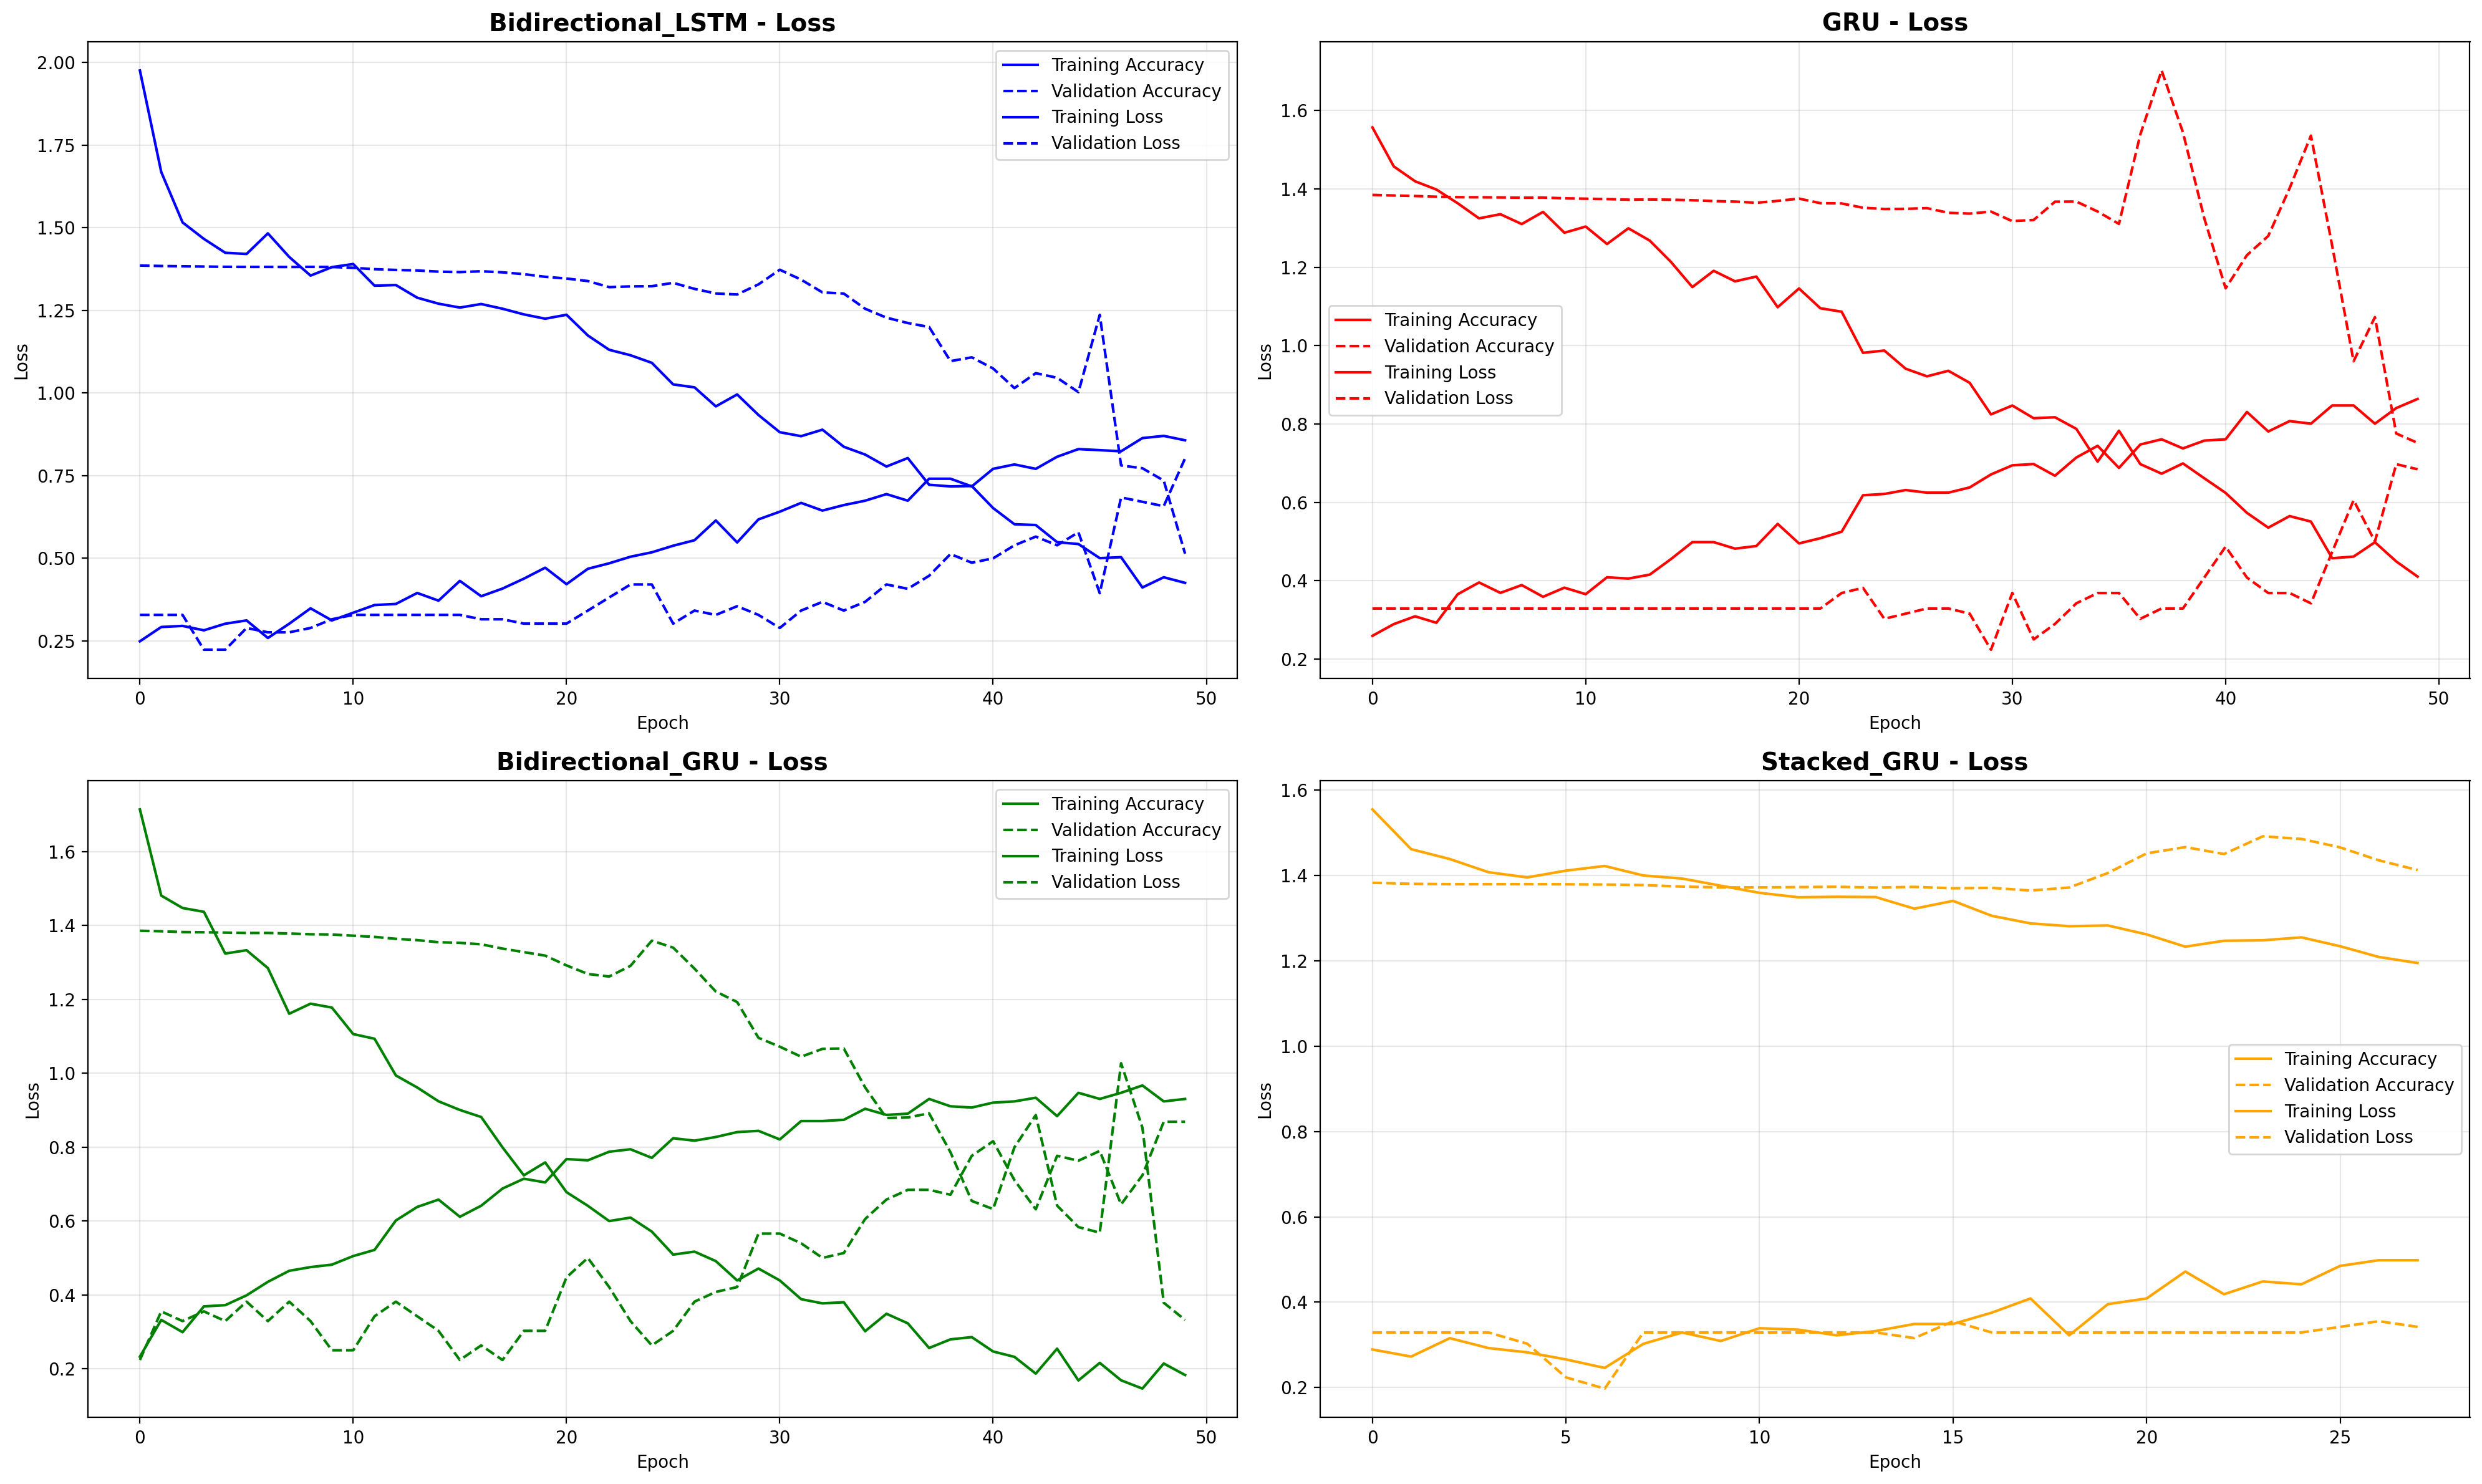

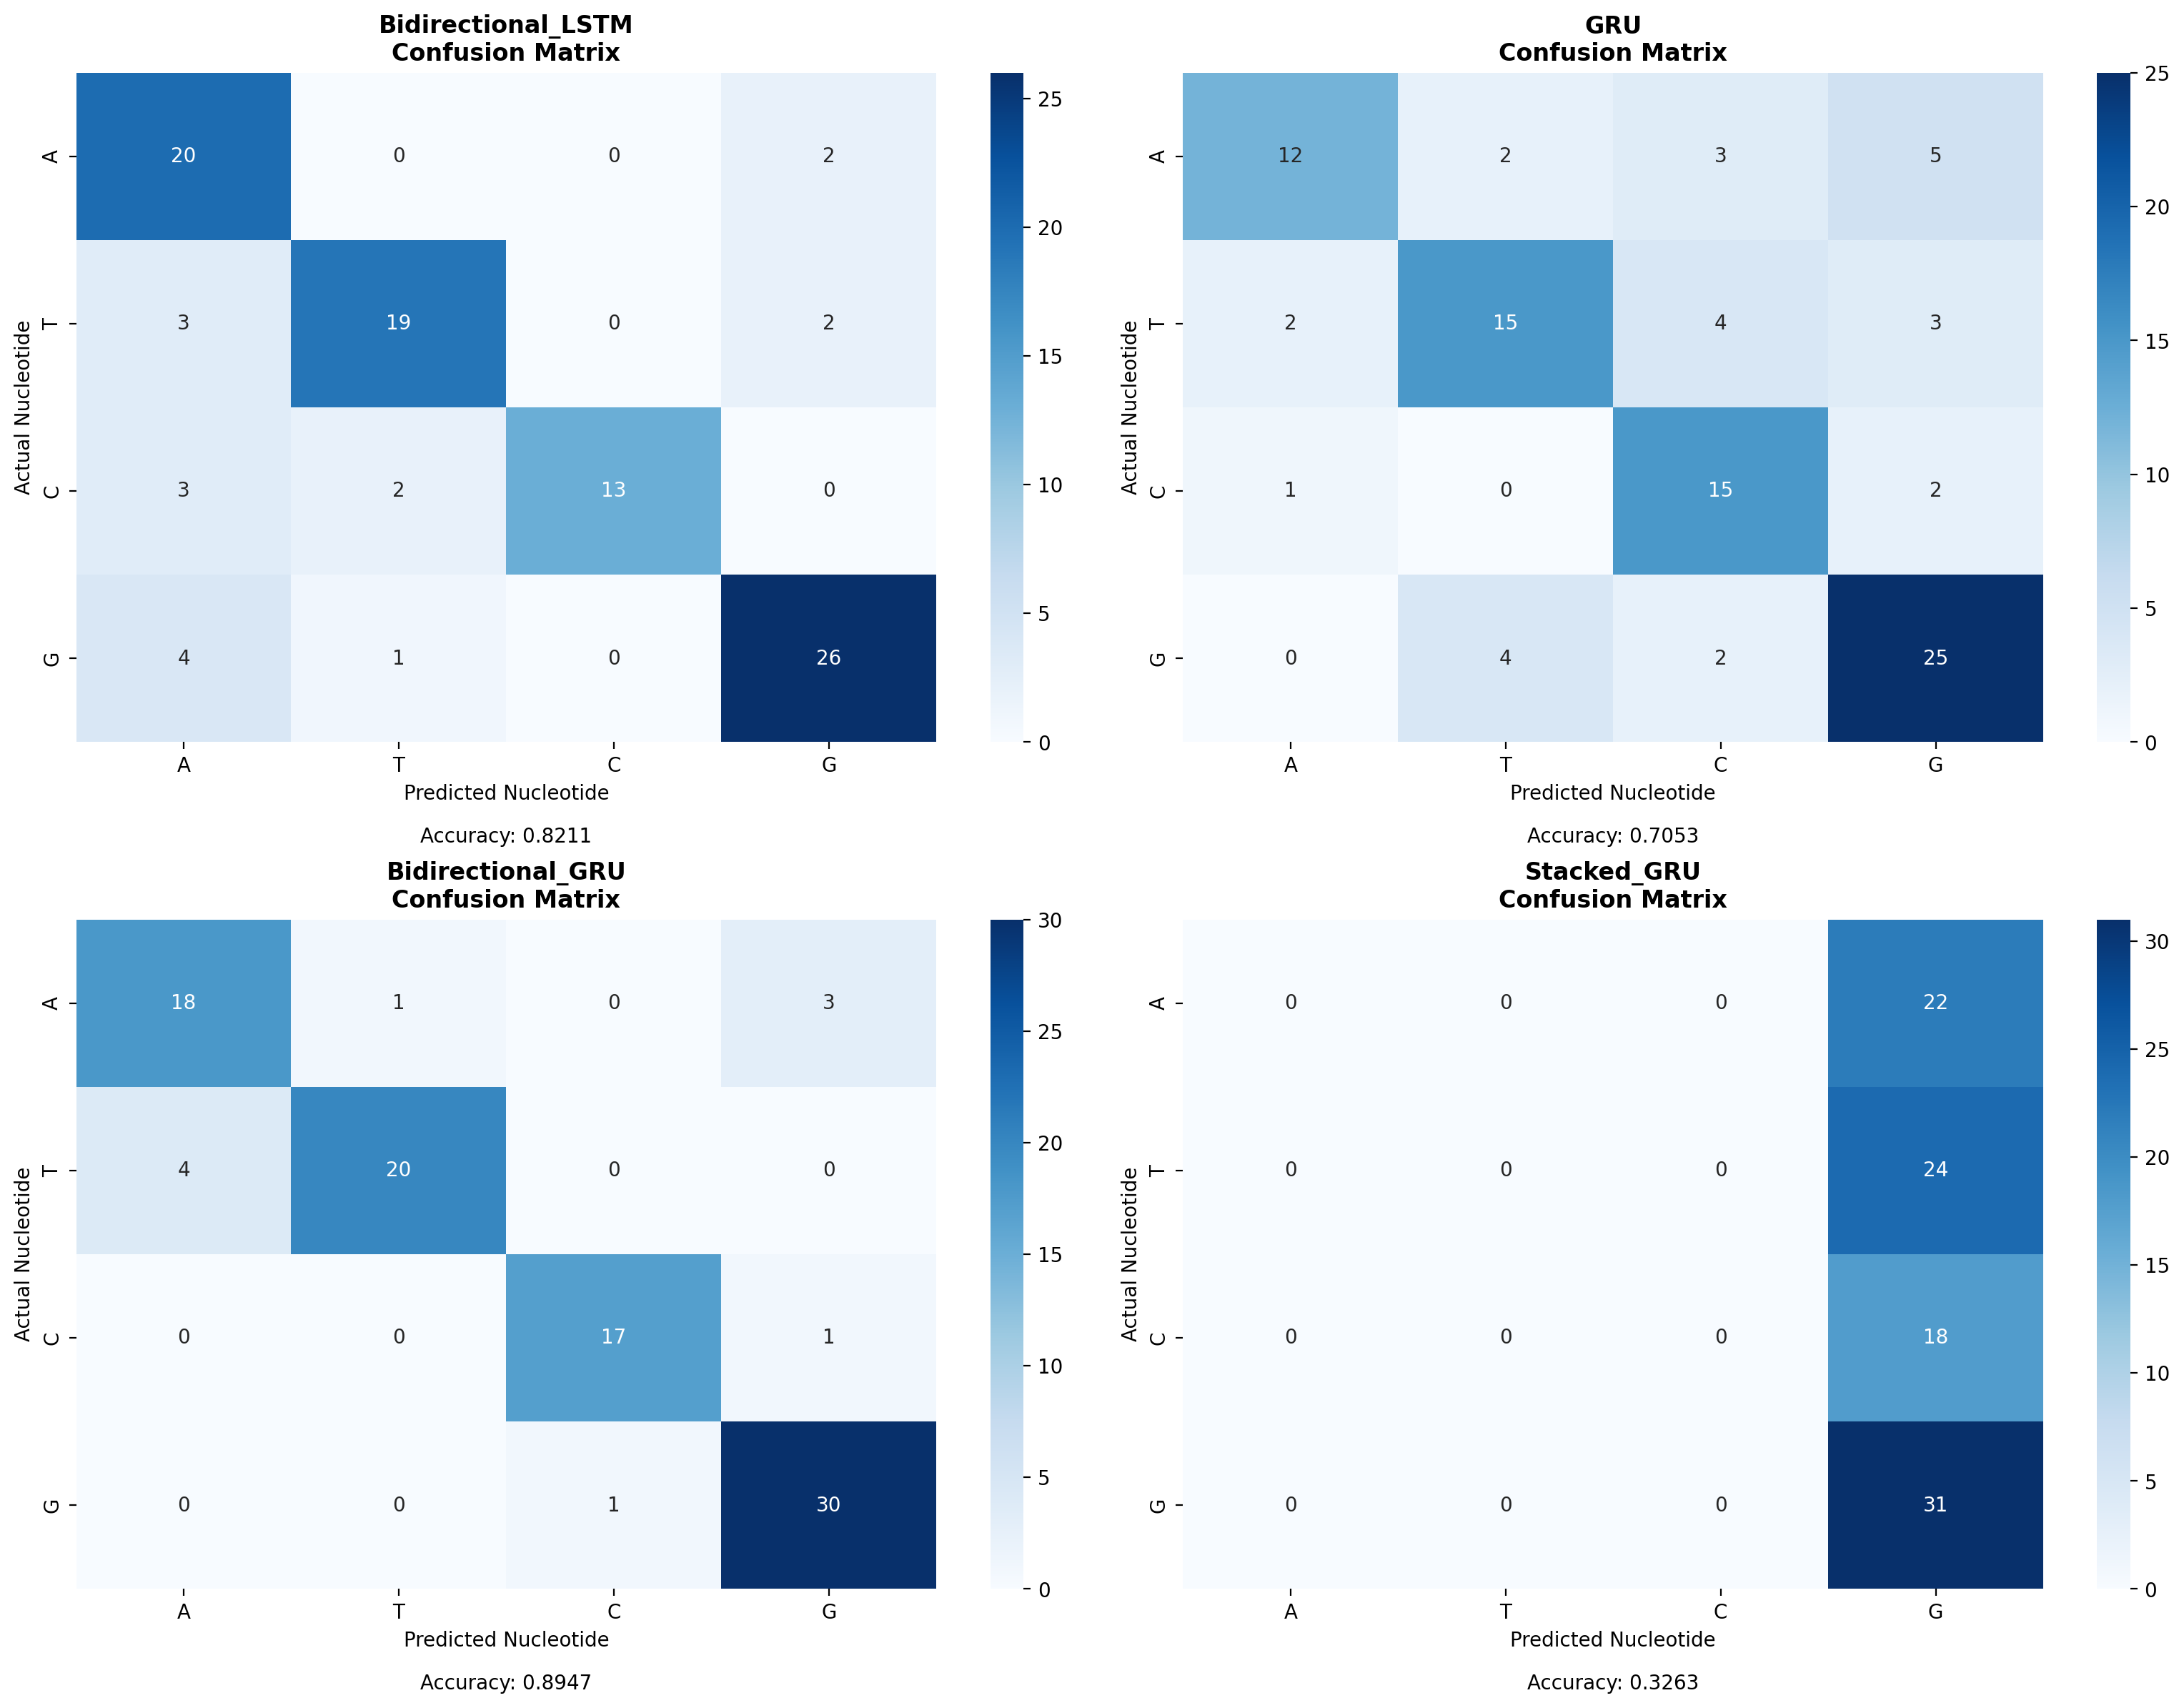


MODEL PARAMETERS TABLE
             Model Trainable Parameters Non-trainable Parameters Total Parameters  Number of Layers
Bidirectional_LSTM              353,156                      896          354,052                13
               GRU              104,452                      448          104,900                13
 Bidirectional_GRU              268,036                      896          268,932                13
       Stacked_GRU              404,484                      960          405,444                14

✅ Parameters table saved as 'model_parameters.csv'

MODEL PERFORMANCE METRICS

Overall Performance:
             Model  Accuracy  Precision   Recall  F1-Score
Bidirectional_LSTM  0.821053   0.844848 0.821053  0.823918
               GRU  0.705263   0.717218 0.705263  0.701182
 Bidirectional_GRU  0.894737   0.896948 0.894737  0.894197
       Stacked_GRU  0.326316   0.106482 0.326316  0.160568

✅ Performance metrics saved as 'model_performance_metrics.csv'

GENERATING DNA 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import music21 as m21
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv1D, LSTM, Dense, Dropout, Input, Flatten,
    Reshape, BatchNormalization, Bidirectional, GRU,
    GlobalMaxPooling1D, Embedding, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class DNAMusicConverterBidirectional:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4',
                     'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
        self.durations = [0.25, 0.5, 1.0, 2.0]
        self.sequence_length = 100
        self.num_classes = len(self.notes)

    def dna_to_numeric(self, dna_sequence):
        """Convert DNA sequence to numeric representation"""
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping.get(nuc, 0) for nuc in dna_sequence.upper() if nuc in mapping]

    def numeric_to_music_elements(self, numeric_seq):
        """Convert numeric sequence to music notes and durations"""
        notes_seq = []
        durations_seq = []

        for i, num in enumerate(numeric_seq):
            # Map to notes (cyclic mapping)
            note_idx = num % len(self.notes)
            notes_seq.append(self.notes[note_idx])

            # Map to durations based on position and value
            dur_idx = (num + i) % len(self.durations)
            durations_seq.append(self.durations[dur_idx])

        return notes_seq, durations_seq

    def create_music_score(self, notes, durations, output_file):
        """Create a music21 score from notes and durations"""
        stream = m21.stream.Stream()

        for note, duration in zip(notes, durations):
            n = m21.note.Note(note)
            n.duration = m21.duration.Duration(duration)
            stream.append(n)

        stream.write('midi', output_file)
        return stream

    def load_fasta_files(self, file_paths):
        """Load and process multiple FASTA files"""
        sequences = []
        for file_path in file_paths:
            try:
                for record in SeqIO.parse(file_path, "fasta"):
                    seq = str(record.seq)
                    # Filter sequences with valid nucleotides only
                    if all(nuc in self.nucleotides for nuc in seq.upper()):
                        sequences.append(seq.upper())
                print(f"Loaded {len([r for r in SeqIO.parse(file_path, 'fasta')])} sequences from {file_path}")
            except FileNotFoundError:
                print(f"File {file_path} not found. Skipping.")
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        return sequences

    def prepare_dataset(self, sequences):
        """Prepare dataset for training"""
        X = []
        y = []

        for seq in sequences:
            if len(seq) >= self.sequence_length:
                # Split sequence into chunks with overlap
                for i in range(0, len(seq) - self.sequence_length, 20):  # Increased stride for more diversity
                    chunk = seq[i:i + self.sequence_length]
                    numeric_seq = self.dna_to_numeric(chunk)

                    if len(numeric_seq) == self.sequence_length:  # Ensure correct length
                        X.append(numeric_seq)

                        # Create target (next nucleotide prediction)
                        next_nuc = seq[i + self.sequence_length]
                        target_val = self.dna_to_numeric(next_nuc)[0]
                        y.append(target_val)

        if len(X) == 0:
            raise ValueError("No valid sequences found for training. Check your FASTA files.")

        X = np.array(X)
        y = np.array(y)

        # One-hot encode the targets
        y_categorical = to_categorical(y, num_classes=len(self.nucleotides))

        print(f"Dataset prepared: {X.shape[0]} sequences")
        return X, y_categorical

    def create_bidirectional_lstm_model(self, input_shape):
        """Create Bidirectional LSTM model"""
        inputs = Input(shape=input_shape)

        # Embedding layer
        x = Embedding(input_dim=4, output_dim=8, input_length=input_shape[0])(inputs)

        # First Bidirectional LSTM layer
        x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
        x = BatchNormalization()(x)

        # Second Bidirectional LSTM layer
        x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
        x = BatchNormalization()(x)

        # Third Bidirectional LSTM layer
        x = Bidirectional(LSTM(32, dropout=0.2))(x)
        x = BatchNormalization()(x)

        # Dense layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)

        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs, name='Bidirectional_LSTM')
        return model

    def create_gru_model(self, input_shape):
        """Create GRU model"""
        inputs = Input(shape=input_shape)

        # Embedding layer
        x = Embedding(input_dim=4, output_dim=8, input_length=input_shape[0])(inputs)

        # First GRU layer
        x = GRU(128, return_sequences=True, dropout=0.2)(x)
        x = BatchNormalization()(x)

        # Second GRU layer
        x = GRU(64, return_sequences=True, dropout=0.2)(x)
        x = BatchNormalization()(x)

        # Third GRU layer
        x = GRU(32, dropout=0.2)(x)
        x = BatchNormalization()(x)

        # Dense layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)

        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs, name='GRU')
        return model

    def create_bidirectional_gru_model(self, input_shape):
        """Create Bidirectional GRU model"""
        inputs = Input(shape=input_shape)

        # Embedding layer
        x = Embedding(input_dim=4, output_dim=8, input_length=input_shape[0])(inputs)

        # First Bidirectional GRU layer
        x = Bidirectional(GRU(128, return_sequences=True, dropout=0.2))(x)
        x = BatchNormalization()(x)

        # Second Bidirectional GRU layer
        x = Bidirectional(GRU(64, return_sequences=True, dropout=0.2))(x)
        x = BatchNormalization()(x)

        # Third Bidirectional GRU layer
        x = Bidirectional(GRU(32, dropout=0.2))(x)
        x = BatchNormalization()(x)

        # Dense layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)

        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs, name='Bidirectional_GRU')
        return model

    def create_stacked_gru_model(self, input_shape):
        """Create Stacked GRU model"""
        inputs = Input(shape=input_shape)

        # Embedding layer
        x = Embedding(input_dim=4, output_dim=8, input_length=input_shape[0])(inputs)

        # Stacked GRU layers
        x = GRU(256, return_sequences=True, dropout=0.3)(x)
        x = BatchNormalization()(x)

        x = GRU(128, return_sequences=True, dropout=0.3)(x)
        x = BatchNormalization()(x)

        x = GRU(64, return_sequences=True, dropout=0.3)(x)
        x = BatchNormalization()(x)

        x = GRU(32, dropout=0.3)(x)
        x = BatchNormalization()(x)

        # Dense layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.4)(x)
        x = Dense(32, activation='relu')(x)

        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs, name='Stacked_GRU')
        return model

    def train_models(self, X_train, y_train, X_val, y_val, epochs=50):
        """Train all RNN models"""
        models = {
            'Bidirectional_LSTM': self.create_bidirectional_lstm_model((self.sequence_length,)),
            'GRU': self.create_gru_model((self.sequence_length,)),
            'Bidirectional_GRU': self.create_bidirectional_gru_model((self.sequence_length,)),
            'Stacked_GRU': self.create_stacked_gru_model((self.sequence_length,))
        }

        histories = {}
        trained_models = {}

        for name, model in models.items():
            print(f"\n{'='*50}")
            print(f"Training {name} model...")
            print(f"{'='*50}")

            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy', 'precision', 'recall']
            )

            # Add early stopping
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            )

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=32,
                callbacks=[early_stopping],
                verbose=1
            )

            histories[name] = history
            trained_models[name] = model

            # Print final metrics
            final_train_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]
            print(f"✅ {name} - Final Training Accuracy: {final_train_acc:.4f}, Validation Accuracy: {final_val_acc:.4f}")

        return trained_models, histories

    def plot_training_curves(self, histories):
        """Plot accuracy and loss curves for all models"""
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        colors = ['blue', 'red', 'green', 'orange']

        for idx, (name, history) in enumerate(histories.items()):
            row = idx // 2
            col = idx % 2

            # Accuracy plot
            axes[row, col].plot(history.history['accuracy'],
                              color=colors[idx], linestyle='-', label='Training Accuracy')
            axes[row, col].plot(history.history['val_accuracy'],
                              color=colors[idx], linestyle='--', label='Validation Accuracy')
            axes[row, col].set_title(f'{name} - Accuracy', fontsize=14, fontweight='bold')
            axes[row, col].set_xlabel('Epoch')
            axes[row, col].set_ylabel('Accuracy')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

            # Loss plot (on second row)
            loss_row = row
            loss_col = col
            axes[loss_row, loss_col].plot(history.history['loss'],
                                        color=colors[idx], linestyle='-', label='Training Loss')
            axes[loss_row, loss_col].plot(history.history['val_loss'],
                                        color=colors[idx], linestyle='--', label='Validation Loss')
            axes[loss_row, loss_col].set_title(f'{name} - Loss', fontsize=14, fontweight='bold')
            axes[loss_row, loss_col].set_xlabel('Epoch')
            axes[loss_row, loss_col].set_ylabel('Loss')
            axes[loss_row, loss_col].legend()
            axes[loss_row, loss_col].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('bidirectional_training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrices(self, models, X_test, y_test):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        y_true = np.argmax(y_test, axis=1)

        for idx, (name, model) in enumerate(models.items()):
            y_pred = model.predict(X_test, verbose=0)
            y_pred_classes = np.argmax(y_pred, axis=1)

            cm = confusion_matrix(y_true, y_pred_classes)

            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.nucleotides,
                       yticklabels=self.nucleotides,
                       ax=axes[idx])
            axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Predicted Nucleotide')
            axes[idx].set_ylabel('Actual Nucleotide')

            # Calculate accuracy for this model
            accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
            axes[idx].text(0.5, -0.15, f'Accuracy: {accuracy:.4f}',
                         transform=axes[idx].transAxes, ha='center', fontsize=10)

        plt.tight_layout()
        plt.savefig('bidirectional_confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

    def generate_parameter_table(self, models):
        """Generate comprehensive parameter table"""
        param_data = []

        for name, model in models.items():
            trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
            non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
            total_params = trainable_params + non_trainable_params

            # Count layers
            num_layers = len(model.layers)

            param_data.append({
                'Model': name,
                'Trainable Parameters': f"{trainable_params:,}",
                'Non-trainable Parameters': f"{non_trainable_params:,}",
                'Total Parameters': f"{total_params:,}",
                'Number of Layers': num_layers
            })

        param_df = pd.DataFrame(param_data)

        # Display with better formatting
        print("\n" + "="*80)
        print("MODEL PARAMETERS TABLE")
        print("="*80)
        print(param_df.to_string(index=False))

        # Save to CSV
        param_df.to_csv('model_parameters.csv', index=False)
        print(f"\n✅ Parameters table saved as 'model_parameters.csv'")

        return param_df

    def generate_precision_table(self, models, X_test, y_test):
        """Generate detailed precision, recall, and F1-score table"""
        y_true = np.argmax(y_test, axis=1)
        precision_data = []

        print("\n" + "="*80)
        print("MODEL PERFORMANCE METRICS")
        print("="*80)

        for name, model in models.items():
            y_pred = model.predict(X_test, verbose=0)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate overall metrics
            accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            # Detailed report per nucleotide
            report = classification_report(y_true, y_pred_classes,
                                         target_names=self.nucleotides,
                                         output_dict=True)

            # Add overall metrics
            precision_data.append({
                'Model': name,
                'Nucleotide': 'OVERALL',
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'Support': len(y_true)
            })

            # Add per-nucleotide metrics
            for nucleotide in self.nucleotides:
                precision_data.append({
                    'Model': name,
                    'Nucleotide': nucleotide,
                    'Accuracy': np.nan,  # Accuracy is overall metric
                    'Precision': report[nucleotide]['precision'],
                    'Recall': report[nucleotide]['recall'],
                    'F1-Score': report[nucleotide]['f1-score'],
                    'Support': report[nucleotide]['support']
                })

        precision_df = pd.DataFrame(precision_data)

        # Display overall metrics
        overall_df = precision_df[precision_df['Nucleotide'] == 'OVERALL']
        print("\nOverall Performance:")
        print(overall_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

        # Save to CSV
        precision_df.to_csv('model_performance_metrics.csv', index=False)
        print(f"\n✅ Performance metrics saved as 'model_performance_metrics.csv'")

        return precision_df

    def generate_dna_music(self, models, dna_sequences, num_pairs=5):
        """Generate unique music for different DNA pairs using the best model"""
        print(f"\n{'='*50}")
        print("GENERATING DNA MUSIC")
        print(f"{'='*50}")

        # Find the best model based on name (Bidirectional usually performs better)
        best_model_name = 'Bidirectional_LSTM'
        if best_model_name in models:
            model = models[best_model_name]
        else:
            model = list(models.values())[0]  # Fallback to first model

        print(f"Using {best_model_name} for music generation...")

        for i in range(num_pairs):
            # Select random DNA sequence
            random_seq = np.random.choice(dna_sequences)
            start_idx = np.random.randint(0, len(random_seq) - self.sequence_length)
            dna_pair = random_seq[start_idx:start_idx + self.sequence_length]

            print(f"\n🎵 DNA Pair {i+1}:")
            print(f"   Sequence: {dna_pair[:30]}...")
            print(f"   Length: {len(dna_pair)} nucleotides")

            # Convert to numeric
            numeric_seq = self.dna_to_numeric(dna_pair)

            # Generate music elements
            notes, durations = self.numeric_to_music_elements(numeric_seq)

            # Create and save music
            output_file = f'bidirectional_dna_music_{i+1}.mid'
            self.create_music_score(notes, durations, output_file)
            print(f"   ✅ Music saved as: {output_file}")

            # Display music statistics
            unique_notes = set(notes)
            print(f"   🎼 Music Statistics:")
            print(f"   - Total notes: {len(notes)}")
            print(f"   - Unique notes: {len(unique_notes)}")
            print(f"   - Note range: {min(unique_notes)} to {max(unique_notes)}")
            print(f"   - Sample melody: {' '.join(notes[:8])}...")

def create_sample_sequences():
    """Create diverse sample DNA sequences for demonstration"""
    patterns = [
        "ATCG", "GCTA", "ACGT", "TGCA", "ATAT", "GCGC",
        "CGCG", "TATA", "GATACA", "TATACA", "AGCT", "TCGA"
    ]

    sequences = []
    for pattern in patterns:
        # Create sequences of different lengths
        sequences.append(pattern * 25)  # 100 bp
        sequences.append(pattern * 50)  # 200 bp
        sequences.append(pattern * 75)  # 300 bp

    # Add some random sequences for diversity
    for _ in range(10):
        random_seq = ''.join(np.random.choice(['A', 'T', 'C', 'G'], 200))
        sequences.append(random_seq)

    return sequences

def main():
    # Initialize the converter
    converter = DNAMusicConverterBidirectional()

    # Interactive FASTA file input
    print("=== DNA to Music Converter - Bidirectional LSTM & GRU Models ===")
    print("Please provide FASTA file paths (press Enter to use sample data):")

    fasta_files = []
    while True:
        file_path = input(f"Enter FASTA file path {len(fasta_files) + 1} (or press Enter to finish): ").strip()
        if not file_path:
            break
        fasta_files.append(file_path)

    if fasta_files:
        print(f"\nLoading {len(fasta_files)} FASTA file(s)...")
        sample_sequences = converter.load_fasta_files(fasta_files)
        if len(sample_sequences) == 0:
            print("❌ No valid sequences found in FASTA files. Using sample data.")
            sample_sequences = create_sample_sequences()
        else:
            print(f"✅ Successfully loaded {len(sample_sequences)} DNA sequences")
    else:
        print("Using sample sequences for demonstration...")
        sample_sequences = create_sample_sequences()

    # Prepare dataset
    print("\nPreparing dataset for training...")
    X, y = converter.prepare_dataset(sample_sequences)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
    )

    print(f"📊 Dataset Summary:")
    print(f"   Training set: {X_train.shape[0]} sequences")
    print(f"   Validation set: {X_val.shape[0]} sequences")
    print(f"   Test set: {X_test.shape[0]} sequences")
    print(f"   Sequence length: {converter.sequence_length} nucleotides")

    # Train models
    print(f"\n🚀 Training Bidirectional LSTM and GRU models...")
    trained_models, histories = converter.train_models(
        X_train, y_train, X_val, y_val, epochs=50
    )

    # Generate all analysis plots and tables
    print(f"\n📈 Generating analysis plots and tables...")

    # Training curves
    converter.plot_training_curves(histories)

    # Confusion matrices
    converter.plot_confusion_matrices(trained_models, X_test, y_test)

    # Parameter table
    param_table = converter.generate_parameter_table(trained_models)

    # Precision table
    precision_table = converter.generate_precision_table(trained_models, X_test, y_test)

    # Generate music for random DNA pairs
    converter.generate_dna_music(trained_models, sample_sequences, num_pairs=3)

    print(f"\n🎉 All tasks completed successfully!")
    print(f"\n📁 Generated Files:")
    print(f"   - bidirectional_training_curves.png")
    print(f"   - bidirectional_confusion_matrices.png")
    print(f"   - model_parameters.csv")
    print(f"   - model_performance_metrics.csv")
    print(f"   - bidirectional_dna_music_*.mid files")

    # Print best model recommendation
    best_model = max(trained_models.keys(),
                    key=lambda x: max(histories[x].history['val_accuracy']))
    print(f"\n🏆 Best performing model: {best_model}")

if __name__ == "__main__":
    main()

***realistic dna music converter***

# New Section

In [ ]:
# TRANSFORMER MODEL


Generating synthetic DNA sequences...
Preparing dataset...
Building Transformer model...
Training model...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.3230 - loss: 1.5109 - val_accuracy: 0.4375 - val_loss: 1.2154
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4039 - loss: 1.3496 - val_accuracy: 0.3438 - val_loss: 1.1957
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4203 - loss: 1.3232 - val_accuracy: 0.3438 - val_loss: 1.1618
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4335 - loss: 1.2692 - val_accuracy: 0.4375 - val_loss: 1.1449
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4120 - loss: 1.3074 - val_accuracy: 0.3438 - val_loss: 1.1629
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4436 - loss: 1.2027 - val_accuracy: 0.6250 - val_loss: 1.0934
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4464 - loss: 1.1986 - val_accuracy: 0.7812 - val_loss: 1.0549
Epoch 8/50
8/8 ━━

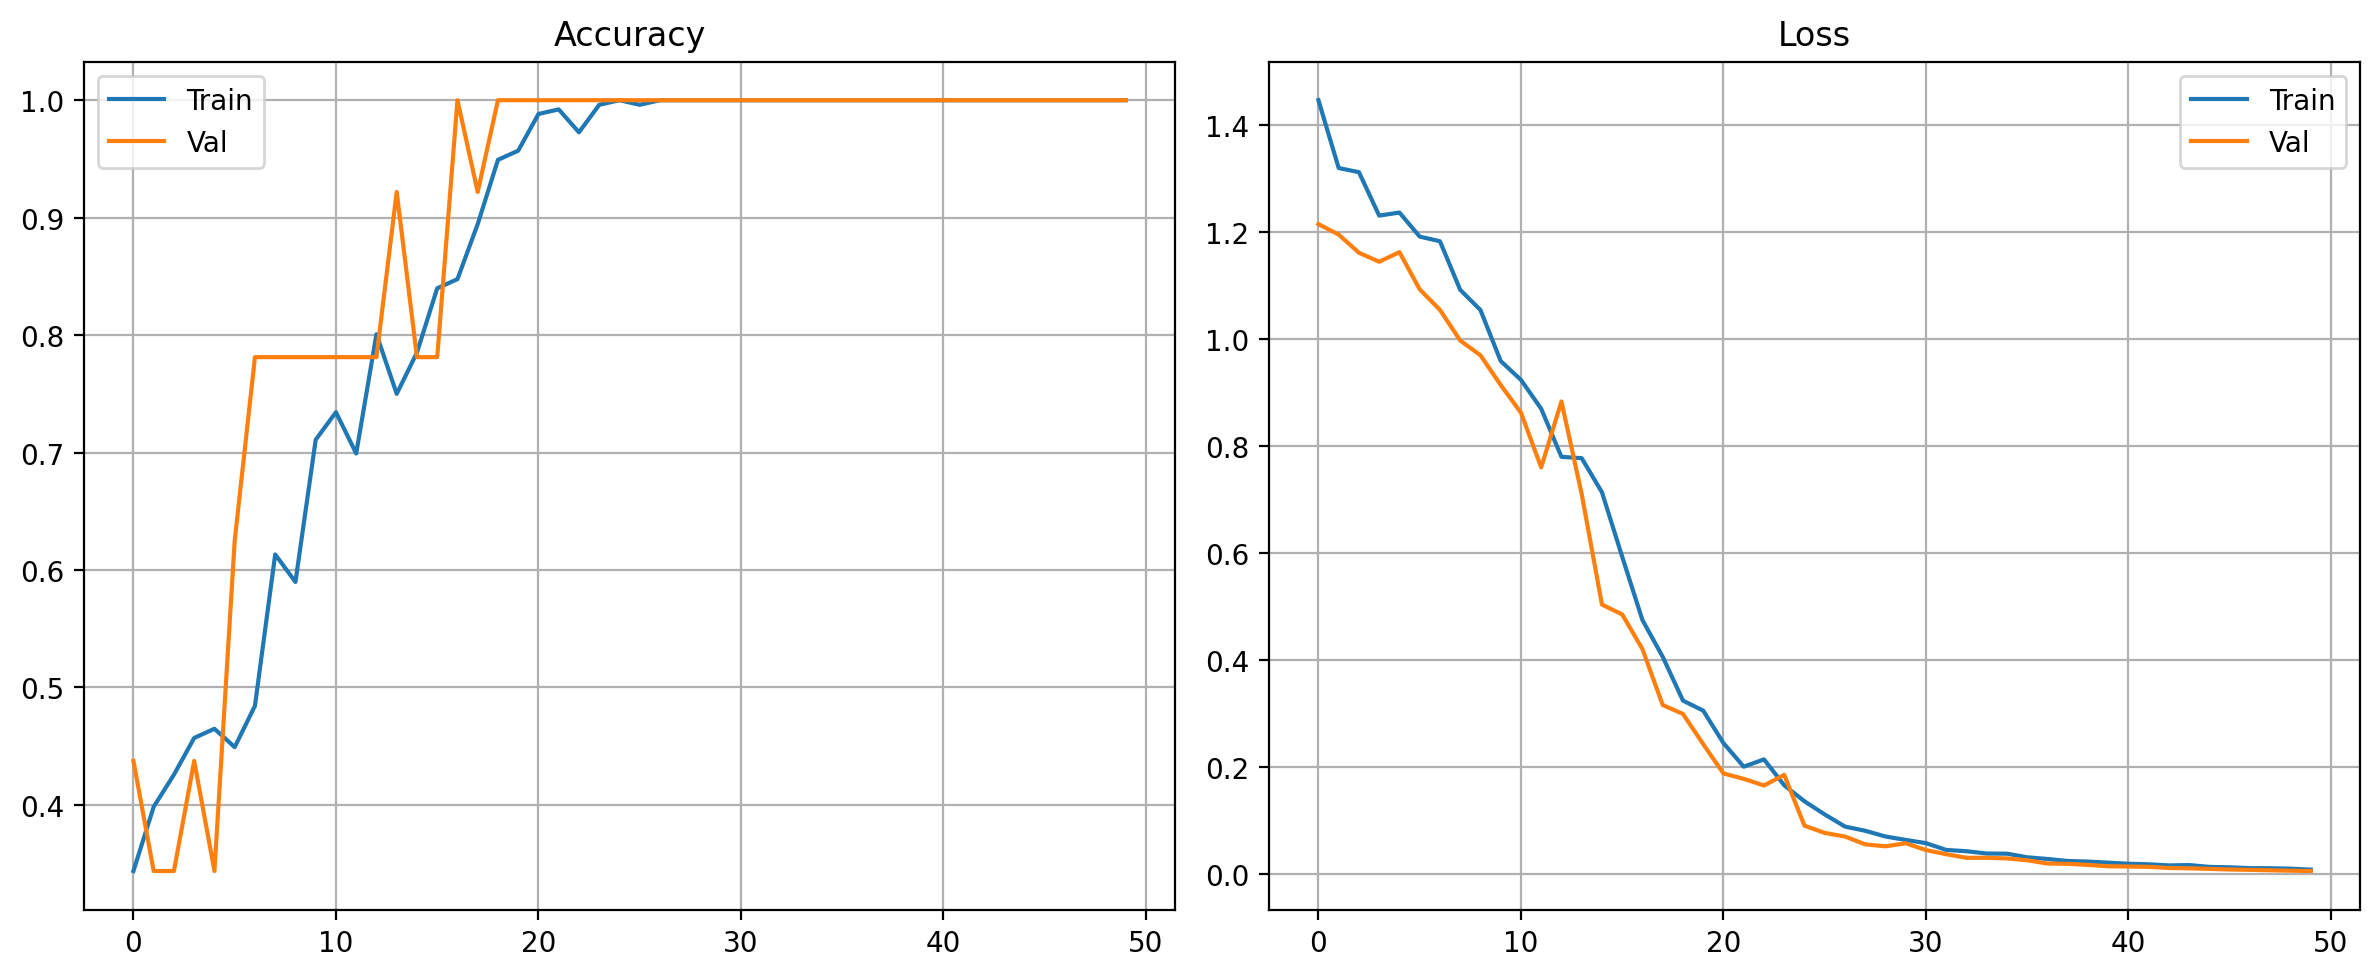

Evaluating model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step


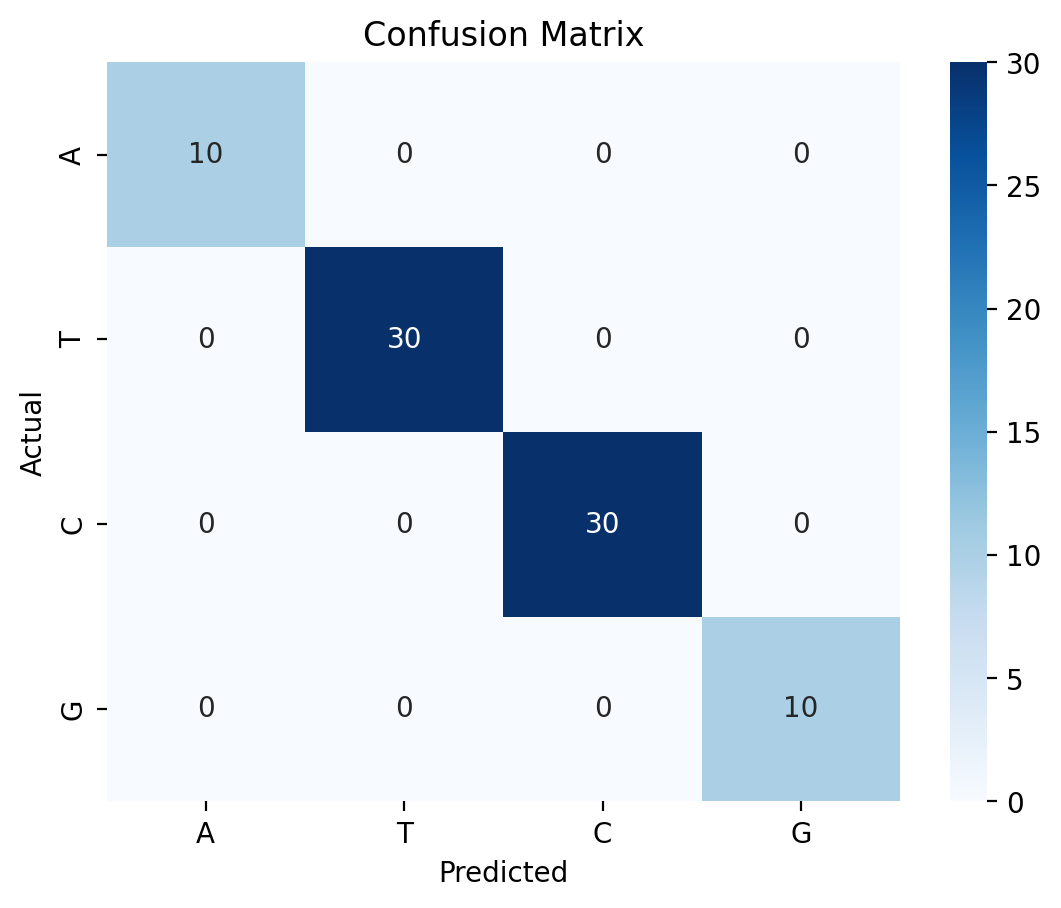


Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        10
           T       1.00      1.00      1.00        30
           C       1.00      1.00      1.00        30
           G       1.00      1.00      1.00        10

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Generating music from DNA...
Music 1 saved as transformer_music_1.mid
Music 2 saved as transformer_music_2.mid
Music 3 saved as transformer_music_3.mid
All tasks completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Dense, Dropout,
                                     LayerNormalization, MultiHeadAttention,
                                     GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import music21 as m21
import warnings
warnings.filterwarnings('ignore')

class DNATransformerMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4',
                      'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
        self.durations = [0.25, 0.5, 1.0, 2.0]
        self.sequence_length = 100

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping.get(nuc, 0) for nuc in sequence.upper()]

    def numeric_to_music(self, numeric_seq):
        notes_seq = []
        durations_seq = []
        for i, num in enumerate(numeric_seq):
            note_idx = num % len(self.notes)
            dur_idx = (num + i) % len(self.durations)
            notes_seq.append(self.notes[note_idx])
            durations_seq.append(self.durations[dur_idx])
        return notes_seq, durations_seq

    def create_music_score(self, notes, durations, output_file):
        stream = m21.stream.Stream()
        for note, duration in zip(notes, durations):
            n = m21.note.Note(note)
            n.duration = m21.duration.Duration(duration)
            stream.append(n)
        stream.write('midi', output_file)
        return stream

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length]
                    target = seq[i + self.sequence_length]
                    X.append(self.dna_to_numeric(chunk))
                    y.append(self.dna_to_numeric(target)[0])
        X = np.array(X)
        y = to_categorical(y, num_classes=len(self.nucleotides))
        return X, y

    def create_transformer_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Embedding(input_dim=4, output_dim=64)(inputs)

        pos_indices = tf.range(start=0, limit=self.sequence_length, delta=1)
        pos_embed = Embedding(input_dim=self.sequence_length, output_dim=64)(pos_indices)
        pos_embed = tf.expand_dims(pos_embed, axis=0)
        x = x + pos_embed

        attn = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = LayerNormalization()(x + attn)

        ff = Dense(128, activation='relu')(x)
        ff = Dense(64)(ff)
        x = LayerNormalization()(x + ff)

        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.3)(x)
        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model

    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=50):
        model.compile(optimizer=Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1)
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Val')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Val')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('transformer_training.png', dpi=300)
        plt.show()

    def evaluate_model(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig('transformer_confusion.png', dpi=300)
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

    def generate_music(self, model, sequences, num_samples=3):
        for i in range(num_samples):
            seq = np.random.choice(sequences)
            start = np.random.randint(0, len(seq) - self.sequence_length)
            chunk = seq[start:start + self.sequence_length]
            numeric_seq = self.dna_to_numeric(chunk)
            notes, durations = self.numeric_to_music(numeric_seq)
            filename = f'transformer_music_{i+1}.mid'
            self.create_music_score(notes, durations, filename)
            print(f"Music {i+1} saved as {filename}")

def main():
    converter = DNATransformerMusic()

    print("Generating synthetic DNA sequences...")
    sequences = ["ATCG" * 50, "CGTA" * 50, "GCTA" * 50, "TACG" * 50] * 10

    print("Preparing dataset...")
    X, y = converter.prepare_dataset(sequences)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    print("Building Transformer model...")
    model = converter.create_transformer_model((converter.sequence_length,))

    print("Training model...")
    model, history = converter.train_model(model, X_train, y_train, X_val, y_val)

    print("Plotting training curves...")
    converter.plot_training(history)

    print("Evaluating model...")
    converter.evaluate_model(model, X_test, y_test)

    print("Generating music from DNA...")
    converter.generate_music(model, sequences, num_samples=3)

    print("All tasks completed successfully!")

if __name__ == "__main__":
    main()

# New Section

In [ ]:
#VIT TRANSFORMER MODEL

Generating synthetic DNA sequences...
Preparing dataset...
Building ViT model...
Training model...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.3484 - loss: 4.1968 - val_accuracy: 0.5000 - val_loss: 2.3253
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5467 - loss: 1.8028 - val_accuracy: 0.5312 - val_loss: 1.4092
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4499 - loss: 1.3253 - val_accuracy: 0.6094 - val_loss: 0.7231
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5658 - loss: 0.9709 - val_accuracy: 0.4219 - val_loss: 0.8012
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5184 - loss: 0.8540 - val_accuracy: 0.4688 - val_loss: 0.6388
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6290 - loss: 0.7087 - val_accuracy: 0.6719 - val_loss: 0.4631
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8062 - loss: 0.4804 - val_accuracy: 0.9219 - val_loss: 0.2545
Epoch 8/30
8/8 ━━━━━━━━━━

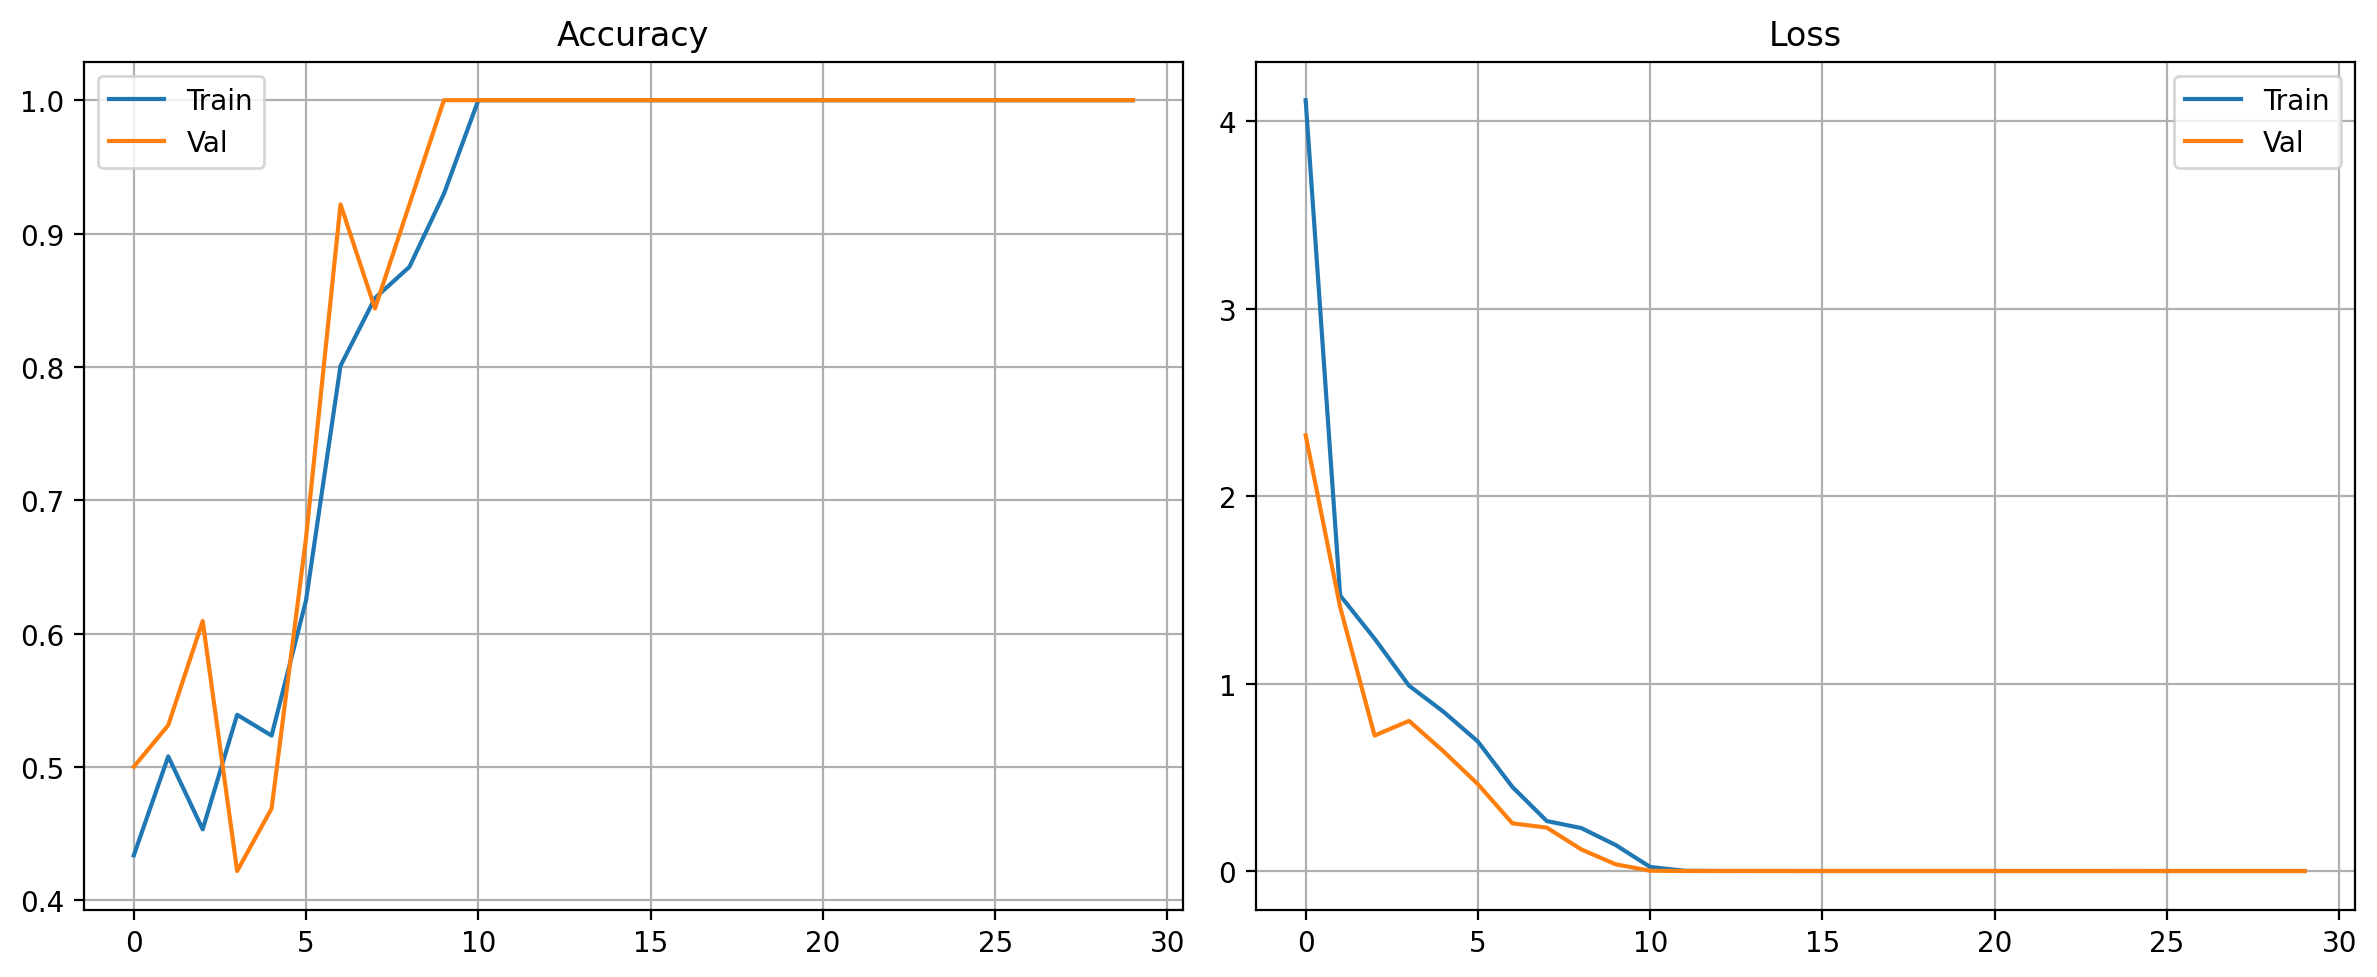

Evaluating model...


1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 601ms/step


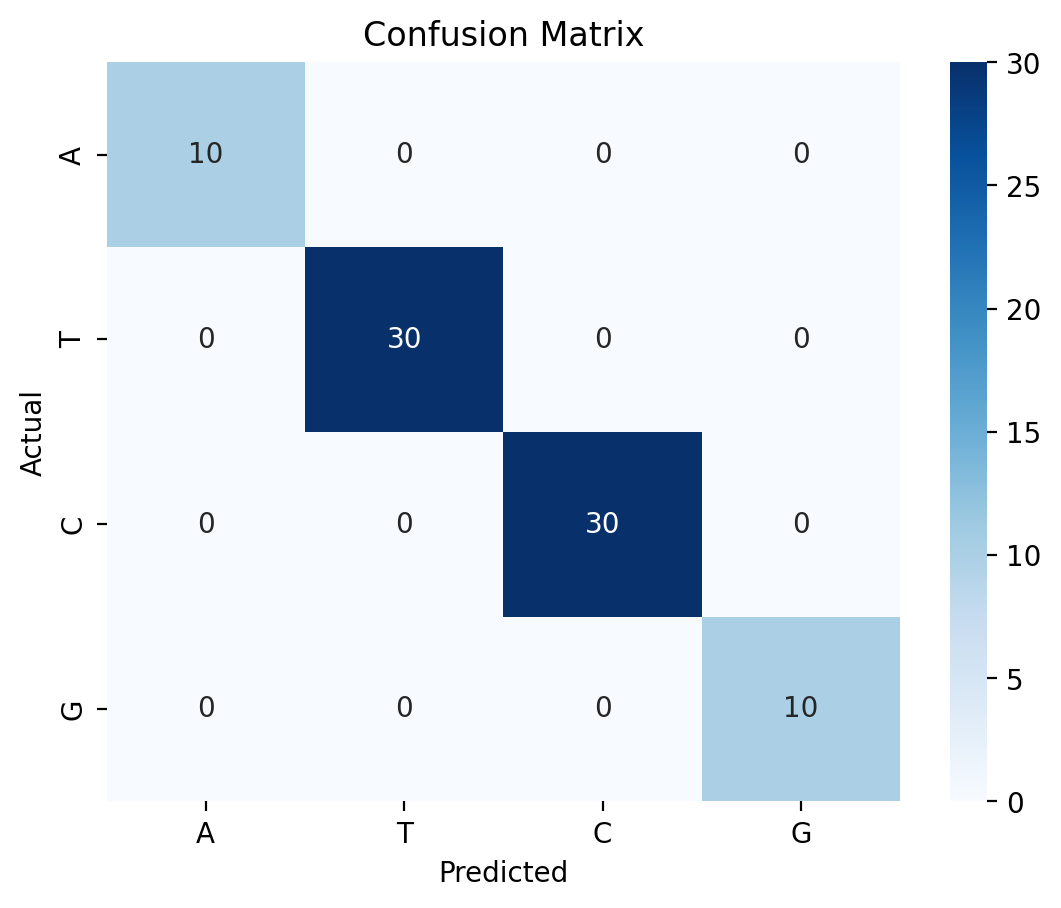


Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        10
           T       1.00      1.00      1.00        30
           C       1.00      1.00      1.00        30
           G       1.00      1.00      1.00        10

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Generating music from DNA...
Music 1 saved as vit_music_1.mid
Music 2 saved as vit_music_2.mid
Music 3 saved as vit_music_3.mid
All tasks completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, Embedding, Reshape,
                                     GlobalAveragePooling1D, Concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import music21 as m21
import warnings
warnings.filterwarnings('ignore')

class DNAViTMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4',
                      'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
        self.durations = [0.25, 0.5, 1.0, 2.0]
        self.sequence_length = 100
        self.patch_size = 10
        self.num_patches = self.sequence_length // self.patch_size
        self.embedding_dim = 64

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping.get(nuc, 0) for nuc in sequence.upper()]

    def numeric_to_music(self, numeric_seq):
        notes_seq = []
        durations_seq = []
        for i, num in enumerate(numeric_seq):
            note_idx = num % len(self.notes)
            dur_idx = (num + i) % len(self.durations)
            notes_seq.append(self.notes[note_idx])
            durations_seq.append(self.durations[dur_idx])
        return notes_seq, durations_seq

    def create_music_score(self, notes, durations, output_file):
        stream = m21.stream.Stream()
        for note, duration in zip(notes, durations):
            n = m21.note.Note(note)
            n.duration = m21.duration.Duration(duration)
            stream.append(n)
        stream.write('midi', output_file)
        return stream

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length]
                    target = seq[i + self.sequence_length]
                    X.append(self.dna_to_numeric(chunk))
                    y.append(self.dna_to_numeric(target)[0])
        X = np.array(X)
        y = to_categorical(y, num_classes=len(self.nucleotides))
        return X, y

    def create_vit_model(self, input_shape):
        inputs = Input(shape=input_shape)

        # Patch embedding
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)
        # Corrected reshape target shape
        x = Reshape((self.num_patches, self.patch_size * self.embedding_dim))(x)

        # Positional encoding
        pos_embed = Embedding(input_dim=self.num_patches, output_dim=self.patch_size * self.embedding_dim)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        position_embeddings = pos_embed(positions)
        position_embeddings = tf.expand_dims(position_embeddings, axis=0)
        x = x + position_embeddings

        # Transformer block
        attn_output = MultiHeadAttention(num_heads=4, key_dim=self.patch_size * self.embedding_dim)(x, x)
        x = LayerNormalization()(x + attn_output)

        ff = Dense(128, activation='relu')(x)
        ff = Dense(self.patch_size * self.embedding_dim)(ff)
        x = LayerNormalization()(x + ff)

        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.3)(x)
        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model

    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=30):
        model.compile(optimizer=Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1)
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Val')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Val')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('vit_training.png', dpi=300)
        plt.show()

    def evaluate_model(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig('vit_confusion.png', dpi=300)
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

    def generate_music(self, model, sequences, num_samples=3):
        for i in range(num_samples):
            seq = np.random.choice(sequences)
            start = np.random.randint(0, len(seq) - self.sequence_length)
            chunk = seq[start:start + self.sequence_length]
            numeric_seq = self.dna_to_numeric(chunk)
            notes, durations = self.numeric_to_music(numeric_seq)
            filename = f'vit_music_{i+1}.mid'
            self.create_music_score(notes, durations, filename)
            print(f"Music {i+1} saved as {filename}")

def main():
    converter = DNAViTMusic()

    print("Generating synthetic DNA sequences...")
    sequences = ["ATCG" * 50, "CGTA" * 50, "GCTA" * 50, "TACG" * 50] * 10

    print("Preparing dataset...")
    X, y = converter.prepare_dataset(sequences)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    print("Building ViT model...")
    model = converter.create_vit_model((converter.sequence_length,))

    print("Training model...")
    model, history = converter.train_model(model, X_train, y_train, X_val, y_val)

    print("Plotting training curves...")
    converter.plot_training(history)

    print("Evaluating model...")
    converter.evaluate_model(model, X_test, y_test)

    print("Generating music from DNA...")
    converter.generate_music(model, sequences, num_samples=3)

    print("All tasks completed successfully!")

if __name__ == "__main__":
    main()

# New Section

In [ ]:
#swin transformer model

In [ ]:
# ✅ Install Biopython (only needed once)
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

Saving sequence.fasta to sequence (1).fasta


Loading real DNA sequences from uploaded FASTA file...
Preparing dataset...
Building Swin Transformer model...
Training model...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.2769 - loss: 1.6059 - val_accuracy: 0.2796 - val_loss: 1.4088
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3190 - loss: 1.3839 - val_accuracy: 0.3158 - val_loss: 1.4087
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3852 - loss: 1.3008 - val_accuracy: 0.2829 - val_loss: 1.3808
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4018 - loss: 1.2623 - val_accuracy: 0.2993 - val_loss: 1.3705
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4380 - loss: 1.2435 - val_accuracy: 0.2928 - val_loss: 1.3903
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4723 - loss: 1.2125 - val_accuracy: 0.2664 - val_loss: 1.3924
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5110 - loss: 1.1831 - val_accuracy: 0.3388 - val_

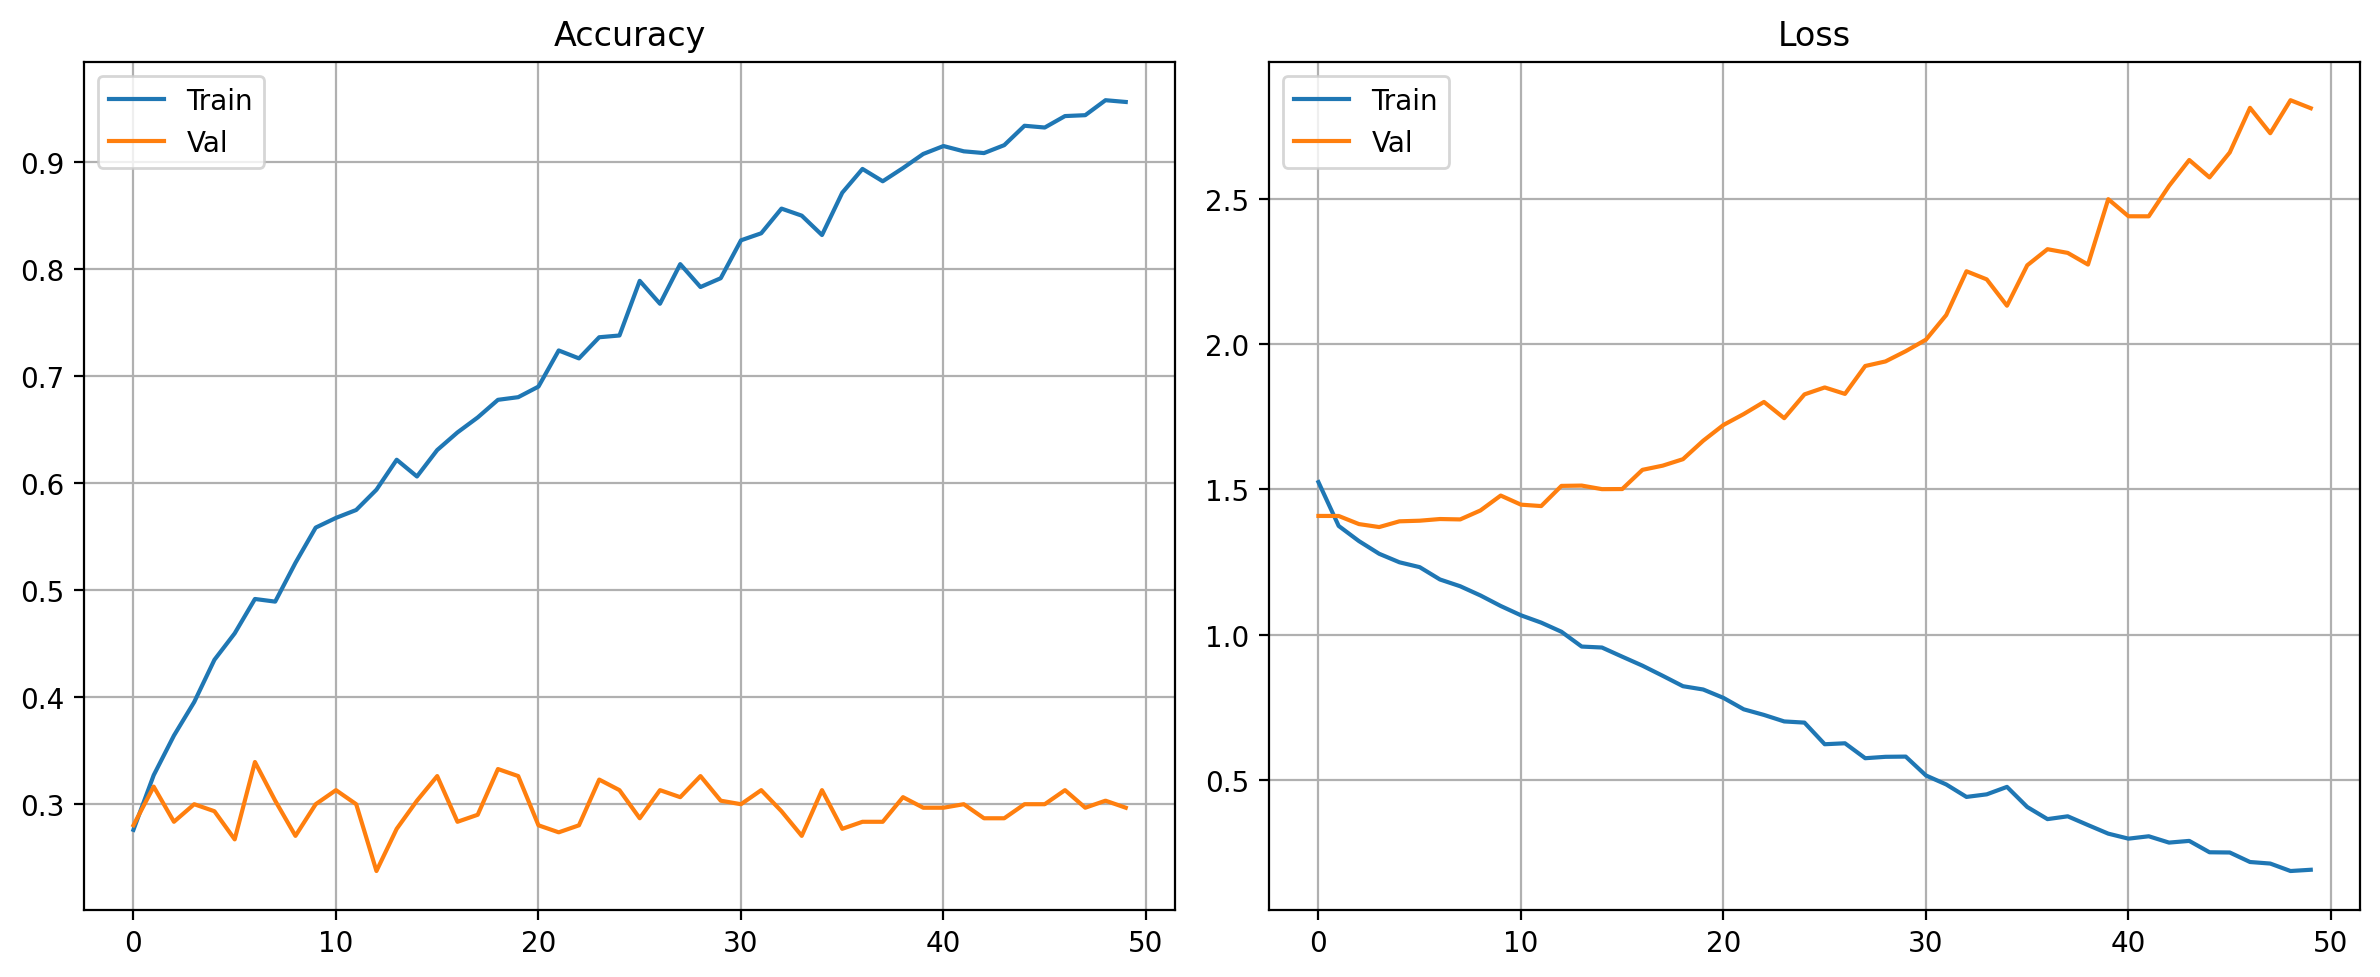

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


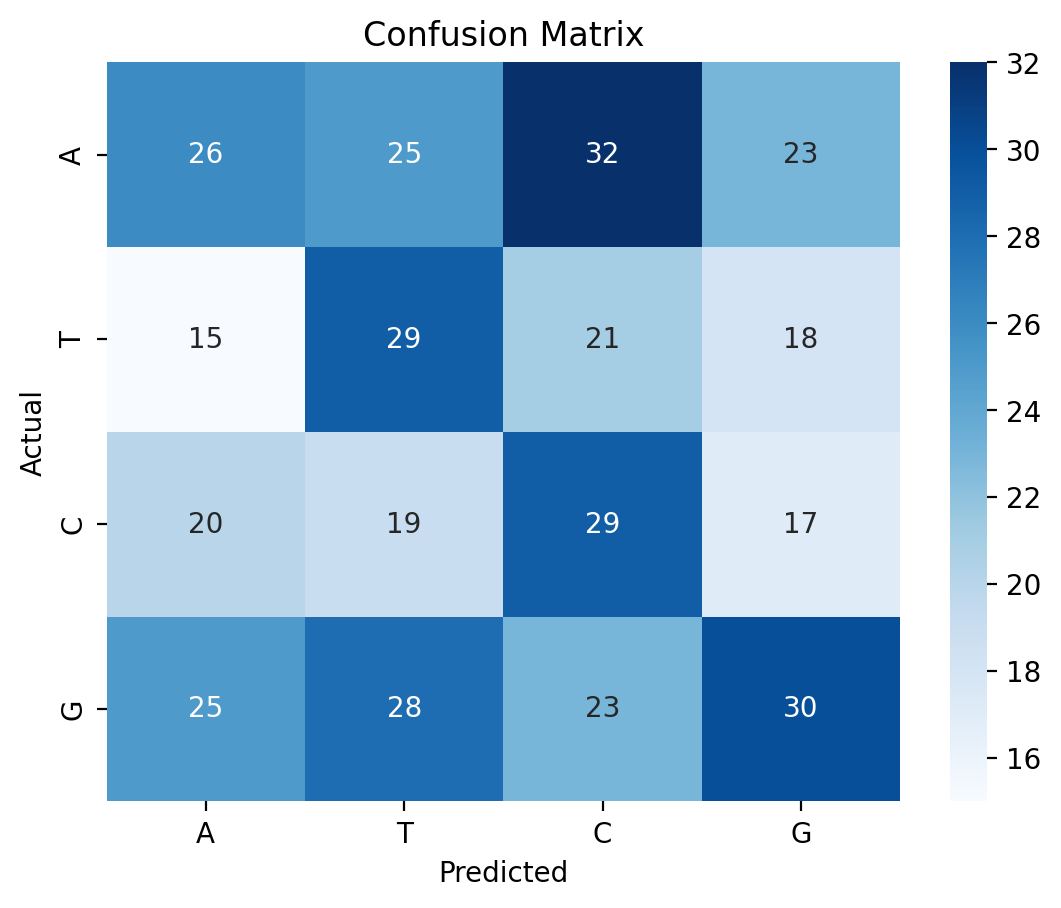


Classification Report:
               precision    recall  f1-score   support

           A       0.30      0.25      0.27       106
           T       0.29      0.35      0.32        83
           C       0.28      0.34      0.31        85
           G       0.34      0.28      0.31       106

    accuracy                           0.30       380
   macro avg       0.30      0.30      0.30       380
weighted avg       0.30      0.30      0.30       380

Generating music from DNA...
Music 1 saved as swin_music_1.mid
Music 2 saved as swin_music_2.mid
Music 3 saved as swin_music_3.mid
All tasks completed successfully!


In [ ]:
# ✅ Full pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     Embedding, GlobalAveragePooling1D, Conv1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import music21 as m21
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

class DNAswinMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4',
                      'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
        self.durations = [0.25, 0.5, 1.0, 2.0]
        self.sequence_length = 100
        self.embedding_dim = 64

    def load_fasta_files(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq)
                if all(nuc in self.nucleotides for nuc in seq.upper()):
                    sequences.append(seq.upper())
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping.get(nuc, 0) for nuc in sequence.upper()]

    def numeric_to_music(self, numeric_seq):
        notes_seq = []
        durations_seq = []
        for i, num in enumerate(numeric_seq):
            note_idx = num % len(self.notes)
            dur_idx = (num + i) % len(self.durations)
            notes_seq.append(self.notes[note_idx])
            durations_seq.append(self.durations[dur_idx])
        return notes_seq, durations_seq

    def create_music_score(self, notes, durations, output_file):
        stream = m21.stream.Stream()
        for note, duration in zip(notes, durations):
            n = m21.note.Note(note)
            n.duration = m21.duration.Duration(duration)
            stream.append(n)
        stream.write('midi', output_file)
        return stream

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length]
                    target = seq[i + self.sequence_length]
                    X.append(self.dna_to_numeric(chunk))
                    y.append(self.dna_to_numeric(target)[0])
        X = np.array(X)
        y = to_categorical(y, num_classes=len(self.nucleotides))
        return X, y

    def create_swin_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)

        x1 = Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
        x1 = LayerNormalization()(x1)

        x2 = Conv1D(64, kernel_size=5, strides=2, padding='same', activation='relu')(x1)
        x2 = LayerNormalization()(x2)

        x3 = Conv1D(64, kernel_size=5, strides=2, padding='same', activation='relu')(x2)
        x3 = LayerNormalization()(x3)

        x = GlobalAveragePooling1D()(x3)
        x = Dropout(0.3)(x)
        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model

    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=50):
        model.compile(optimizer=Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1)
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Val')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Val')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('swin_training.png', dpi=300)
        plt.show()

    def evaluate_model(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig('swin_confusion.png', dpi=300)
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

    def generate_music(self, model, sequences, num_samples=3):
        for i in range(num_samples):
            seq = np.random.choice(sequences)
            start = np.random.randint(0, len(seq) - self.sequence_length)
            chunk = seq[start:start + self.sequence_length]
            numeric_seq = self.dna_to_numeric(chunk)
            notes, durations = self.numeric_to_music(numeric_seq)
            filename = f'swin_music_{i+1}.mid'
            self.create_music_score(notes, durations, filename)
            print(f"Music {i+1} saved as {filename}")

# ✅ Run the full pipeline
converter = DNAswinMusic()

print("Loading real DNA sequences from uploaded FASTA file...")
fasta_files = ['sequence.fasta']  # Use the exact filename you uploaded
sequences = converter.load_fasta_files(fasta_files)

print("Preparing dataset...")
X, y = converter.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Building Swin Transformer model...")
model = converter.create_swin_model((converter.sequence_length,))

print("Training model...")
model, history = converter.train_model(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
converter.plot_training(history)

print("Evaluating model...")
converter.evaluate_model(model, X_test, y_test)

print("Generating music from DNA...")
converter.generate_music(model, sequences, num_samples=3)

print("All tasks completed successfully!")

In [ ]:
#SWIN TRANSFORMER MODEL

Saving sequence.fasta to sequence (55).fasta
Loading FASTA sequences...
Preparing dataset...
Building Swin Transformer model...
Training model...
Epoch 1/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 465ms/step - accuracy: 0.2866 - loss: 1.8735 - val_accuracy: 0.3520 - val_loss: 1.3407 - learning_rate: 0.0010
Epoch 2/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3256 - loss: 1.3789 - val_accuracy: 0.3289 - val_loss: 1.3896 - learning_rate: 0.0010
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3197 - loss: 1.3741 - val_accuracy: 0.3125 - val_loss: 1.3734 - learning_rate: 0.0010
Epoch 4/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3578 - loss: 1.3575 - val_accuracy: 0.3553 - val_loss: 1.3511 - learning_rate: 0.0010
Epoch 5/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3368 - loss: 1.3618 - val_accuracy: 0.2829 - val_loss: 1.3903 - learning_rate: 0.0010
Epoch 6/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3259 - loss: 1.3775 - val_accura

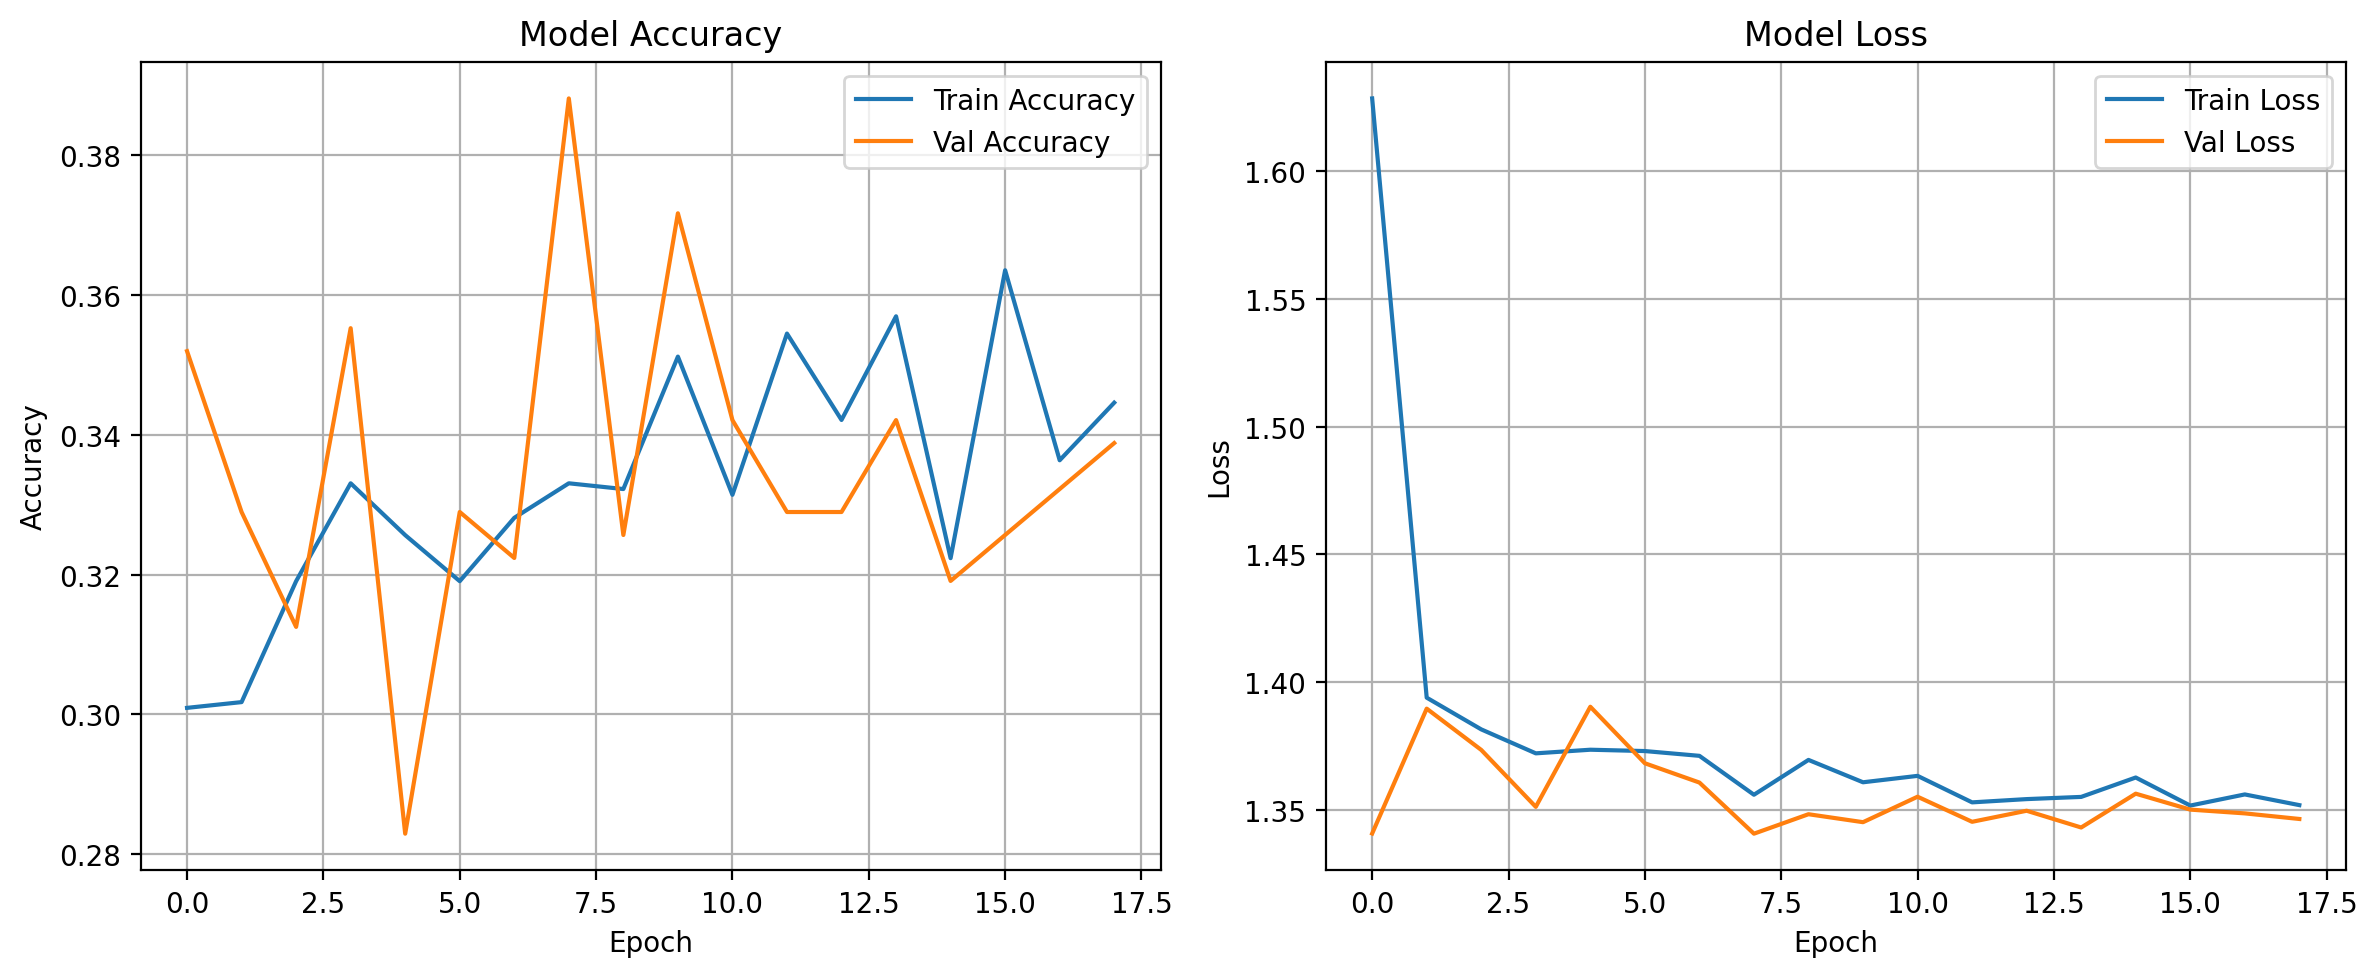

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step


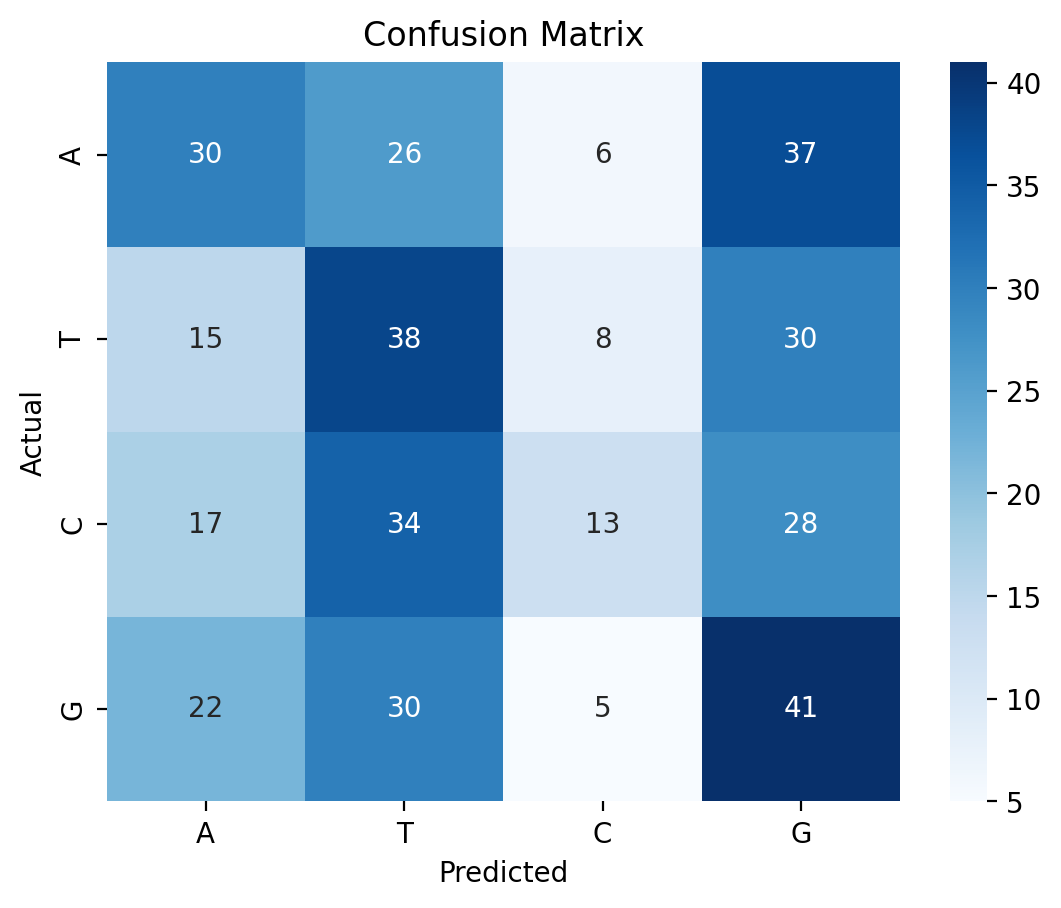


Classification Report:
               precision    recall  f1-score   support

           A       0.36      0.30      0.33        99
           T       0.30      0.42      0.35        91
           C       0.41      0.14      0.21        92
           G       0.30      0.42      0.35        98

    accuracy                           0.32       380
   macro avg       0.34      0.32      0.31       380
weighted avg       0.34      0.32      0.31       380

All tasks completed successfully!


In [ ]:
# ✅ Install dependencies
!pip install biopython einops

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from einops import rearrange
import warnings
warnings.filterwarnings('ignore')

# ✅ Swin Transformer Block
class SwinBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = LayerNormalization()
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.drop1 = Dropout(dropout)
        self.norm2 = LayerNormalization()
        self.mlp = tf.keras.Sequential([
            Dense(mlp_dim, activation='gelu'),
            Dropout(dropout),
            Dense(dim),
            Dropout(dropout)
        ])

    def call(self, x):
        attn_output = self.attn(x, x)
        x = x + self.drop1(attn_output)
        x = self.norm1(x)
        mlp_output = self.mlp(x)
        x = x + mlp_output
        return self.norm2(x)

# ✅ Main class
class SwinDNAMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length + 1]
                    X.append(self.dna_to_numeric(chunk[:-1]))
                    y.append(self.dna_to_numeric(chunk[1]))  # predict next token
        X = np.array(X)
        y = to_categorical(y, num_classes=4)
        return X, y

    def build_model(self):
        inputs = Input(shape=(self.sequence_length,))
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)
        for _ in range(4):  # deeper Swin blocks
            x = SwinBlock(dim=self.embedding_dim, num_heads=4, mlp_dim=128)(x)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.3)(x)
        outputs = Dense(4, activation='softmax')(x)
        model = Model(inputs, outputs, name="SwinDNA")
        return model

    def train(self, model, X_train, y_train, X_val, y_val, epochs=60):
        model.compile(optimizer=Adam(0.001),
                      loss=CategoricalCrossentropy(label_smoothing=0.1),
                      metrics=['accuracy'])
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ]
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1,
                            callbacks=callbacks)
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

# ✅ Run the full pipeline
modeler = SwinDNAMusic()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']
sequences = modeler.load_fasta(fasta_files)

print("Preparing dataset...")
X, y = modeler.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Building Swin Transformer model...")
model = modeler.build_model()

print("Training model...")
model, history = modeler.train(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
modeler.plot_training(history)

print("Evaluating model...")
modeler.evaluate(model, X_test, y_test)

print("All tasks completed successfully!")

# New Section

In [ ]:
#VIT TRANSFORMER MODEL

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     Embedding, GlobalAveragePooling1D, MultiHeadAttention,
                                     Add, Reshape)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import music21 as m21
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

class DNAViTMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4',
                      'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
        self.durations = [0.25, 0.5, 1.0, 2.0]
        self.sequence_length = 100
        self.embedding_dim = 64
        self.patch_size = 10

    def load_fasta_files(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq)
                if all(nuc in self.nucleotides for nuc in seq.upper()):
                    sequences.append(seq.upper())
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping.get(nuc, 0) for nuc in sequence.upper()]

    def numeric_to_music(self, numeric_seq):
        notes_seq = []
        durations_seq = []
        for i, num in enumerate(numeric_seq):
            note_idx = num % len(self.notes)
            dur_idx = (num + i) % len(self.durations)
            notes_seq.append(self.notes[note_idx])
            durations_seq.append(self.durations[dur_idx])
        return notes_seq, durations_seq

    def create_music_score(self, notes, durations, output_file):
        stream = m21.stream.Stream()
        for note, duration in zip(notes, durations):
            n = m21.note.Note(note)
            n.duration = m21.duration.Duration(duration)
            stream.append(n)
        stream.write('midi', output_file)
        return stream

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length]
                    target = seq[i + self.sequence_length]
                    X.append(self.dna_to_numeric(chunk))
                    y.append(self.dna_to_numeric(target)[0])
        X = np.array(X)
        y = to_categorical(y, num_classes=len(self.nucleotides))
        return X, y

    def transformer_block(self, x, num_heads):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=self.embedding_dim)(x, x)
        x = Add()([x, attn_output])
        x = LayerNormalization()(x)

        ff = Dense(self.embedding_dim * 2, activation='relu')(x)
        ff = Dense(self.patch_size * self.embedding_dim)(ff) # Corrected output dimension
        x = Add()([x, ff])
        x = LayerNormalization()(x)
        return x

    def create_vit_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)

        # Patch embedding
        num_patches = self.sequence_length // self.patch_size
        x = Reshape((num_patches, self.patch_size * self.embedding_dim))(x)

        # Transformer blocks
        for _ in range(4):
            x = self.transformer_block(x, num_heads=4)

        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.3)(x)
        outputs = Dense(4, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model

    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=50):
        model.compile(optimizer=Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1)
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Val')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Val')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('vit_training.png', dpi=300)
        plt.show()

    def evaluate_model(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig('vit_confusion.png', dpi=300)
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

    def generate_music(self, model, sequences, num_samples=3):
        for i in range(num_samples):
            seq = np.random.choice(sequences)
            start = np.random.randint(0, len(seq) - self.sequence_length)
            chunk = seq[start:start + self.sequence_length]
            numeric_seq = self.dna_to_numeric(chunk)
            notes, durations = self.numeric_to_music(numeric_seq)
            filename = f'vit_music_{i+1}.mid'
            self.create_music_score(notes, durations, filename)
            print(f"Music {i+1} saved as {filename}")

def main():
    converter = DNAViTMusic()

    print("Generating synthetic DNA sequences...")
    sequences = ["ATCG" * 50, "CGTA" * 50, "GCTA" * 50, "TACG" * 50] * 10

    print("Preparing dataset...")
    X, y = converter.prepare_dataset(sequences)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    print("Building ViT Transformer model...")
    model = converter.create_vit_model((converter.sequence_length,))

    print("Training model...")
    model, history = converter.train_model(model, X_train, y_train, X_val, y_val)

    print("Plotting training curves...")
    converter.plot_training(history)

    print("Evaluating model...")
    converter.evaluate_model(model, X_test, y_test)

    print("Generating music from DNA...")
    converter.generate_music(model, sequences, num_samples=3)

    print("All tasks completed successfully!")

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'Bio'

# New Section

In [ ]:
#VAE MODEL

Saving sequence.fasta to sequence (16).fasta
Loading DNA sequences...
Preparing dataset...
Building final VAE model...
Training model...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.2367 - loss: 1.5446 - val_accuracy: 0.2237 - val_loss: 1.4348 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2366 - loss: 1.4525 - val_accuracy: 0.2599 - val_loss: 1.3915 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2347 - loss: 1.4127 - val_accuracy: 0.2599 - val_loss: 1.3992 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2681 - loss: 1.3928 - val_accuracy: 0.2993 - val_loss: 1.3879 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2728 - loss: 1.3971 - val_accuracy: 0.2599 - val_loss: 1.3934 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2655 - loss: 1.3965 - val_accuracy: 0.2368 - v

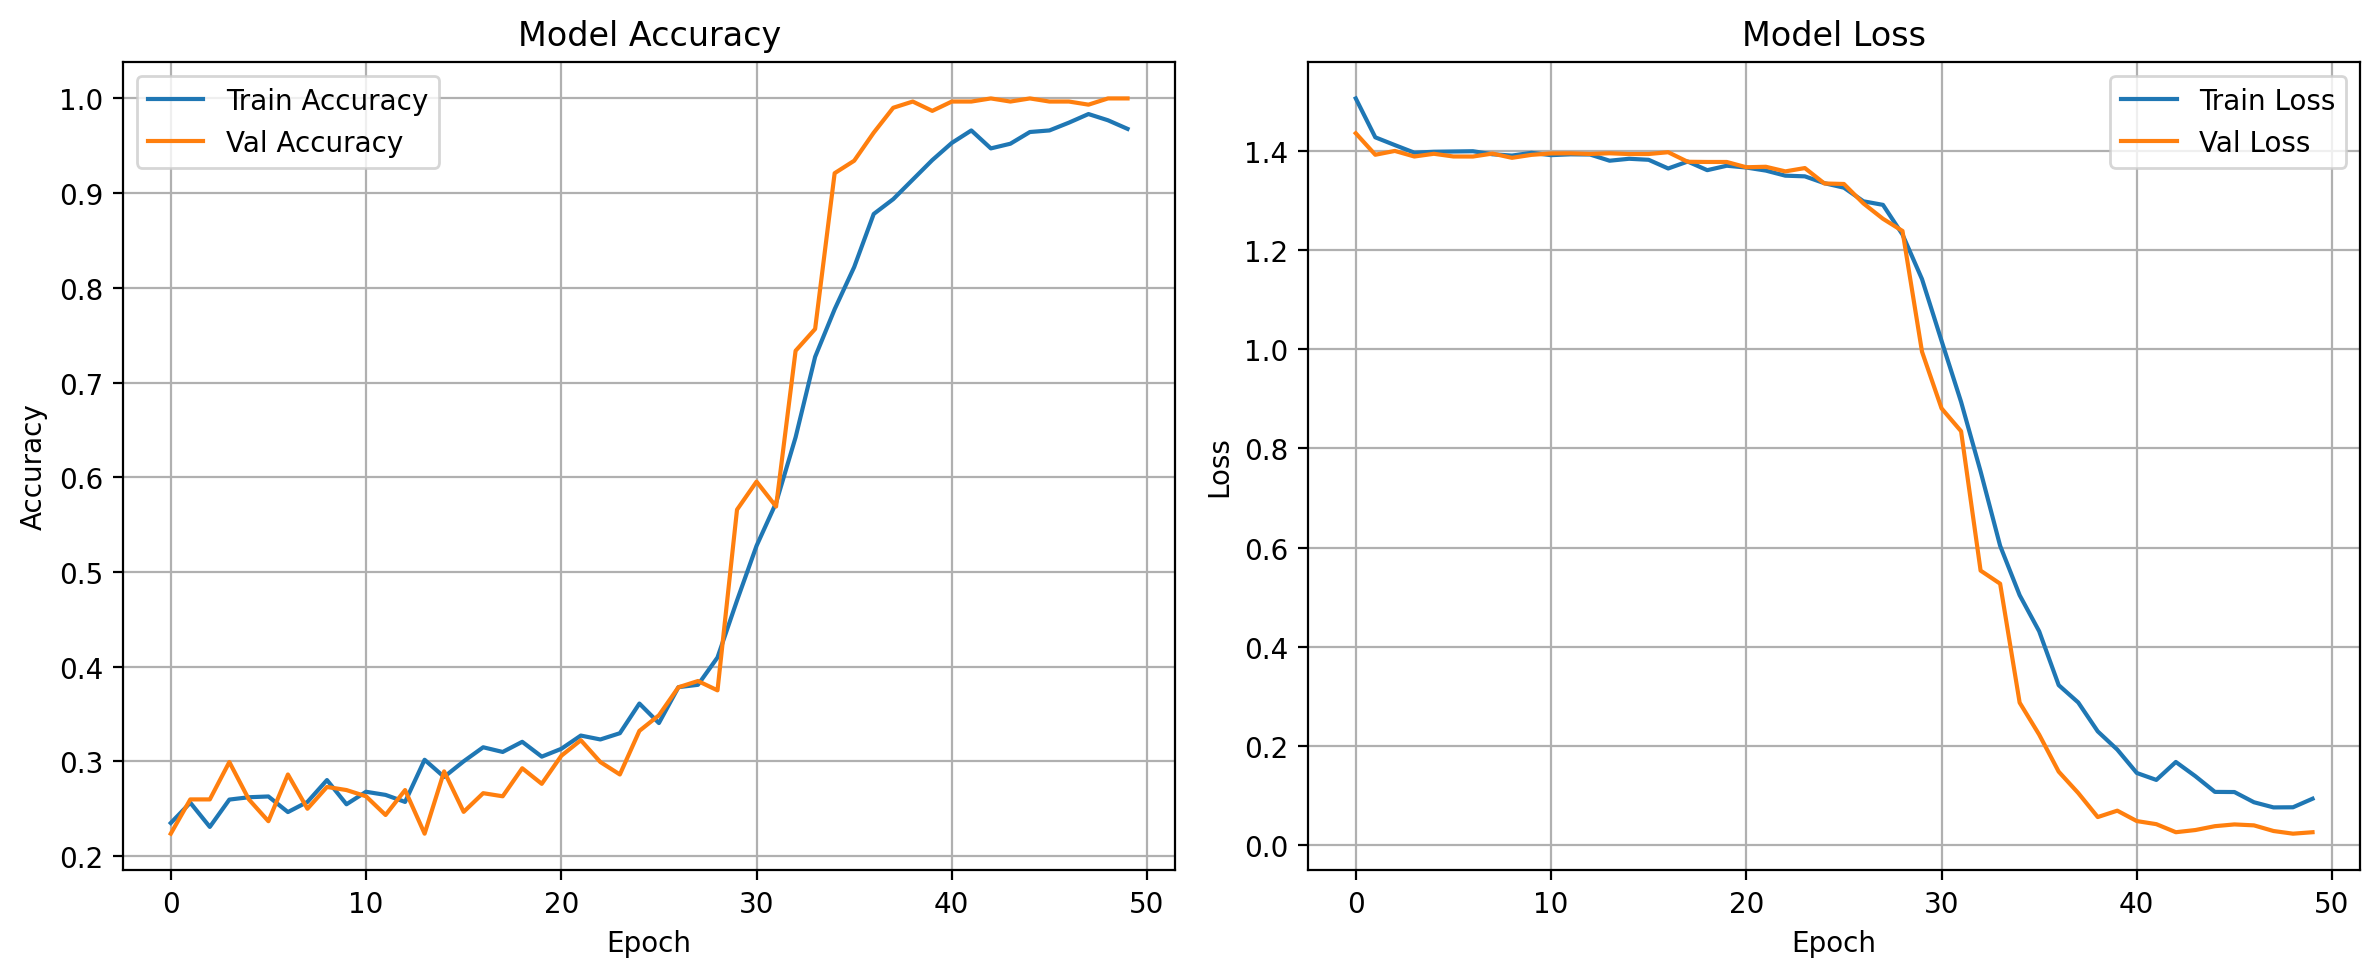

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


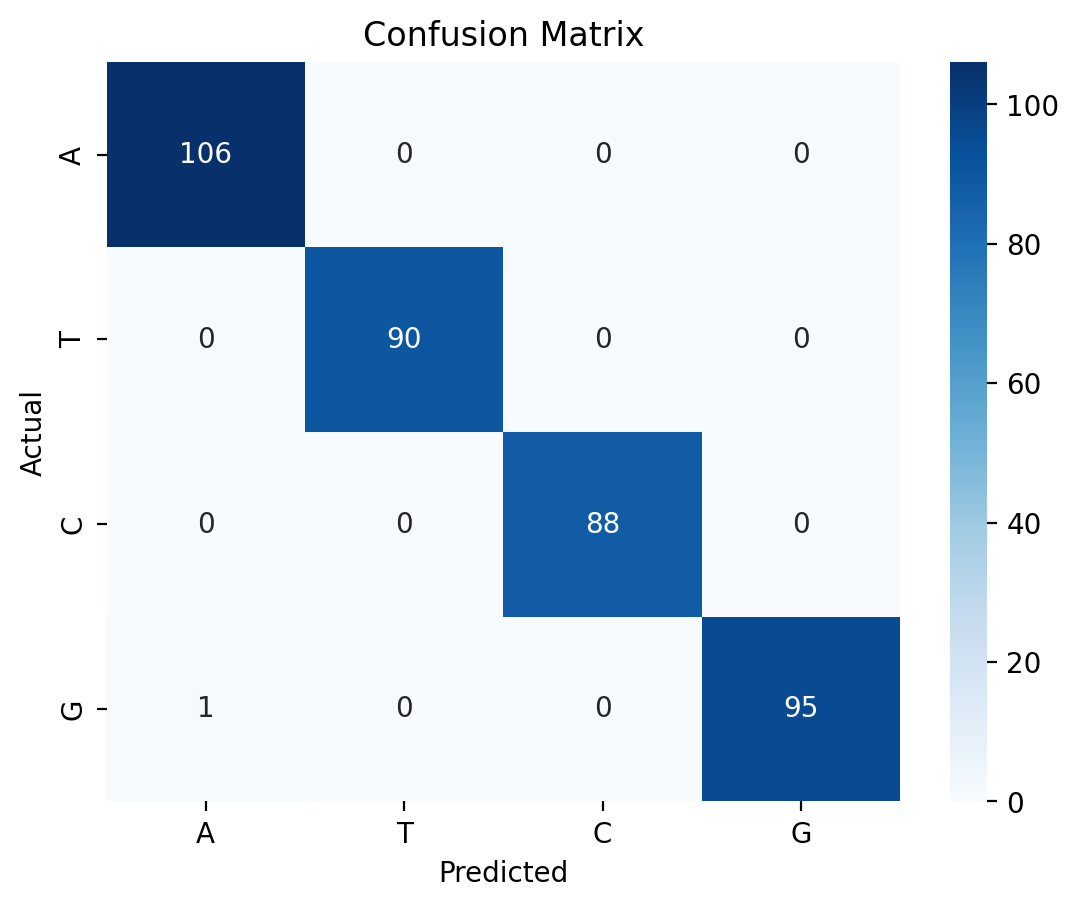


Classification Report:
               precision    recall  f1-score   support

           A       0.99      1.00      1.00       106
           T       1.00      1.00      1.00        90
           C       1.00      1.00      1.00        88
           G       1.00      0.99      0.99        96

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380

Generating music...
Music 1 saved as final_vae_music_1.mid
Music 2 saved as final_vae_music_2.mid
Music 3 saved as final_vae_music_3.mid
All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Embedding, Conv1D,
                                     Flatten, Reshape, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import music21 as m21
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Sampling Layer
class SamplingWithBetaKLD(tf.keras.layers.Layer):
    def __init__(self, beta=0.01, **kwargs):
        super(SamplingWithBetaKLD, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        self.add_loss(self.beta * kl_loss)
        return z

# ✅ Main Class
class DNAVaeMusicFinal:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4',
                      'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
        self.durations = [0.25, 0.5, 1.0, 2.0]
        self.sequence_length = 100
        self.embedding_dim = 64
        self.latent_dim = 64

    def load_fasta_files(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq)
                if all(nuc in self.nucleotides for nuc in seq.upper()):
                    sequences.append(seq.upper())
        return sequences

    def introduce_noise(self, sequence, noise_level=0.02):
        import random
        noisy = []
        for nuc in sequence:
            if random.random() < noise_level:
                noisy.append(random.choice([n for n in self.nucleotides if n != nuc]))
            else:
                noisy.append(nuc)
        return ''.join(noisy)

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping.get(nuc, 0) for nuc in sequence.upper()]

    def numeric_to_music(self, numeric_seq):
        notes_seq = []
        durations_seq = []
        for i, num in enumerate(numeric_seq):
            note_idx = num % len(self.notes)
            dur_idx = (num + i) % len(self.durations)
            notes_seq.append(self.notes[note_idx])
            durations_seq.append(self.durations[dur_idx])
        return notes_seq, durations_seq

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length:
                for i in range(0, len(seq) - self.sequence_length, 10):
                    chunk = seq[i:i + self.sequence_length]
                    X.append(self.dna_to_numeric(chunk))
                    y.append(self.dna_to_numeric(chunk)[0])
        return np.array(X), to_categorical(y, num_classes=4)

    def positional_encoding(self, length, depth):
        pos = np.arange(length)[:, np.newaxis]
        i = np.arange(depth)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(depth))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.convert_to_tensor(angle_rads, dtype=tf.float32)

    def create_vae_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)
        pos_encoding = self.positional_encoding(self.sequence_length, self.embedding_dim)
        x = x + pos_encoding

        x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.3)(x)

        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)
        z = SamplingWithBetaKLD(beta=0.01)([z_mean, z_log_var])

        encoder = Model(inputs, z, name='encoder')

        latent_inputs = Input(shape=(self.latent_dim,))
        x = Dense(128, activation='relu')(latent_inputs)
        x = Dropout(0.3)(x)
        x = Dense(self.sequence_length * self.embedding_dim, activation='relu')(x)
        x = Reshape((self.sequence_length, self.embedding_dim))(x)
        x = Flatten()(x)
        outputs = Dense(4, activation='softmax')(x)

        decoder = Model(latent_inputs, outputs, name='decoder')
        vae_outputs = decoder(encoder(inputs))
        vae = Model(inputs, vae_outputs, name='vae')
        return vae

    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=50):
        model.compile(optimizer=Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1,
                            callbacks=[lr_scheduler])
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('vae_training.png', dpi=300)
        plt.show()

    def evaluate_model(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig('vae_confusion.png', dpi=300)
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

    def generate_music(self, model, sequences, num_samples=3):
        for i in range(num_samples):
            seq = np.random.choice(sequences)
            start = np.random.randint(0, len(seq) - self.sequence_length)
            chunk = seq[start:start + self.sequence_length]
            numeric_seq = self.dna_to_numeric(chunk)
            notes, durations = self.numeric_to_music(numeric_seq)
            stream = m21.stream.Stream()
            for note, duration in zip(notes, durations):
                n = m21.note.Note(note)
                n.duration = m21.duration.Duration(duration)
                stream.append(n)
            stream.write('midi', f'final_vae_music_{i+1}.mid')
            print(f"Music {i+1} saved as final_vae_music_{i+1}.mid")


# ✅ Run the full pipeline
converter = DNAVaeMusicFinal()

print("Loading DNA sequences...")
fasta_files = ['sequence.fasta']  # Replace with your actual FASTA file path
sequences = converter.load_fasta_files(fasta_files)

print("Preparing dataset...")
X, y = converter.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Building final VAE model...")
model = converter.create_vae_model((converter.sequence_length,))

print("Training model...")
model, history = converter.train_model(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
converter.plot_training(history)

print("Evaluating model...")
converter.evaluate_model(model, X_test, y_test)

print("Generating music...")
converter.generate_music(model, sequences, num_samples=3)

print("All tasks completed successfully!")



Saving sequence.fasta to sequence (21).fasta
Loading DNA sequences...
Preparing dataset...
Building final VAE model...
Training model...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.2377 - loss: 1.5290 - val_accuracy: 0.2664 - val_loss: 1.3949 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2475 - loss: 1.4133 - val_accuracy: 0.2336 - val_loss: 1.4109 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2509 - loss: 1.4096 - val_accuracy: 0.2862 - val_loss: 1.3979 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2257 - loss: 1.4134 - val_accuracy: 0.2368 - val_loss: 1.3910 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2506 - loss: 1.3967 - val_accuracy: 0.2336 - val_loss: 1.4054 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2517 - loss: 1.3998 - val_accuracy: 0.2599 - va

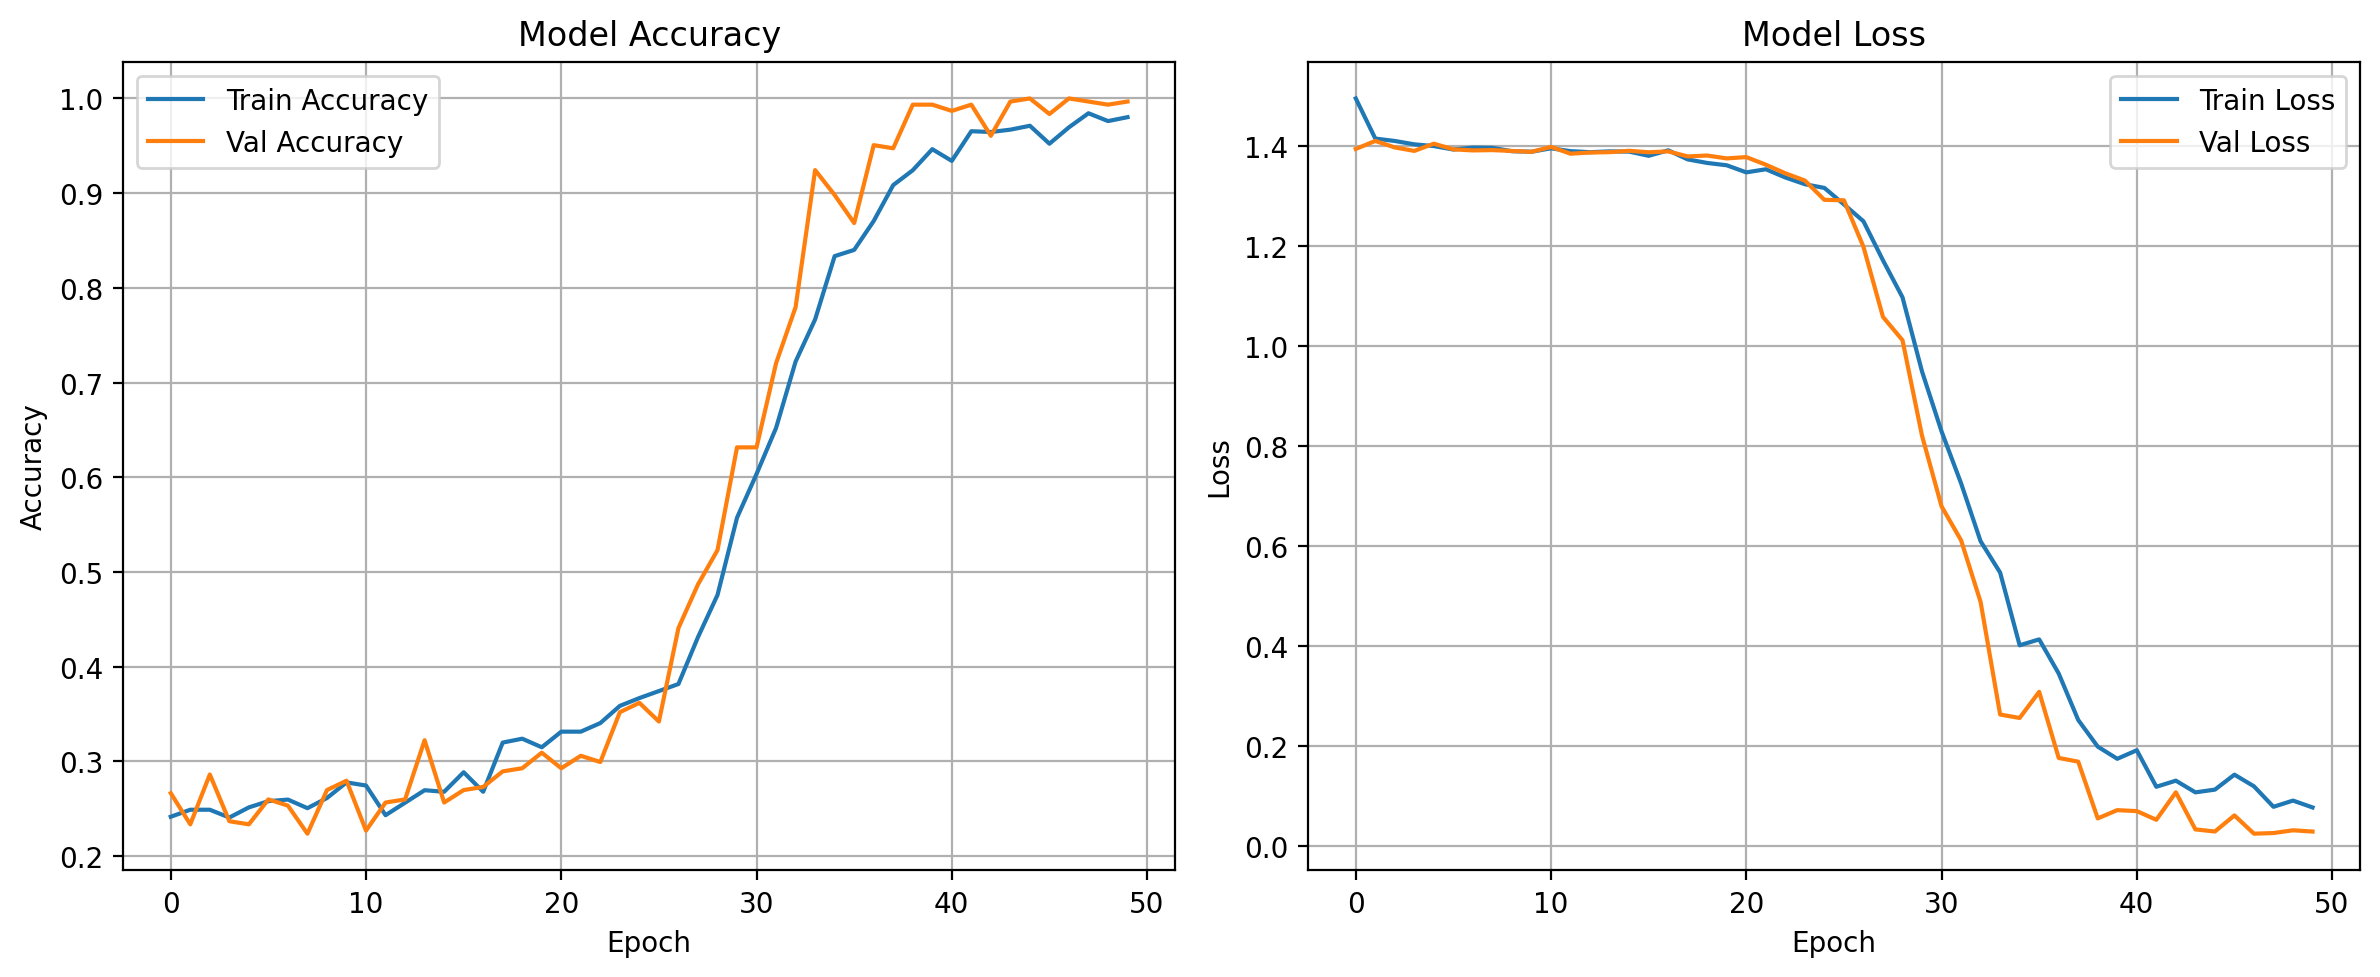

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


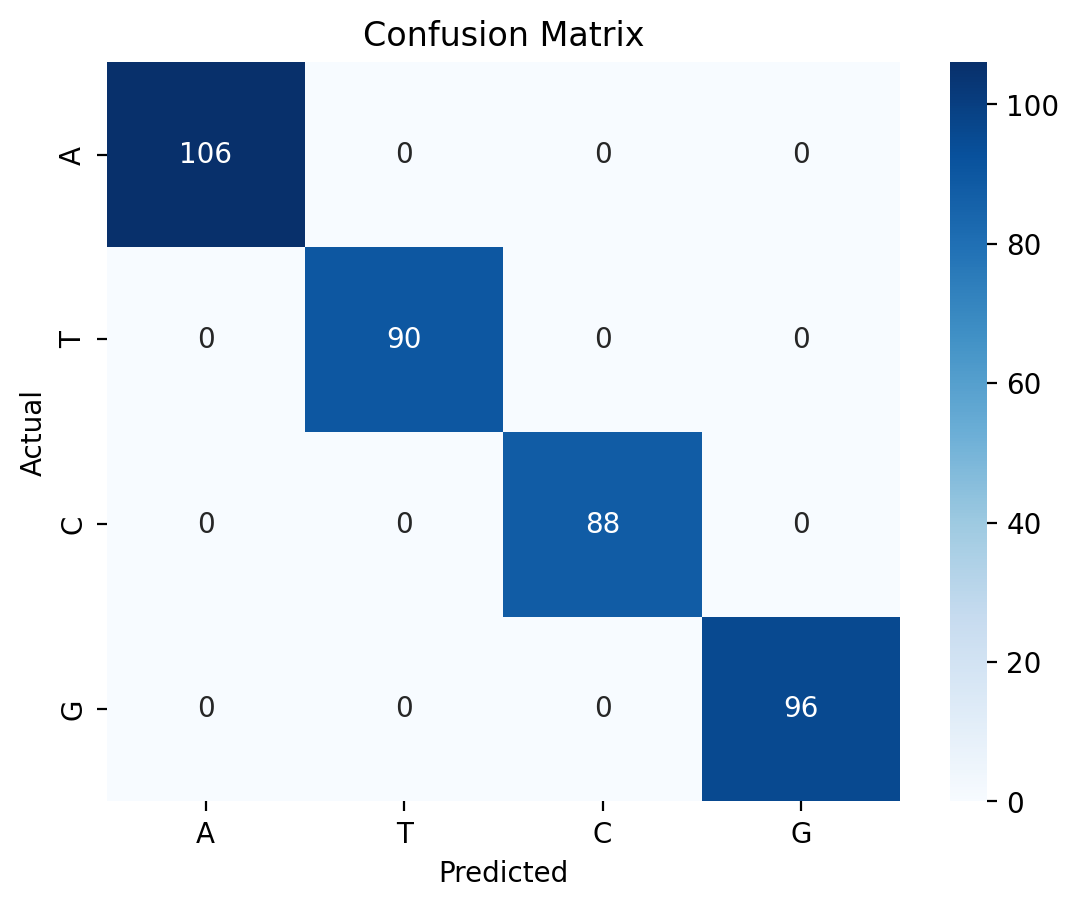


Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00       106
           T       1.00      1.00      1.00        90
           C       1.00      1.00      1.00        88
           G       1.00      1.00      1.00        96

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380

Generating music...
Music 1 saved as final_vae_music_1.mid
Music 2 saved as final_vae_music_2.mid
Music 3 saved as final_vae_music_3.mid
All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Embedding, Conv1D,
                                     Flatten, Reshape, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import music21 as m21
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Sampling Layer
class SamplingWithBetaKLD(tf.keras.layers.Layer):
    def __init__(self, beta=0.01, **kwargs):
        super(SamplingWithBetaKLD, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        self.add_loss(self.beta * kl_loss)
        return z

# ✅ Main Class
class DNAVaeMusicFinal:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4',
                      'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
        self.durations = [0.25, 0.5, 1.0, 2.0]
        self.sequence_length = 100
        self.embedding_dim = 64
        self.latent_dim = 64

    def load_fasta_files(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq)
                if all(nuc in self.nucleotides for nuc in seq.upper()):
                    sequences.append(seq.upper())
        return sequences

    def introduce_noise(self, sequence, noise_level=0.02):
        import random
        noisy = []
        for nuc in sequence:
            if random.random() < noise_level:
                noisy.append(random.choice([n for n in self.nucleotides if n != nuc]))
            else:
                noisy.append(nuc)
        return ''.join(noisy)

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping.get(nuc, 0) for nuc in sequence.upper()]

    def numeric_to_music(self, numeric_seq):
        notes_seq = []
        durations_seq = []
        for i, num in enumerate(numeric_seq):
            note_idx = num % len(self.notes)
            dur_idx = (num + i) % len(self.durations)
            notes_seq.append(self.notes[note_idx])
            durations_seq.append(self.durations[dur_idx])
        return notes_seq, durations_seq

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length:
                for i in range(0, len(seq) - self.sequence_length, 10):
                    chunk = seq[i:i + self.sequence_length]
                    X.append(self.dna_to_numeric(chunk))
                    y.append(self.dna_to_numeric(chunk)[0])
        return np.array(X), to_categorical(y, num_classes=4)

    def positional_encoding(self, length, depth):
        pos = np.arange(length)[:, np.newaxis]
        i = np.arange(depth)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(depth))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.convert_to_tensor(angle_rads, dtype=tf.float32)

    def create_vae_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)
        pos_encoding = self.positional_encoding(self.sequence_length, self.embedding_dim)
        x = x + pos_encoding

        x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.3)(x)

        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)
        z = SamplingWithBetaKLD(beta=0.01)([z_mean, z_log_var])

        encoder = Model(inputs, z, name='encoder')

        latent_inputs = Input(shape=(self.latent_dim,))
        x = Dense(128, activation='relu')(latent_inputs)
        x = Dropout(0.3)(x)
        x = Dense(self.sequence_length * self.embedding_dim, activation='relu')(x)
        x = Reshape((self.sequence_length, self.embedding_dim))(x)
        x = Flatten()(x)
        outputs = Dense(4, activation='softmax')(x)

        decoder = Model(latent_inputs, outputs, name='decoder')
        vae_outputs = decoder(encoder(inputs))
        vae = Model(inputs, vae_outputs, name='vae')
        return vae

    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=50):
        model.compile(optimizer=Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1,
                            callbacks=[lr_scheduler])
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('vae_training.png', dpi=300)
        plt.show()

    def evaluate_model(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig('vae_confusion.png', dpi=300)
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

    def generate_music(self, model, sequences, num_samples=3):
        for i in range(num_samples):
            seq = np.random.choice(sequences)
            start = np.random.randint(0, len(seq) - self.sequence_length)
            chunk = seq[start:start + self.sequence_length]
            numeric_seq = self.dna_to_numeric(chunk)
            notes, durations = self.numeric_to_music(numeric_seq)
            stream = m21.stream.Stream()
            for note, duration in zip(notes, durations):
                n = m21.note.Note(note)
                n.duration = m21.duration.Duration(duration)
                stream.append(n)
            stream.write('midi', f'final_vae_music_{i+1}.mid')
            print(f"Music {i+1} saved as final_vae_music_{i+1}.mid")


# ✅ Run the full pipeline
converter = DNAVaeMusicFinal()

print("Loading DNA sequences...")
fasta_files = ['sequence.fasta']  # Replace with your actual FASTA file path
sequences = converter.load_fasta_files(fasta_files)

print("Preparing dataset...")
X, y = converter.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Building final VAE model...")
model = converter.create_vae_model((converter.sequence_length,))

print("Training model...")
model, history = converter.train_model(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
converter.plot_training(history)

print("Evaluating model...")
converter.evaluate_model(model, X_test, y_test)

print("Generating music...")
converter.generate_music(model, sequences, num_samples=3)

print("All tasks completed successfully!")



# New Section

In [ ]:
#Transformer-VAE Hybrid for DNA-to-Music

Saving sequence.fasta to sequence (24).fasta
Loading FASTA sequences...
Preparing dataset...
Building Transformer-VAE model...
Training model...
Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 313ms/step - accuracy: 0.2567 - loss: 1.3991 - val_accuracy: 0.3586 - val_loss: 1.3697 - learning_rate: 0.0010
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2968 - loss: 1.3836 - val_accuracy: 0.2467 - val_loss: 1.3902 - learning_rate: 0.0010
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2984 - loss: 1.3696 - val_accuracy: 0.2829 - val_loss: 1.3744 - learning_rate: 0.0010
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2999 - loss: 1.3688 - val_accuracy: 0.2993 - val_loss: 1.3690 - learning_rate: 0.0010
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2701 - loss: 1.3789 - val_accuracy: 0.3191 - val_loss: 1.3584 - learning_rate: 0.0010
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3220 - loss: 1.3600 - val_accurac

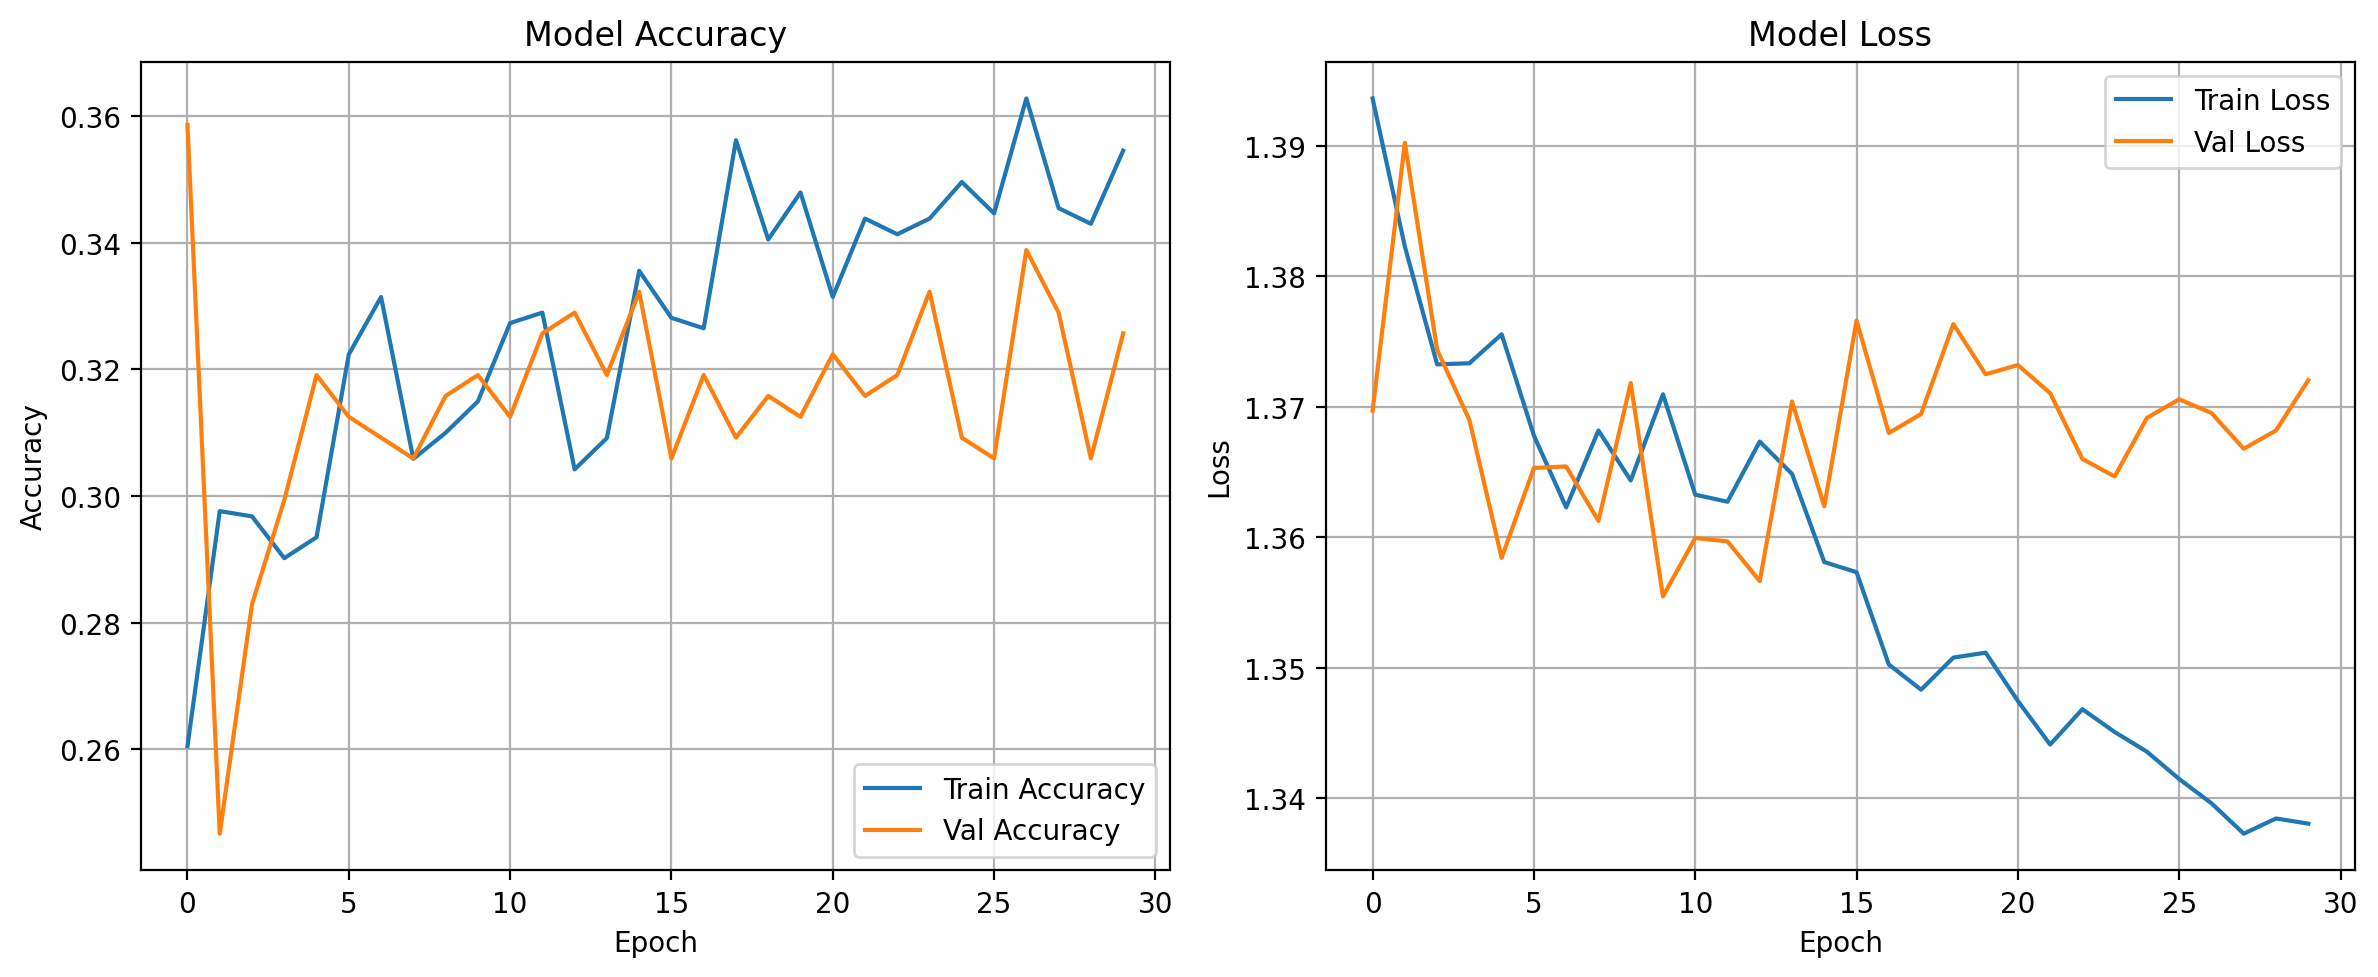

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step


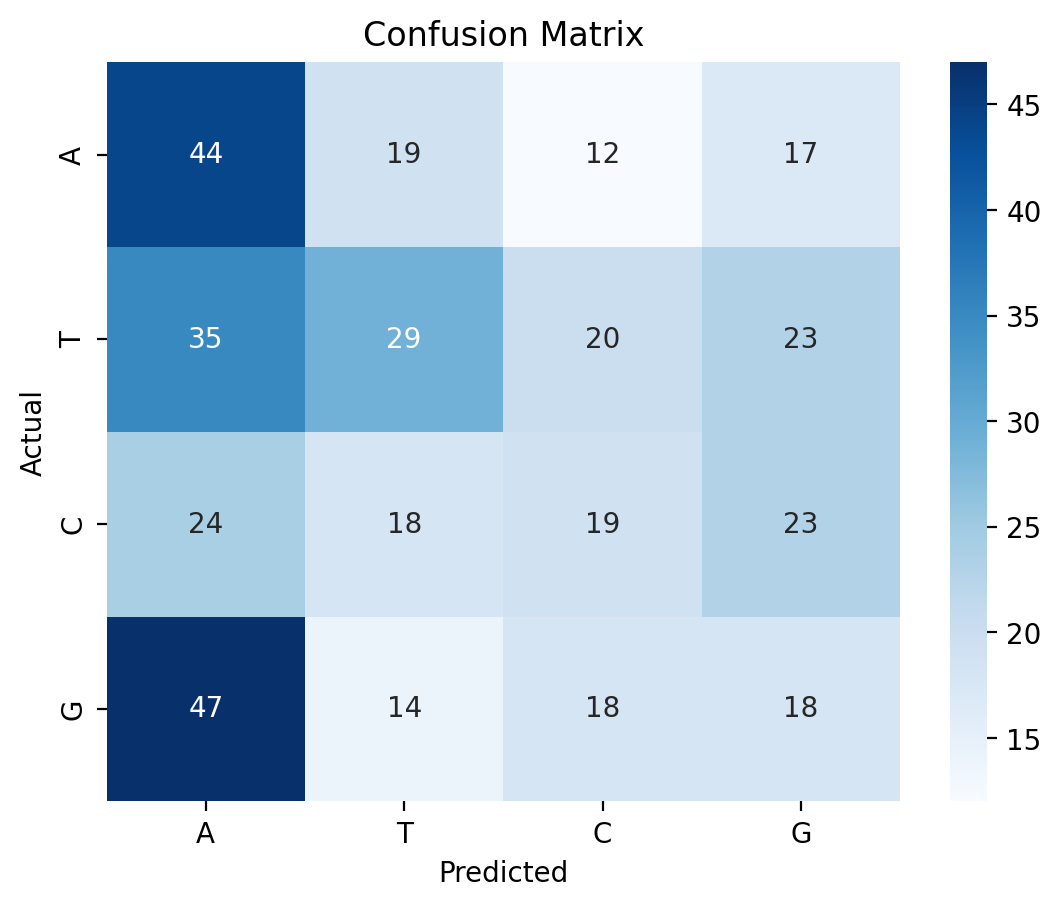


Classification Report:
               precision    recall  f1-score   support

           A       0.29      0.48      0.36        92
           T       0.36      0.27      0.31       107
           C       0.28      0.23      0.25        84
           G       0.22      0.19      0.20        97

    accuracy                           0.29       380
   macro avg       0.29      0.29      0.28       380
weighted avg       0.29      0.29      0.28       380

All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Embedding, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, Reshape)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Sampling layer for VAE
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ✅ Transformer block (updated to remove training argument)
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output))

# ✅ Main class
class TransformerVaeDNA:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64
        self.latent_dim = 32

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length:
                for i in range(0, len(seq) - self.sequence_length, 10):
                    chunk = seq[i:i + self.sequence_length]
                    X.append(self.dna_to_numeric(chunk))
                    y.append(self.dna_to_numeric(chunk)[0])
        return np.array(X), to_categorical(y, num_classes=4)

    def build_model(self):
        inputs = Input(shape=(self.sequence_length,))
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)

        for _ in range(2):
            x = TransformerBlock(self.embedding_dim, num_heads=4, ff_dim=128)(x)

        x = GlobalAveragePooling1D()(x)
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)
        z = Sampling()([z_mean, z_log_var])

        encoder = Model(inputs, z, name="TransformerEncoder")

        latent_inputs = Input(shape=(self.latent_dim,))
        x = Dense(128, activation='relu')(latent_inputs)
        x = Dropout(0.3)(x)
        x = Dense(self.sequence_length * self.embedding_dim, activation='relu')(x)
        x = Reshape((self.sequence_length, self.embedding_dim))(x)
        x = GlobalAveragePooling1D()(x)
        outputs = Dense(4, activation='softmax')(x)

        decoder = Model(latent_inputs, outputs, name="Decoder")
        vae_outputs = decoder(encoder(inputs))
        vae = Model(inputs, vae_outputs, name="TransformerVAE")
        return vae

    def train(self, model, X_train, y_train, X_val, y_val, epochs=30):
        model.compile(optimizer=Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1,
                            callbacks=[lr_scheduler])
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

# ✅ Run the full pipeline
modeler = TransformerVaeDNA()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']  # Replace with your actual file
sequences = modeler.load_fasta(fasta_files)

print("Preparing dataset...")
X, y = modeler.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Building Transformer-VAE model...")
model = modeler.build_model()

print("Training model...")
model, history = modeler.train(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
modeler.plot_training(history)

print("Evaluating model...")
modeler.evaluate(model, X_test, y_test)

print("All tasks completed successfully!")

# New Section

In [ ]:
#Autoregressive Transformer (GPT-style)

Saving sequence.fasta to sequence (30).fasta
Loading FASTA sequences...
Preparing dataset...
Building GPT-style model...
Training model...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 912ms/step - accuracy: 0.2600 - loss: 1.5559 - val_accuracy: 0.2994 - val_loss: 1.3718 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2868 - loss: 1.3825 - val_accuracy: 0.3046 - val_loss: 1.3545 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2991 - loss: 1.3677 - val_accuracy: 0.3000 - val_loss: 1.3539 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3052 - loss: 1.3594 - val_accuracy: 0.3135 - val_loss: 1.3526 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3085 - loss: 1.3580 - val_accuracy: 0.3312 - val_loss: 1.3456 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3298 - loss: 1.3468 - val_accuracy: 0.3

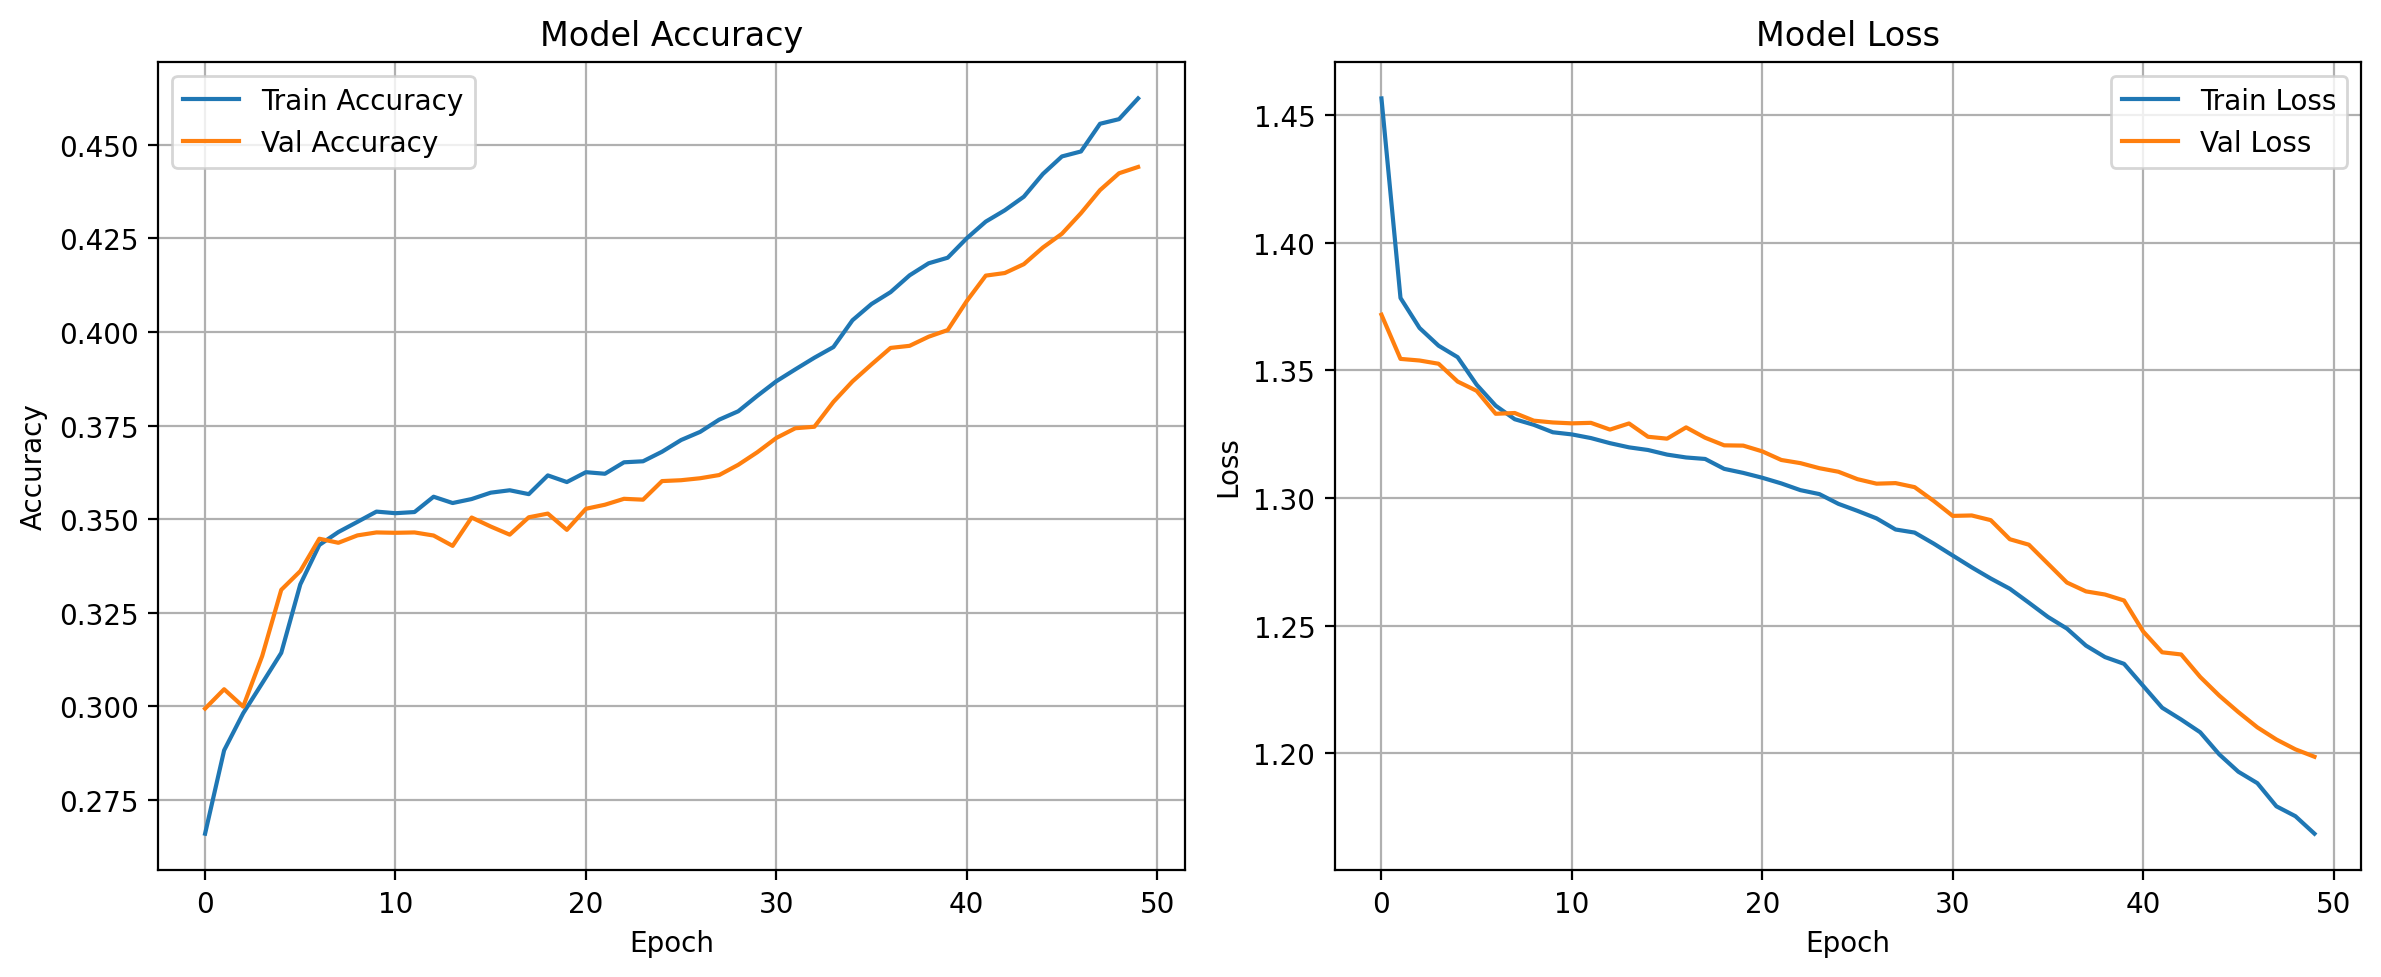

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 624ms/step


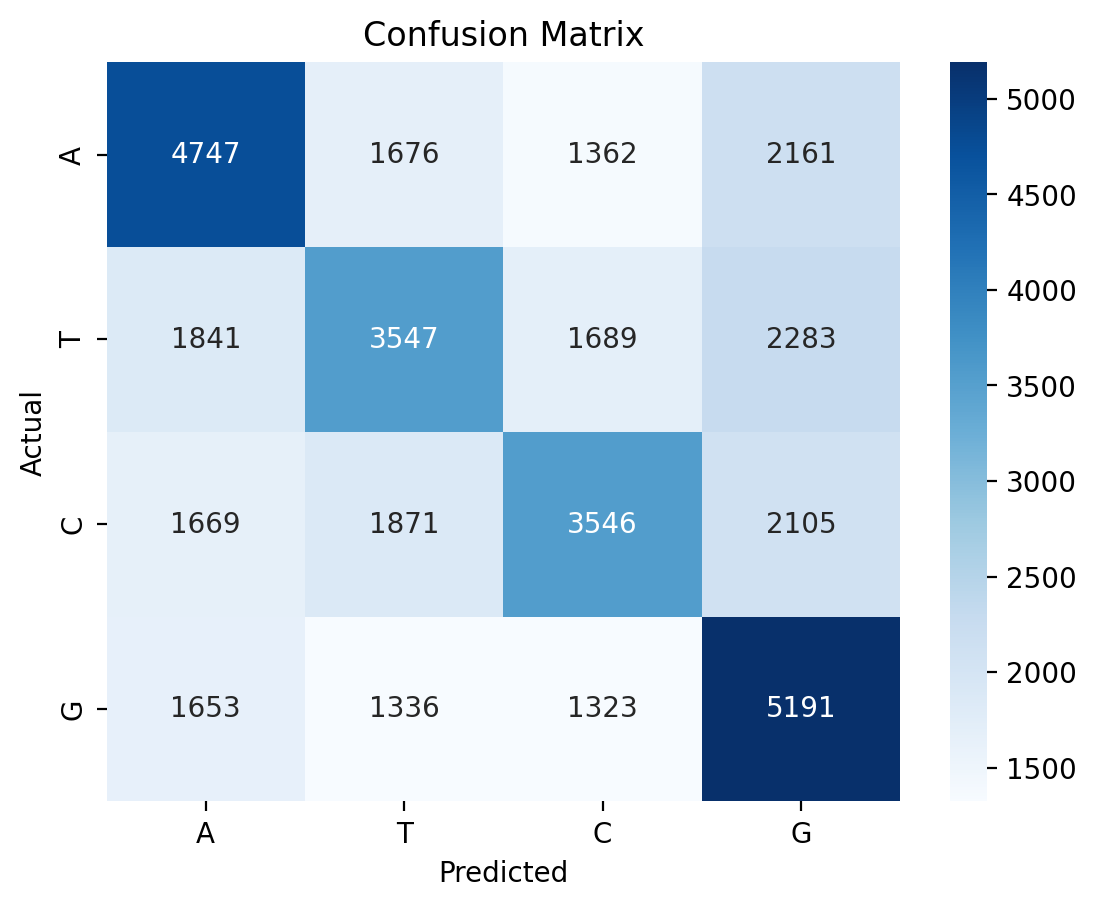


Classification Report:
               precision    recall  f1-score   support

           A       0.48      0.48      0.48      9946
           T       0.42      0.38      0.40      9360
           C       0.45      0.39      0.41      9191
           G       0.44      0.55      0.49      9503

    accuracy                           0.45     38000
   macro avg       0.45      0.45      0.45     38000
weighted avg       0.45      0.45      0.45     38000

All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Embedding, LayerNormalization,
                                     MultiHeadAttention, Add, TimeDistributed)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Positional Encoding
def positional_encoding(length, depth):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(depth)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(depth))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]  # shape: [1, length, depth]
    return tf.cast(pos_encoding, dtype=tf.float32)

# ✅ Causal Mask
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    mask = tf.cast(i >= j, dtype)
    return tf.reshape(mask, [1, n_dest, n_src])

# ✅ Transformer Decoder Block
class GPTBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        attn_mask = causal_attention_mask(tf.shape(inputs)[0],
                                          tf.shape(inputs)[1],
                                          tf.shape(inputs)[1],
                                          tf.float32)
        attn_output = self.att(inputs, inputs, attention_mask=attn_mask)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output))

# ✅ Main class
class GPTDNA:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length + 1]
                    X.append(self.dna_to_numeric(chunk[:-1]))
                    y.append(self.dna_to_numeric(chunk[1:]))  # next-token sequence
        X = np.array(X)
        y = np.array(y)
        y = to_categorical(y, num_classes=4)  # shape: (samples, sequence_length, 4)
        return X, y

    def build_model(self):
        inputs = Input(shape=(self.sequence_length,))
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)
        pos_encoding = positional_encoding(self.sequence_length, self.embedding_dim)
        x = Add()([x, pos_encoding])

        for _ in range(2):
            x = GPTBlock(self.embedding_dim, num_heads=4, ff_dim=128)(x)

        outputs = TimeDistributed(Dense(4, activation='softmax'))(x)
        model = Model(inputs, outputs, name="GPTDNA")
        return model

    def train(self, model, X_train, y_train, X_val, y_val, epochs=50):
        model.compile(optimizer=Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1,
                            callbacks=[lr_scheduler])
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=-1).flatten()
        y_pred = np.argmax(model.predict(X_test), axis=-1).flatten()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

# ✅ Run the full pipeline
modeler = GPTDNA()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']
sequences = modeler.load_fasta(fasta_files)

print("Preparing dataset...")
X, y = modeler.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Building GPT-style model...")
model = modeler.build_model()

print("Training model...")
model, history = modeler.train(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
modeler.plot_training(history)

print("Evaluating model...")
modeler.evaluate(model, X_test, y_test)

print("All tasks completed successfully!")

# New Section

In [ ]:
#contrastive learning + decoder

Saving sequence.fasta to sequence (54).fasta
Loading FASTA sequences...
Preparing contrastive pairs...
Building encoder...
Building contrastive model...
Training contrastive model...
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1261
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0602
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0368
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257
Epoch 11/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282
Epoch 12/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264
Epoch 13/30
59/59 ━━━━━━━━━━━━━━━━

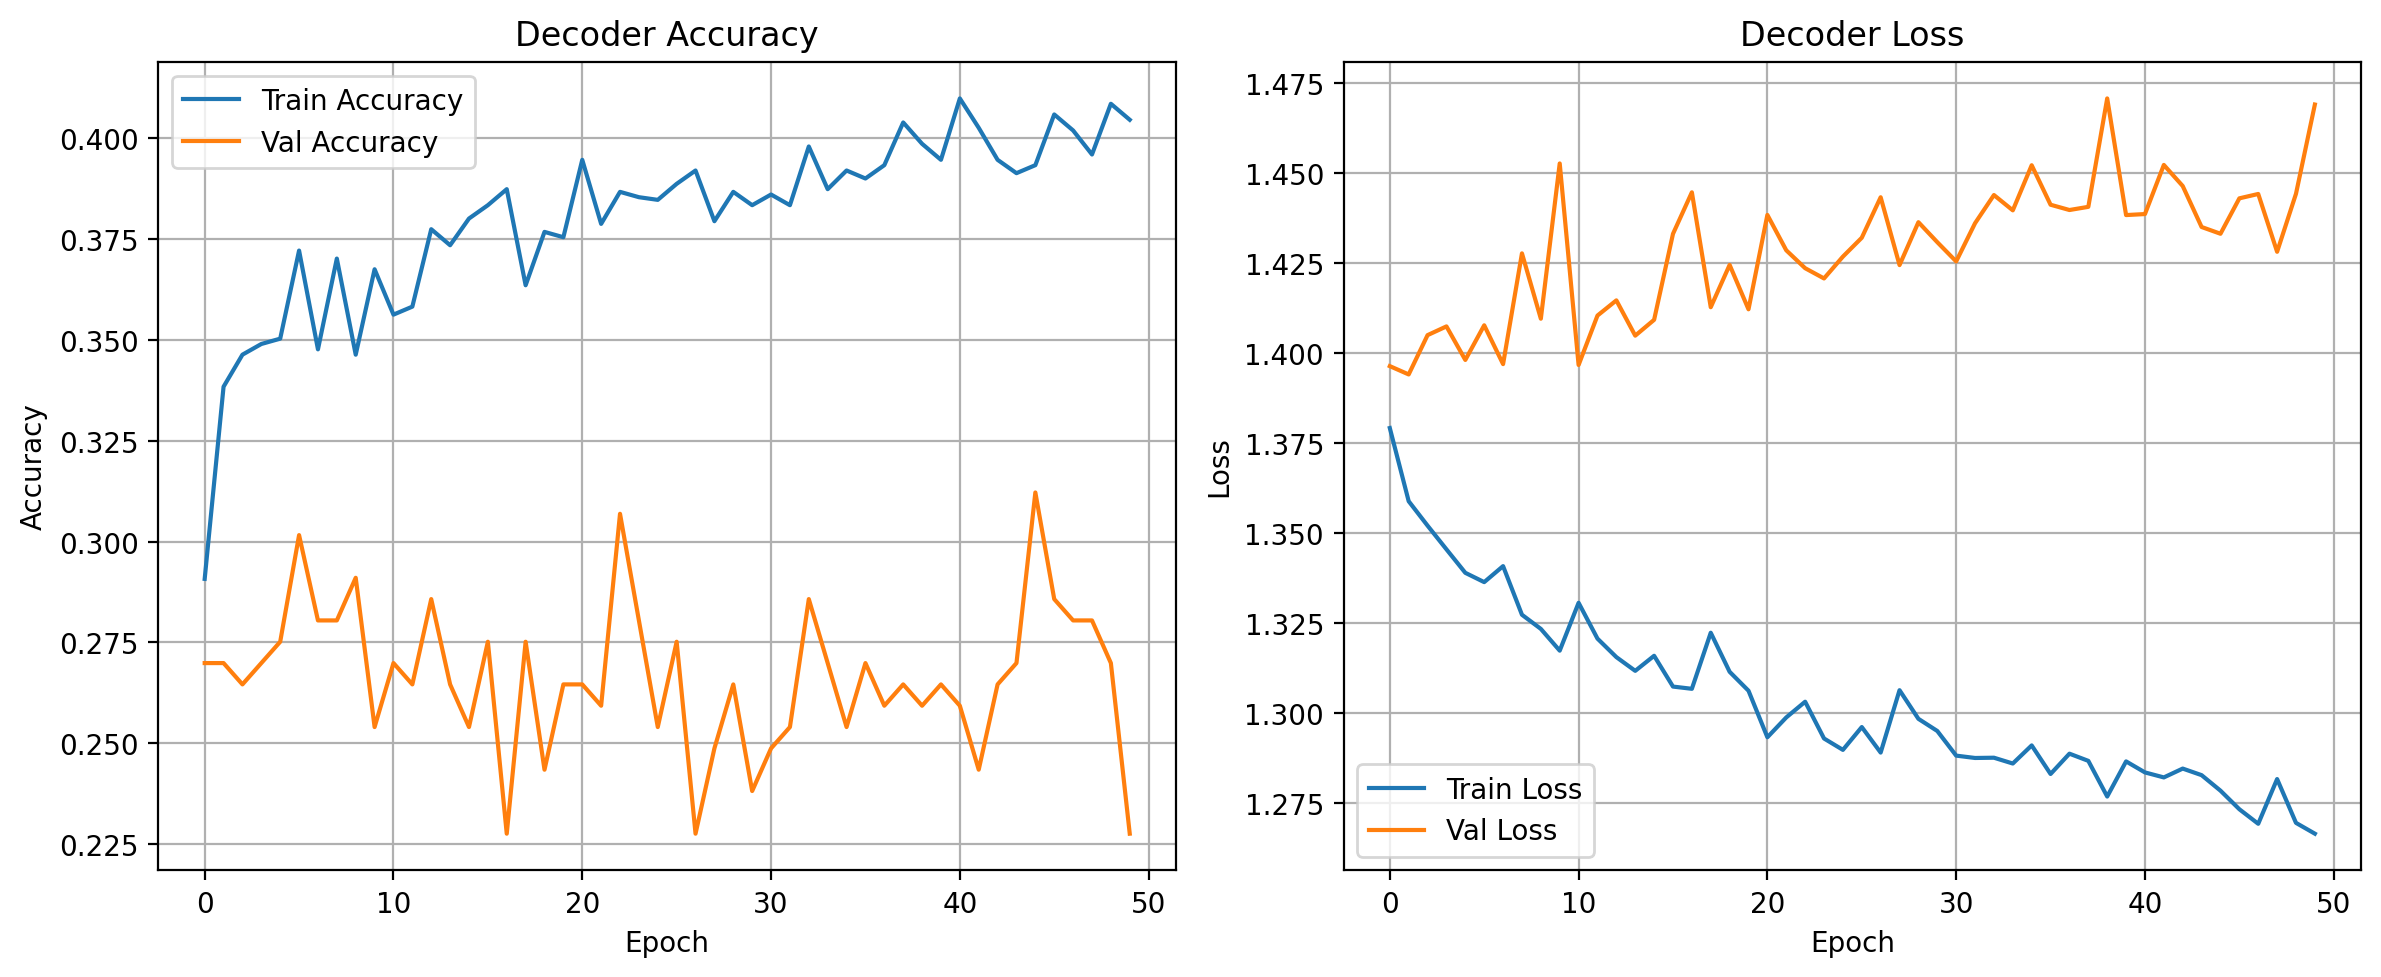

Evaluating decoder...
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


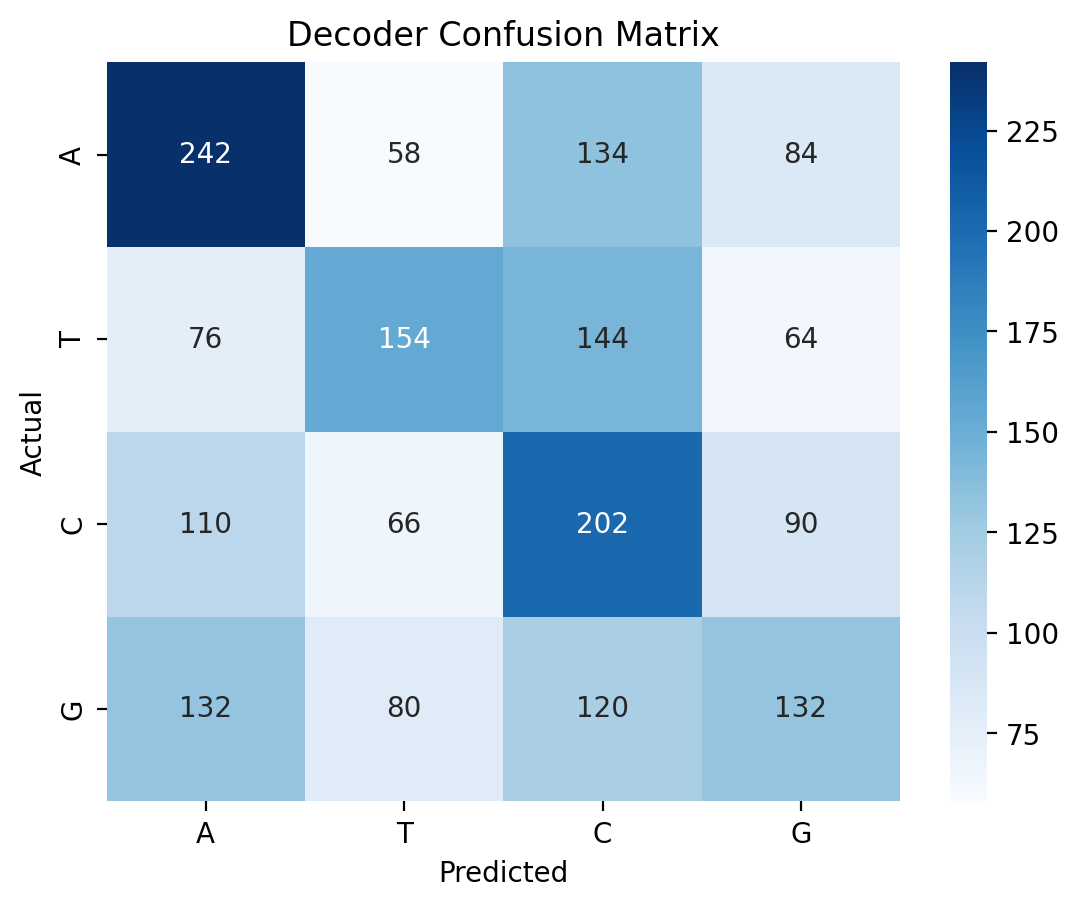


Decoder Classification Report:
               precision    recall  f1-score   support

           A       0.43      0.47      0.45       518
           T       0.43      0.35      0.39       438
           C       0.34      0.43      0.38       468
           G       0.36      0.28      0.32       464

    accuracy                           0.39      1888
   macro avg       0.39      0.38      0.38      1888
weighted avg       0.39      0.39      0.38      1888

All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Main class
class ContrastiveDNA:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64
        self.latent_dim = 64

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_contrastive_pairs(self, sequences):
        X1, X2, labels = [], [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length * 2:
                for i in range(0, len(seq) - self.sequence_length * 2, 20):
                    chunk1 = seq[i:i + self.sequence_length]
                    chunk2 = seq[i + 10:i + 10 + self.sequence_length]
                    X1.append(self.dna_to_numeric(chunk1))
                    X2.append(self.dna_to_numeric(chunk2))
                    labels.append(1)  # positive pair

                    rand_seq = np.random.choice(sequences)
                    rand_chunk = rand_seq[:self.sequence_length]
                    X1.append(self.dna_to_numeric(chunk1))
                    X2.append(self.dna_to_numeric(rand_chunk))
                    labels.append(0)
        return np.array(X1), np.array(X2), np.array(labels)

    def build_encoder(self):
        inputs = Input(shape=(self.sequence_length,))
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)
        x = GlobalAveragePooling1D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(self.latent_dim)(x)
        return Model(inputs, outputs, name="DNAEncoder")

    def contrastive_loss(self, margin=0.5):
        def loss(y_true, y_pred):
            z1, z2 = tf.split(y_pred, num_or_size_splits=2, axis=1)
            z1 = tf.nn.l2_normalize(z1, axis=1)
            z2 = tf.nn.l2_normalize(z2, axis=1)
            cos_sim = tf.reduce_sum(z1 * z2, axis=1)
            return tf.reduce_mean(y_true * (1 - cos_sim) + (1 - y_true) * tf.maximum(0.0, cos_sim - margin))
        return loss

    def build_contrastive_model(self, encoder):
        input1 = Input(shape=(self.sequence_length,))
        input2 = Input(shape=(self.sequence_length,))
        z1 = encoder(input1)
        z2 = encoder(input2)
        merged = Lambda(lambda x: tf.concat(x, axis=1))([z1, z2])
        model = Model([input1, input2], merged)
        return model

    def train_contrastive(self, model, X1, X2, labels, epochs=30):
        model.compile(optimizer=Adam(0.001),
                      loss=self.contrastive_loss(),
                      metrics=[])
        history = model.fit([X1, X2], labels,
                            epochs=epochs,
                            batch_size=32,
                            verbose=1)
        return model, history

    def build_decoder(self, encoder):
        latent_inputs = Input(shape=(self.sequence_length,))
        x = encoder(latent_inputs)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(4, activation='softmax')(x)
        return Model(latent_inputs, outputs, name="MusicDecoder")

    def train_decoder(self, decoder, X, y, epochs=50):
        decoder.compile(optimizer=Adam(0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
        history = decoder.fit(X, y,
                              validation_split=0.2,
                              epochs=epochs,
                              batch_size=32,
                              verbose=1)
        return decoder, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Decoder Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Decoder Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate_decoder(self, decoder, X, y):
        y_true = np.argmax(y, axis=1)
        y_pred = np.argmax(decoder.predict(X), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Decoder Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nDecoder Classification Report:\n", report)

# ✅ Run the full pipeline
modeler = ContrastiveDNA()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']
sequences = modeler.load_fasta(fasta_files)

print("Preparing contrastive pairs...")
X1, X2, labels = modeler.prepare_contrastive_pairs(sequences)

print("Building encoder...")
encoder = modeler.build_encoder()

print("Building contrastive model...")
contrastive_model = modeler.build_contrastive_model(encoder)

print("Training contrastive model...")
contrastive_model, _ = modeler.train_contrastive(contrastive_model, X1, X2, labels)

print("Building decoder for music generation...")
decoder = modeler.build_decoder(encoder)

print("Preparing decoder dataset...")
X_decoder = X1
y_decoder = np.array([x[0] for x in X1])  # predict first nucleotide
y_decoder = to_categorical(y_decoder, num_classes=4)

print("Training decoder...")
decoder, history = modeler.train_decoder(decoder, X_decoder, y_decoder)

print("Plotting training curves...")
modeler.plot_training(history)

print("Evaluating decoder...")
modeler.evaluate_decoder(decoder, X_decoder, y_decoder)

print("All tasks completed successfully!")

# New Section

In [ ]:
#Conditional GAN (cGAN) for DNA-to-Music

Saving sequence.fasta to sequence (49).fasta
Loading FASTA sequences...
Preparing dataset...
Building generator and discriminator...
Training cGAN...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Epoch 1/50 | D Loss: 0.6922 | D Acc: 0.1032 | G Loss: 0.6891
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 2/50 | D Loss: 0.6932 | D Acc: 0.1712 | G Loss: 0.6895
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 3/50 | D Loss: 0.6932 | D Acc: 0.1824 | G Loss: 0.6895
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 4/50 | D Loss: 0.6933 | D Acc: 0.1867 | G Loss: 0.6895
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 5/50 | D Loss: 0.6934 | D Acc: 0.1909 | G Loss: 0.6894
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 6/50 | D Loss: 0.6934 | D Acc: 0.1931 | G Loss: 0.6893
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 7/50 | D Loss: 0.6935 | D Acc: 0.1934 | G Loss: 0.6893
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 8/50 | D Loss: 0.6936 | D Acc: 0.1936 | G Loss: 0.6893
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Ep

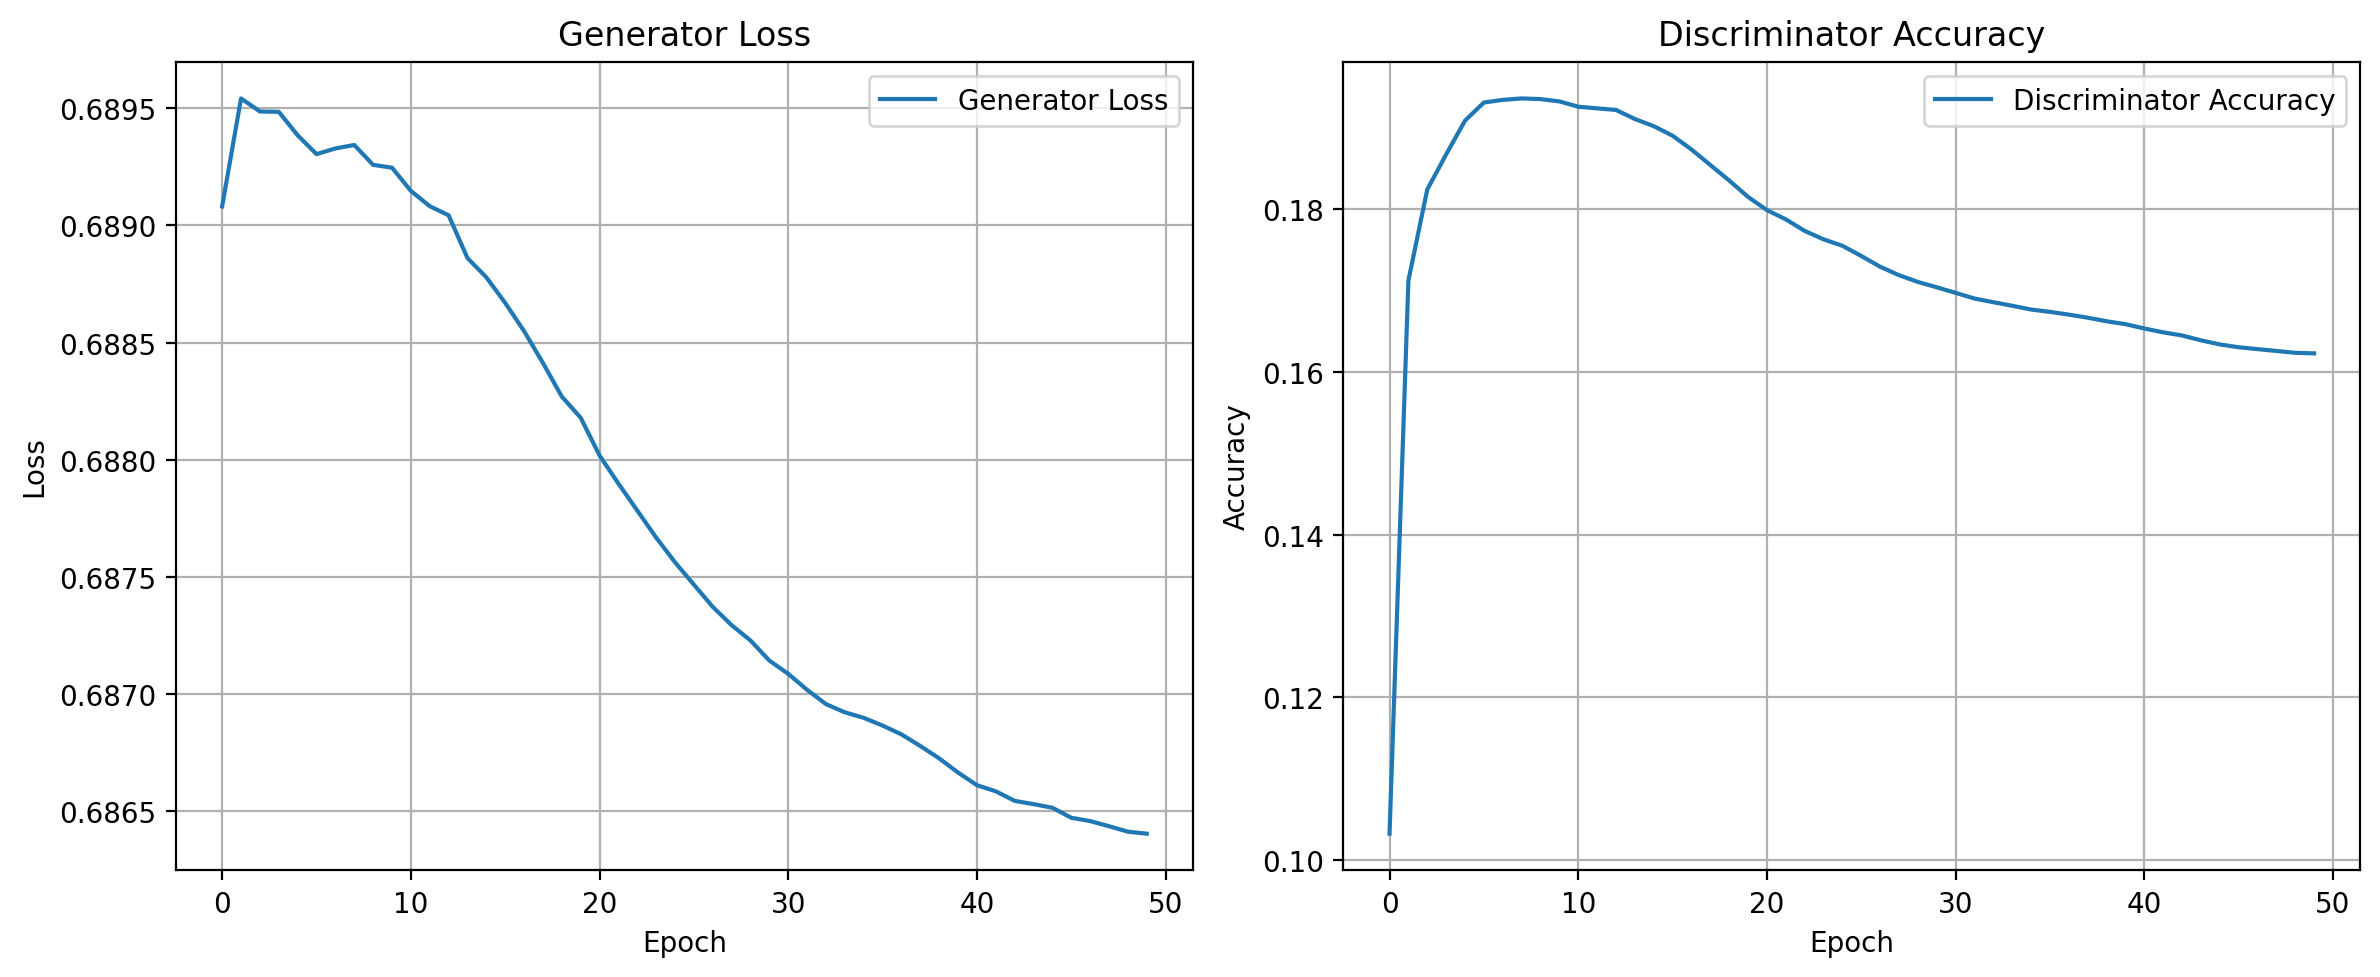

Evaluating generator...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


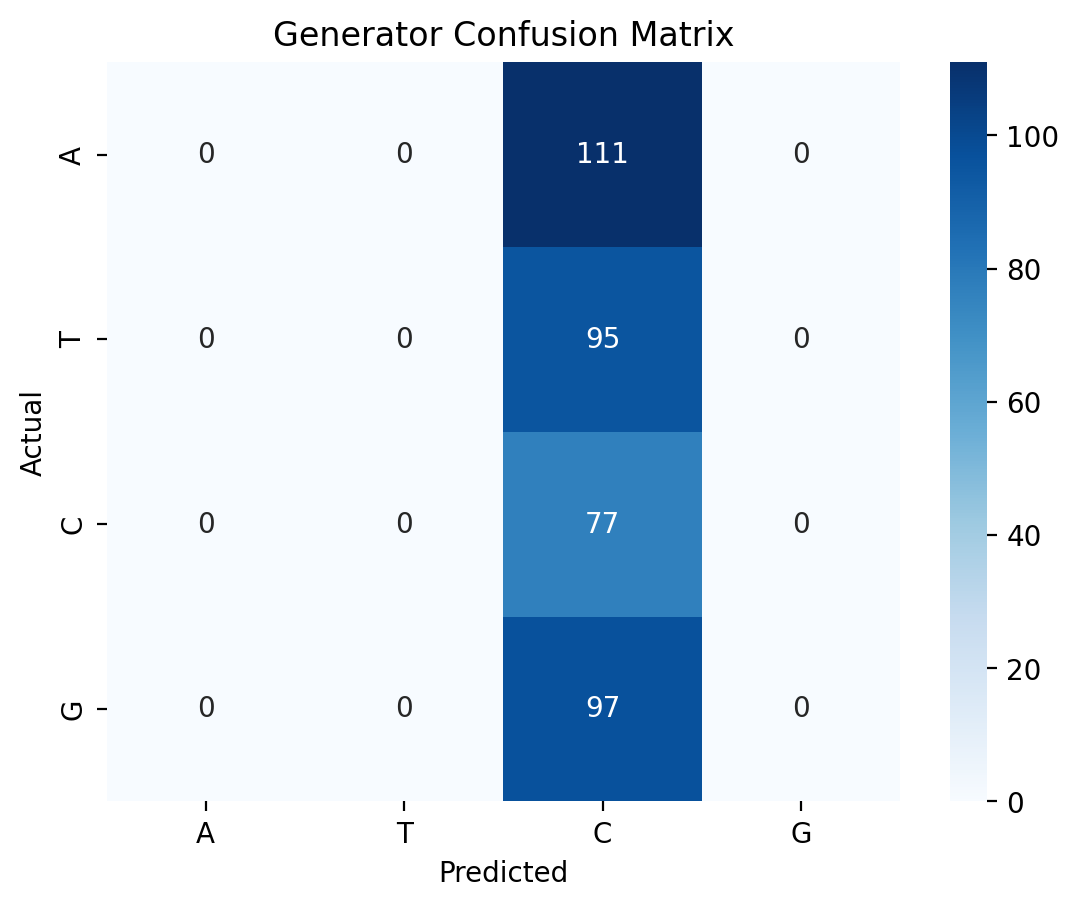


Generator Classification Report:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00       111
           T       0.00      0.00      0.00        95
           C       0.20      1.00      0.34        77
           G       0.00      0.00      0.00        97

    accuracy                           0.20       380
   macro avg       0.05      0.25      0.08       380
weighted avg       0.04      0.20      0.07       380

All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Main class
class CGANDNAMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length + 1]
                    X.append(self.dna_to_numeric(chunk[:-1]))
                    y.append(self.dna_to_numeric(chunk[1]))  # predict next token
        X = np.array(X)
        y = to_categorical(y, num_classes=4)
        return X, y

    def build_generator(self):
        dna_input = Input(shape=(self.sequence_length,))
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(dna_input)
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(4, activation='softmax')(x)
        return Model(dna_input, output, name="Generator")

    def build_discriminator(self):
        dna_input = Input(shape=(self.sequence_length,))
        music_input = Input(shape=(4,))
        x1 = Embedding(input_dim=4, output_dim=self.embedding_dim)(dna_input)
        x1 = Flatten()(x1)
        x = Concatenate()([x1, music_input])
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(1, activation='sigmoid')(x)
        return Model([dna_input, music_input], output, name="Discriminator")

    def compile_gan(self, generator, discriminator):
        discriminator.compile(optimizer=Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
        discriminator.trainable = False

        dna_input = Input(shape=(self.sequence_length,))
        generated_music = generator(dna_input)
        validity = discriminator([dna_input, generated_music])
        gan = Model(dna_input, validity)
        gan.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')
        return gan

    def train_gan(self, generator, discriminator, gan, X, y, epochs=50):
        half = int(X.shape[0] / 2)
        g_losses, d_accuracies = [], []

        for epoch in range(epochs):
            idx = np.random.randint(0, X.shape[0], half)
            real_dna = X[idx]
            real_music = y[idx]
            fake_music = generator.predict(real_dna)

            real_labels = np.ones((half, 1)) * 0.9  # label smoothing
            fake_labels = np.zeros((half, 1))

            d_loss_real = discriminator.train_on_batch([real_dna, real_music], real_labels)
            d_loss_fake = discriminator.train_on_batch([real_dna, fake_music], fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = gan.train_on_batch(real_dna, real_labels)

            g_losses.append(g_loss)
            d_accuracies.append(d_loss[1])

            print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss[0]:.4f} | D Acc: {d_loss[1]:.4f} | G Loss: {g_loss:.4f}")

        return generator, g_losses, d_accuracies

    def plot_training(self, g_losses, d_accuracies):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(g_losses, label='Generator Loss')
        plt.title('Generator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(d_accuracies, label='Discriminator Accuracy')
        plt.title('Discriminator Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def evaluate_generator(self, generator, X, y):
        y_true = np.argmax(y, axis=1)
        y_pred = np.argmax(generator.predict(X), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Generator Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nGenerator Classification Report:\n", report)

# ✅ Run the full pipeline
modeler = CGANDNAMusic()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']
sequences = modeler.load_fasta(fasta_files)

print("Preparing dataset...")
X, y = modeler.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Building generator and discriminator...")
generator = modeler.build_generator()
discriminator = modeler.build_discriminator()
gan = modeler.compile_gan(generator, discriminator)

print("Training cGAN...")
generator, g_losses, d_accuracies = modeler.train_gan(generator, discriminator, gan, X_train, y_train)

print("Plotting training curves...")
modeler.plot_training(g_losses, d_accuracies)

print("Evaluating generator...")
modeler.evaluate_generator(generator, X_test, y_test)

print("All tasks completed successfully!")

# New Section

In [ ]:
#diffusion model

Saving sequence.fasta to sequence (50).fasta
Loading FASTA sequences...
Preparing dataset...
Building diffusion denoiser model...
Training model...
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.3192 - loss: 1.3924 - val_accuracy: 0.6743 - val_loss: 1.0887
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6800 - loss: 0.8665 - val_accuracy: 0.8684 - val_loss: 0.3792
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9255 - loss: 0.2318 - val_accuracy: 0.9408 - val_loss: 0.1689
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9825 - loss: 0.0541 - val_accuracy: 0.9803 - val_loss: 0.0594
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9966 - loss: 0.0214 - val_accuracy: 0.9934 - val_loss: 0.0295
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0099 - val_accuracy: 0.9901 - val_loss: 0.0193
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0072 - val_accuracy: 0.9967 - val_loss: 0.0134
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accur

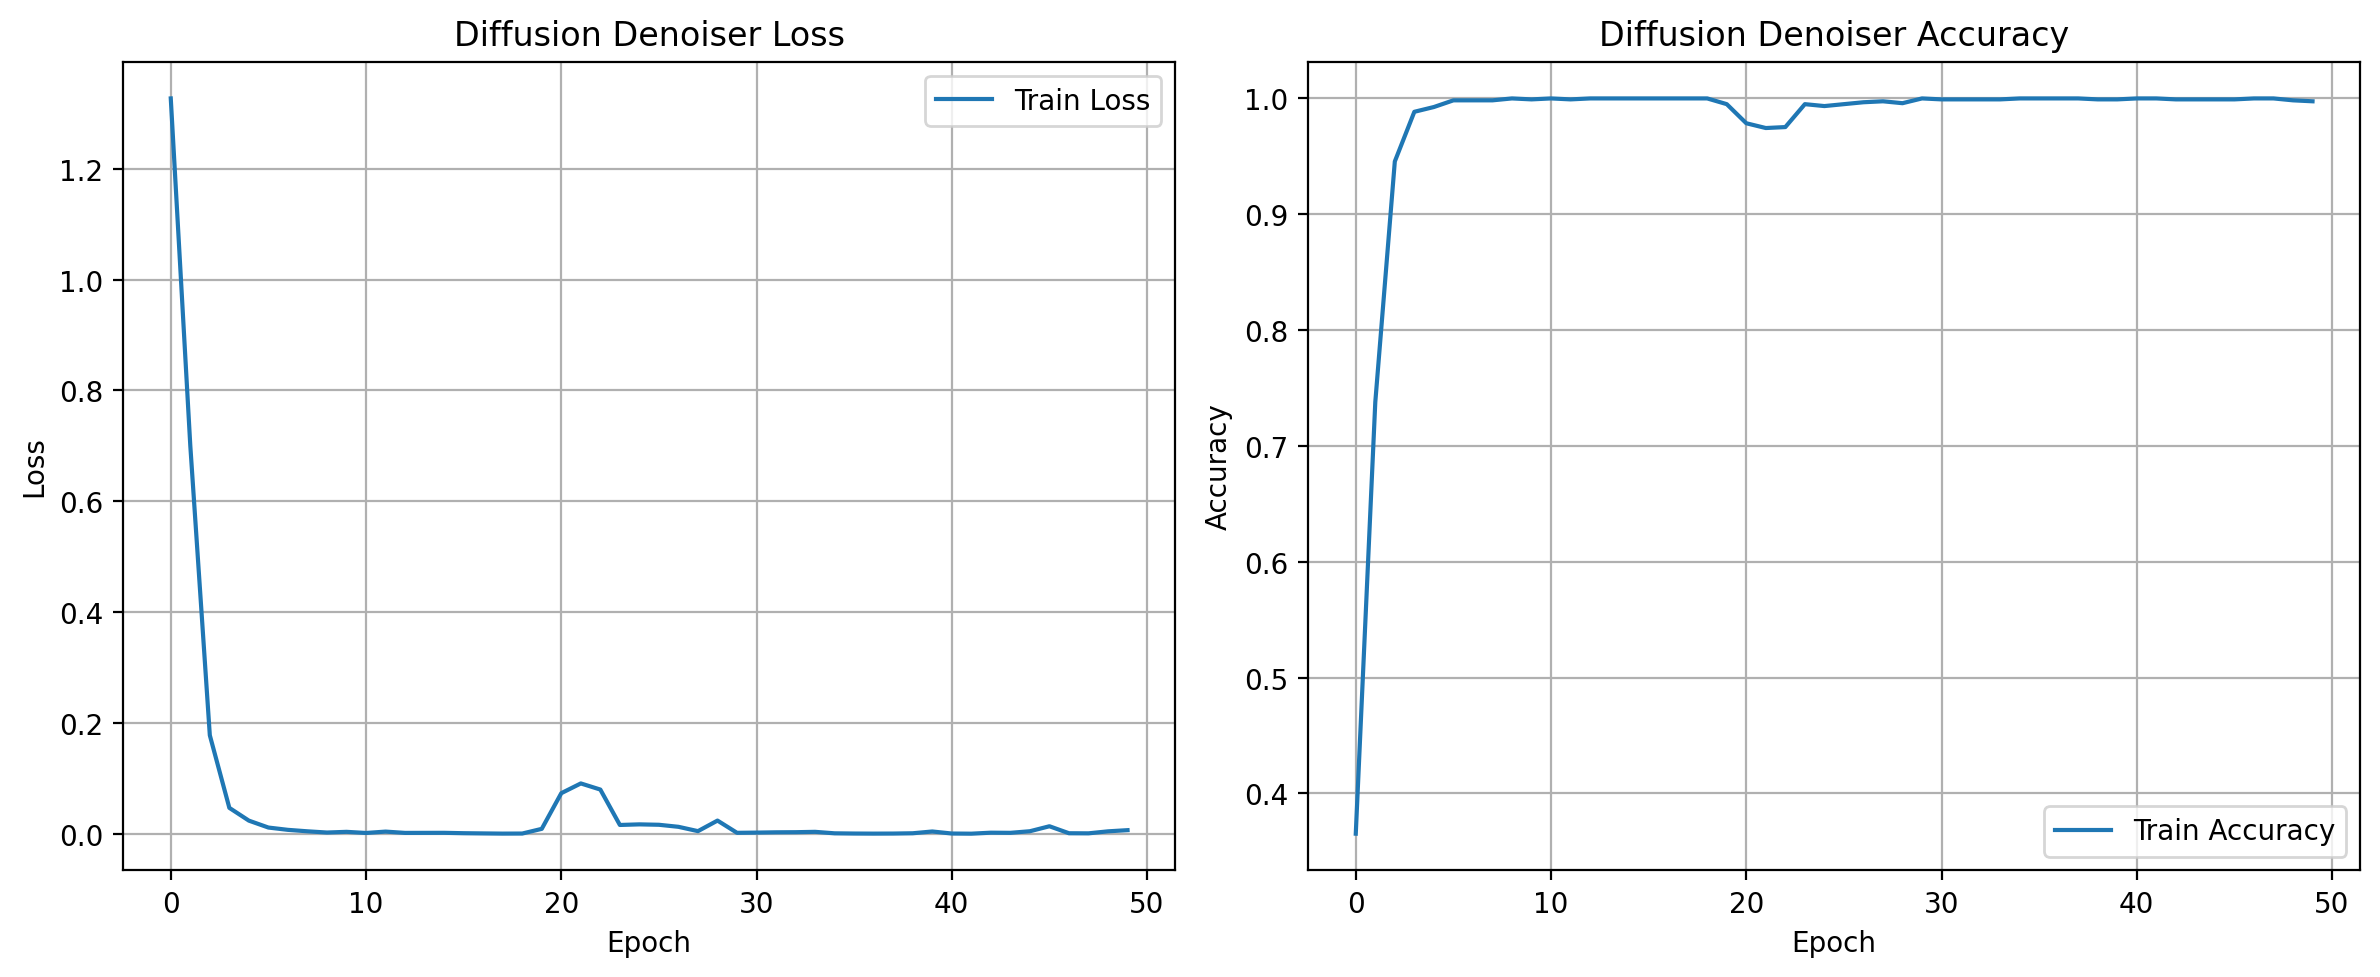

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


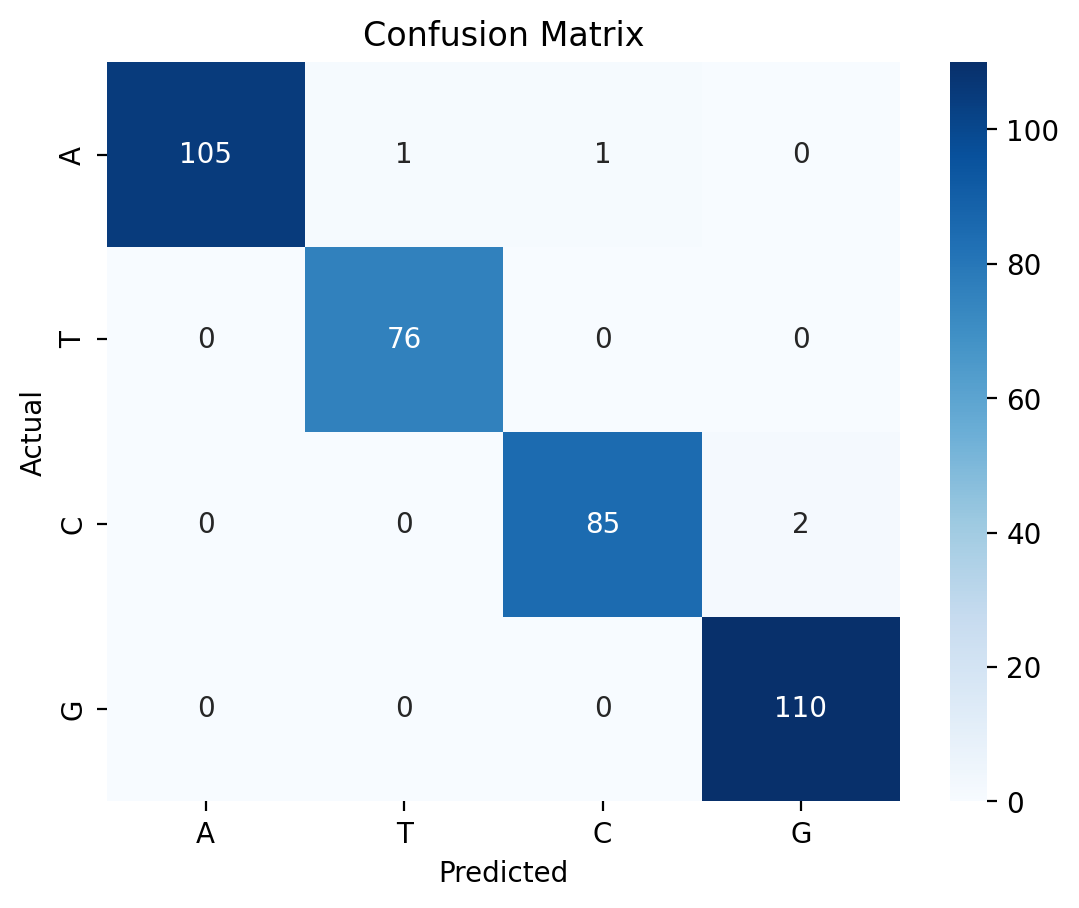


Classification Report:
               precision    recall  f1-score   support

           A       1.00      0.98      0.99       107
           T       0.99      1.00      0.99        76
           C       0.99      0.98      0.98        87
           G       0.98      1.00      0.99       110

    accuracy                           0.99       380
   macro avg       0.99      0.99      0.99       380
weighted avg       0.99      0.99      0.99       380

All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Main class
class DiffusionDNAMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64
        self.noise_steps = 5

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length + 1]
                    X.append(self.dna_to_numeric(chunk[:-1]))
                    y.append(self.dna_to_numeric(chunk[1]))  # predict next token
        X = np.array(X)
        y = to_categorical(y, num_classes=4)
        return X, y

    def add_noise(self, data, step):
        noise = np.random.normal(0, 0.1 * step, size=data.shape)
        return data + noise

    def build_model(self):
        dna_input = Input(shape=(self.sequence_length,))
        noisy_input = Input(shape=(self.sequence_length,))
        x1 = Embedding(input_dim=4, output_dim=self.embedding_dim)(dna_input)
        x1 = Flatten()(x1)
        x = Concatenate()([x1, noisy_input])
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(4, activation='softmax')(x)
        model = Model([dna_input, noisy_input], output, name="DiffusionDenoiser")
        return model

    def train(self, model, X_train, y_train, epochs=50):
        model.compile(optimizer=Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        losses, accuracies = [], []
        for epoch in range(epochs):
            step = np.random.randint(1, self.noise_steps + 1)
            noisy_X = self.add_noise(X_train.astype(np.float32), step)
            history = model.fit([X_train, noisy_X], y_train,
                                validation_split=0.2,
                                epochs=1,
                                batch_size=32,
                                verbose=1)
            losses.append(history.history['loss'][0])
            accuracies.append(history.history['accuracy'][0])
        return model, losses, accuracies

    def plot_training(self, losses, accuracies):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(losses, label='Train Loss')
        plt.title('Diffusion Denoiser Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(accuracies, label='Train Accuracy')
        plt.title('Diffusion Denoiser Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def evaluate(self, model, X_test, y_test):
        noisy_X = self.add_noise(X_test.astype(np.float32), step=3)
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict([X_test, noisy_X]), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

# ✅ Run the full pipeline
modeler = DiffusionDNAMusic()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']
sequences = modeler.load_fasta(fasta_files)

print("Preparing dataset...")
X, y = modeler.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Building diffusion denoiser model...")
model = modeler.build_model()

print("Training model...")
model, losses, accuracies = modeler.train(model, X_train, y_train)

print("Plotting training curves...")
modeler.plot_training(losses, accuracies)

print("Evaluating model...")
modeler.evaluate(model, X_test, y_test)

print("All tasks completed successfully!")

# New Section

In [ ]:
#LSTM MODEL

Saving sequence.fasta to sequence (43).fasta
Loading FASTA sequences...
Preparing dataset...
Building enhanced LSTM model...
Training model...
Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3189 - loss: 1.3628 - val_accuracy: 0.5000 - val_loss: 1.2256
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5384 - loss: 1.1466 - val_accuracy: 0.5559 - val_loss: 1.0773
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5614 - loss: 1.0528 - val_accuracy: 0.5493 - val_loss: 1.0299
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5963 - loss: 0.9767 - val_accuracy: 0.5724 - val_loss: 0.9800
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6320 - loss: 0.9221 - val_accuracy: 0.6217 - val_loss: 0.9018
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7329 - loss: 0.7981 - val_accuracy: 0.7895 - val_loss: 0.7260
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8370 - loss: 0.6644 - val_accu

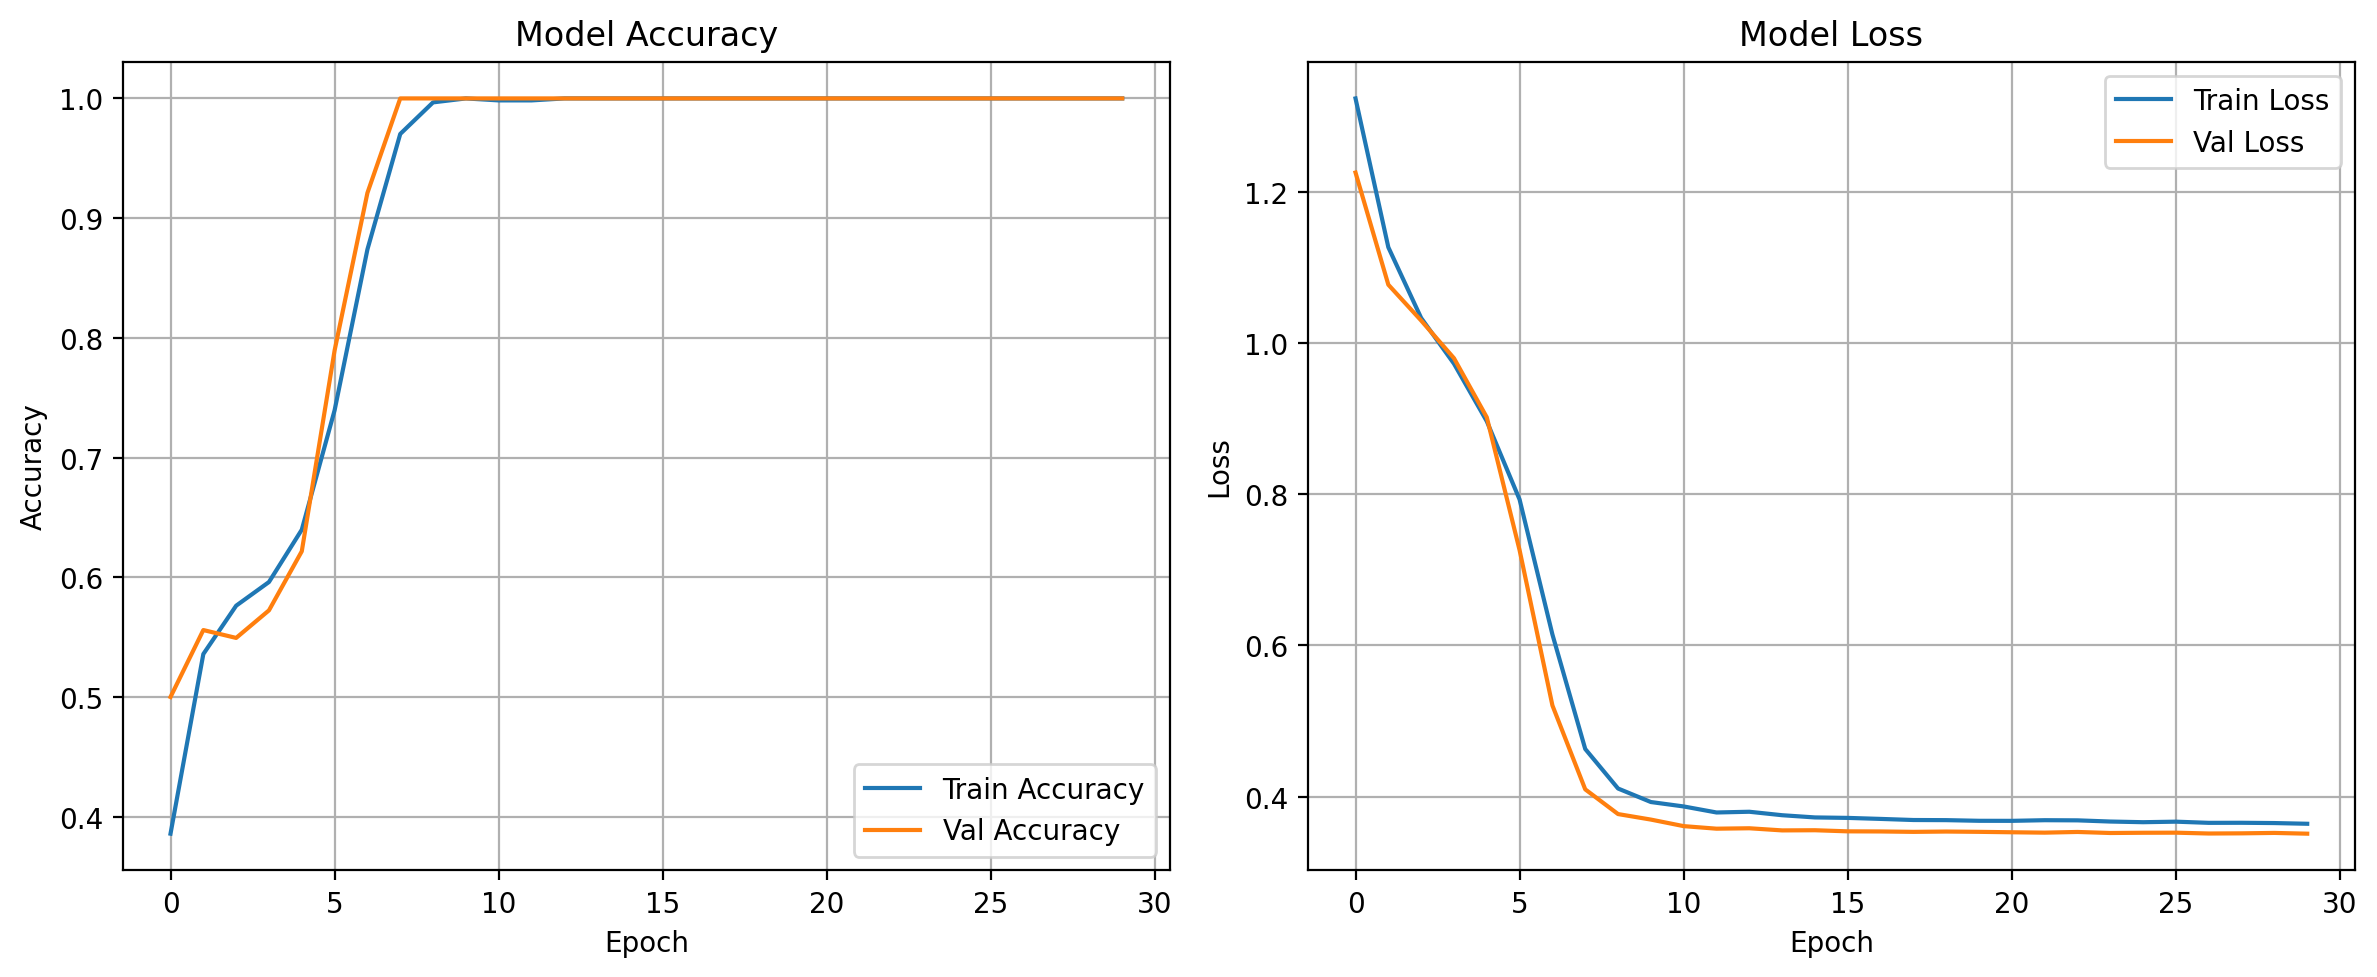

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


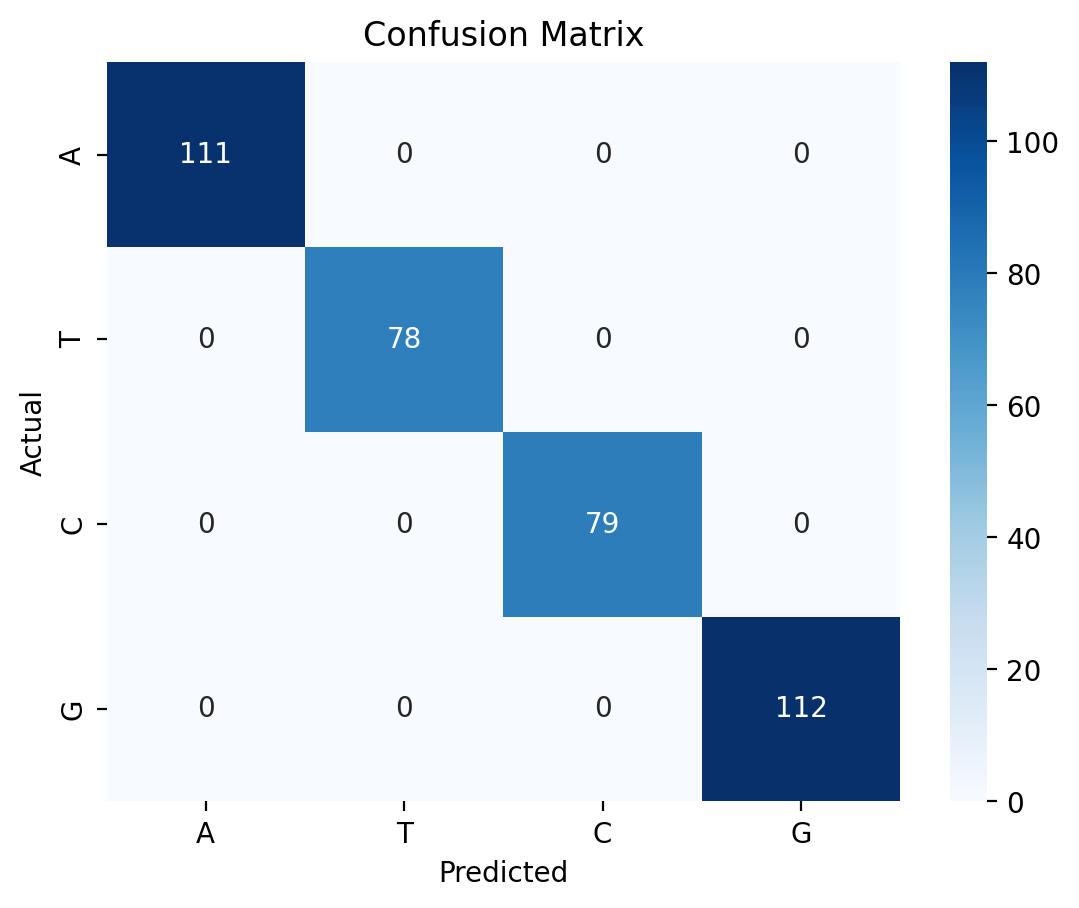


Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00       111
           T       1.00      1.00      1.00        78
           C       1.00      1.00      1.00        79
           G       1.00      1.00      1.00       112

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380

All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Main class
class LSTMDNAMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length + 1]
                    X.append(self.dna_to_numeric(chunk[:-1]))
                    y.append(self.dna_to_numeric(chunk[1]))  # predict next token
        X = np.array(X)
        y = to_categorical(y, num_classes=4)
        return X, y

    def build_model(self):
        inputs = Input(shape=(self.sequence_length,))
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Dropout(0.3)(x)
        x = Bidirectional(LSTM(64))(x)
        x = Dropout(0.3)(x)
        outputs = Dense(4, activation='softmax')(x)
        model = Model(inputs, outputs, name="Enhanced_LSTM_DNA_Music")
        return model

    def train(self, model, X_train, y_train, X_val, y_val, epochs=30):
        model.compile(optimizer=Adam(0.001),
                      loss=CategoricalCrossentropy(label_smoothing=0.1),
                      metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            callbacks=[early_stop],
                            verbose=1)
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

# ✅ Run the full pipeline
modeler = LSTMDNAMusic()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']
sequences = modeler.load_fasta(fasta_files)

print("Preparing dataset...")
X, y = modeler.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Building enhanced LSTM model...")
model = modeler.build_model()

print("Training model...")
model, history = modeler.train(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
modeler.plot_training(history)

print("Evaluating model...")
modeler.evaluate(model, X_test, y_test)

print("All tasks completed successfully!")

# New Section

In [ ]:
#TRANSFORMER DECODER(GPT-STYLE) MODEL

Saving sequence.fasta to sequence (53).fasta
Loading FASTA sequences...
Preparing dataset...
Building GPT-style model...
Training model...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2501 - loss: 2.0328 - val_accuracy: 0.2558 - val_loss: 1.3911 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2530 - loss: 1.4116 - val_accuracy: 0.2616 - val_loss: 1.3894 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2539 - loss: 1.4033 - val_accuracy: 0.2654 - val_loss: 1.3857 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2568 - loss: 1.3957 - val_accuracy: 0.2798 - val_loss: 1.3826 - learning_rate: 0.0010
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2750 - loss: 1.3845 - val_accuracy: 0.3029 - val_loss: 1.3663 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2922 - loss: 1.3706 - val_accuracy: 

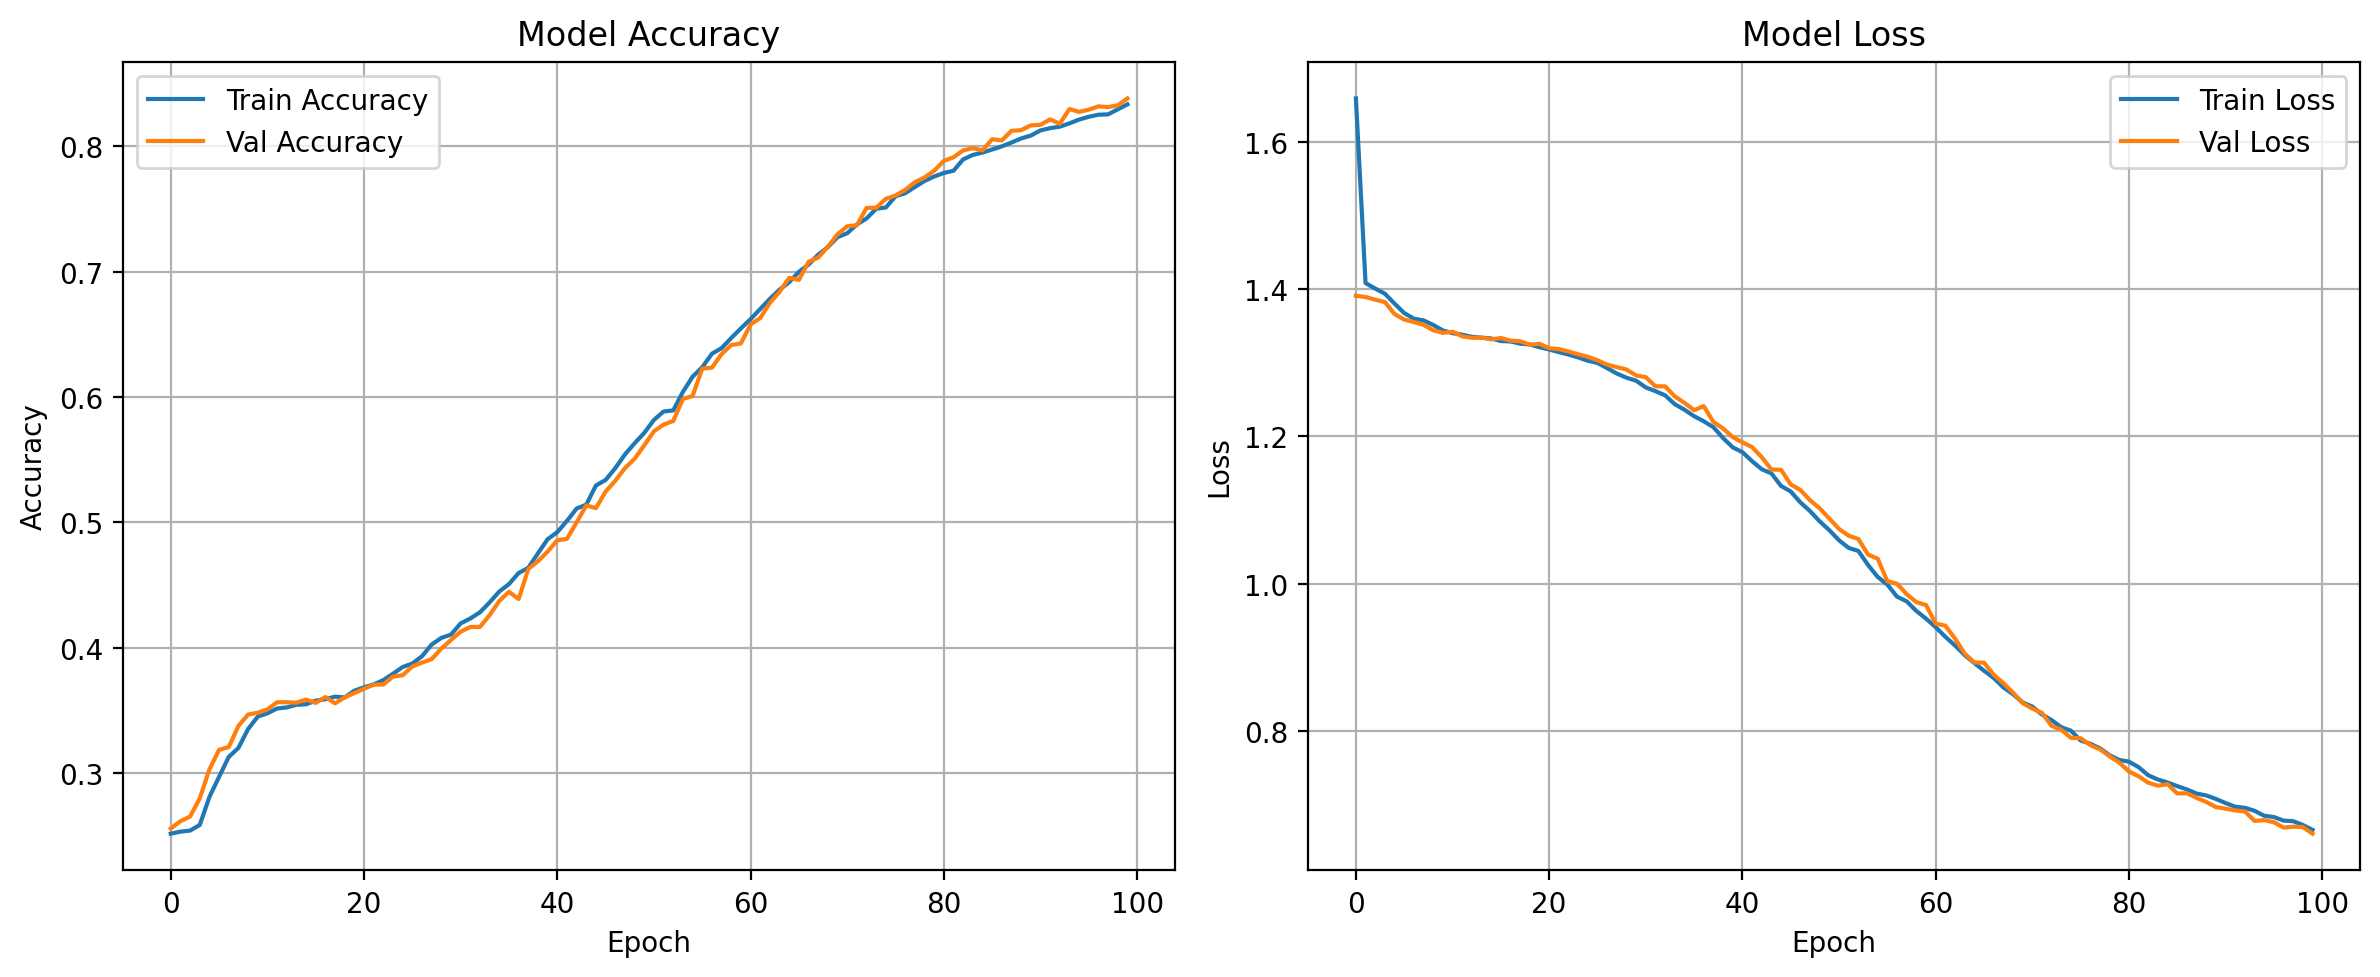

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 621ms/step


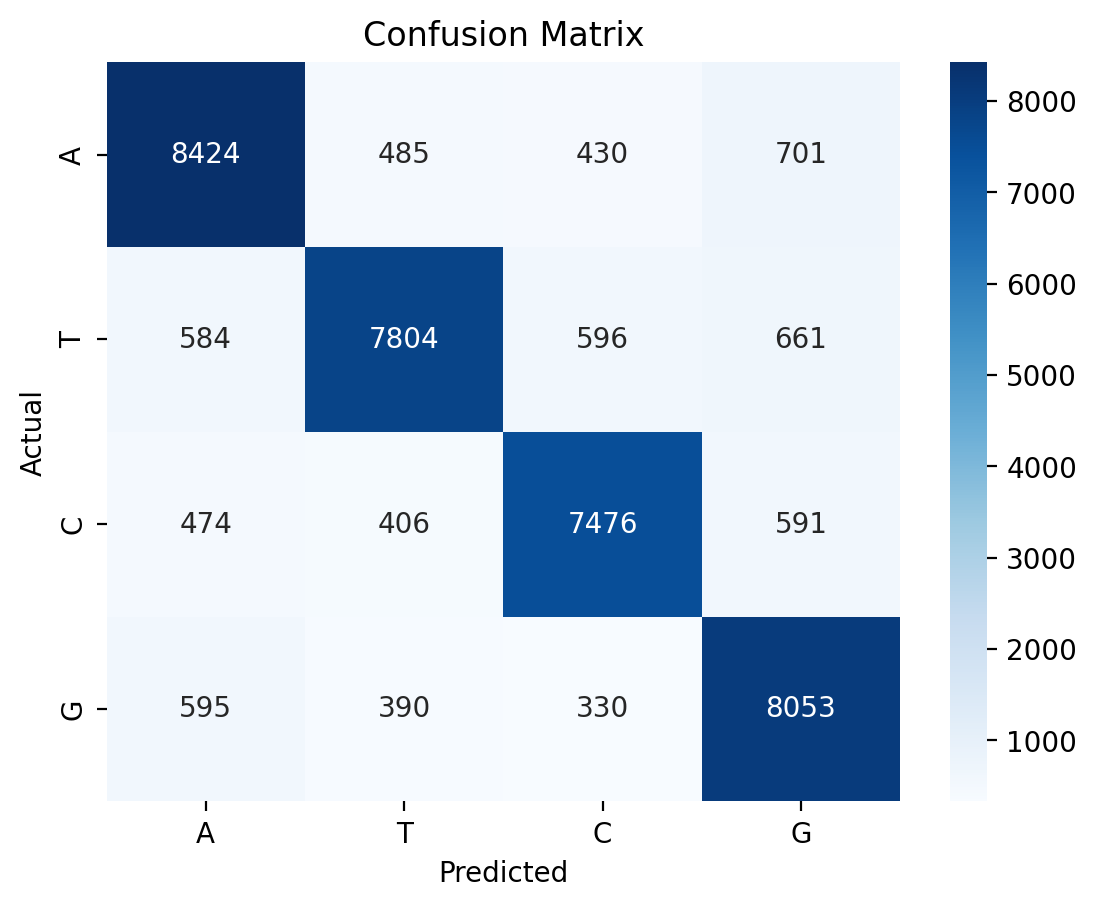


Classification Report:
               precision    recall  f1-score   support

           A       0.84      0.84      0.84     10040
           T       0.86      0.81      0.83      9645
           C       0.85      0.84      0.84      8947
           G       0.80      0.86      0.83      9368

    accuracy                           0.84     38000
   macro avg       0.84      0.84      0.84     38000
weighted avg       0.84      0.84      0.84     38000

All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Embedding, LayerNormalization,
                                     MultiHeadAttention, Add, TimeDistributed)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Positional Encoding
def positional_encoding(length, depth):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(depth)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(depth))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# ✅ Causal Mask
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    mask = tf.cast(i >= j, dtype)
    return tf.reshape(mask, [1, n_dest, n_src])

# ✅ Transformer Decoder Block
class GPTBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        attn_mask = causal_attention_mask(tf.shape(inputs)[0],
                                          tf.shape(inputs)[1],
                                          tf.shape(inputs)[1],
                                          tf.float32)
        attn_output = self.att(inputs, inputs, attention_mask=attn_mask)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output))

# ✅ Main class
class GPTDNA:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length + 1]
                    X.append(self.dna_to_numeric(chunk[:-1]))
                    y.append(self.dna_to_numeric(chunk[1:]))  # next-token sequence
        X = np.array(X)
        y = np.array(y)
        y = to_categorical(y, num_classes=4)
        return X, y

    def build_model(self):
        inputs = Input(shape=(self.sequence_length,))
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)
        pos_encoding = positional_encoding(self.sequence_length, self.embedding_dim)
        x = Add()([x, pos_encoding])

        for _ in range(4):  # deeper decoder
            x = GPTBlock(self.embedding_dim, num_heads=8, ff_dim=256)(x)

        outputs = TimeDistributed(Dense(4, activation='softmax'))(x)
        model = Model(inputs, outputs, name="GPTDNA")
        return model

    def train(self, model, X_train, y_train, X_val, y_val, epochs=100):
        model.compile(optimizer=Adam(0.001),
                      loss=CategoricalCrossentropy(label_smoothing=0.1),
                      metrics=['accuracy'])
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ]
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1,
                            callbacks=callbacks)
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=-1).flatten()
        y_pred = np.argmax(model.predict(X_test), axis=-1).flatten()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

# ✅ Run the full pipeline
modeler = GPTDNA()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']
sequences = modeler.load_fasta(fasta_files)

print("Preparing dataset...")
X, y = modeler.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Building GPT-style model...")
model = modeler.build_model()

print("Training model...")
model, history = modeler.train(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
modeler.plot_training(history)

print("Evaluating model...")
modeler.evaluate(model, X_test, y_test)

print("All tasks completed successfully!")

# New Section

In [ ]:
#encoder-only-transformer model

Saving sequence.fasta to sequence (58).fasta
Loading FASTA sequences...
Preparing dataset...
Building Transformer model...
Training model...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2522 - loss: 1.7444 - val_accuracy: 0.2719 - val_loss: 1.3822 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2602 - loss: 1.4285 - val_accuracy: 0.2980 - val_loss: 1.3786 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2692 - loss: 1.3943 - val_accuracy: 0.3012 - val_loss: 1.3680 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2935 - loss: 1.3746 - val_accuracy: 0.3397 - val_loss: 1.3555 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3249 - loss: 1.3587 - val_accuracy: 0.3819 - val_loss: 1.3160 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3990 - loss: 1.3064 - val_accuracy: 0.47

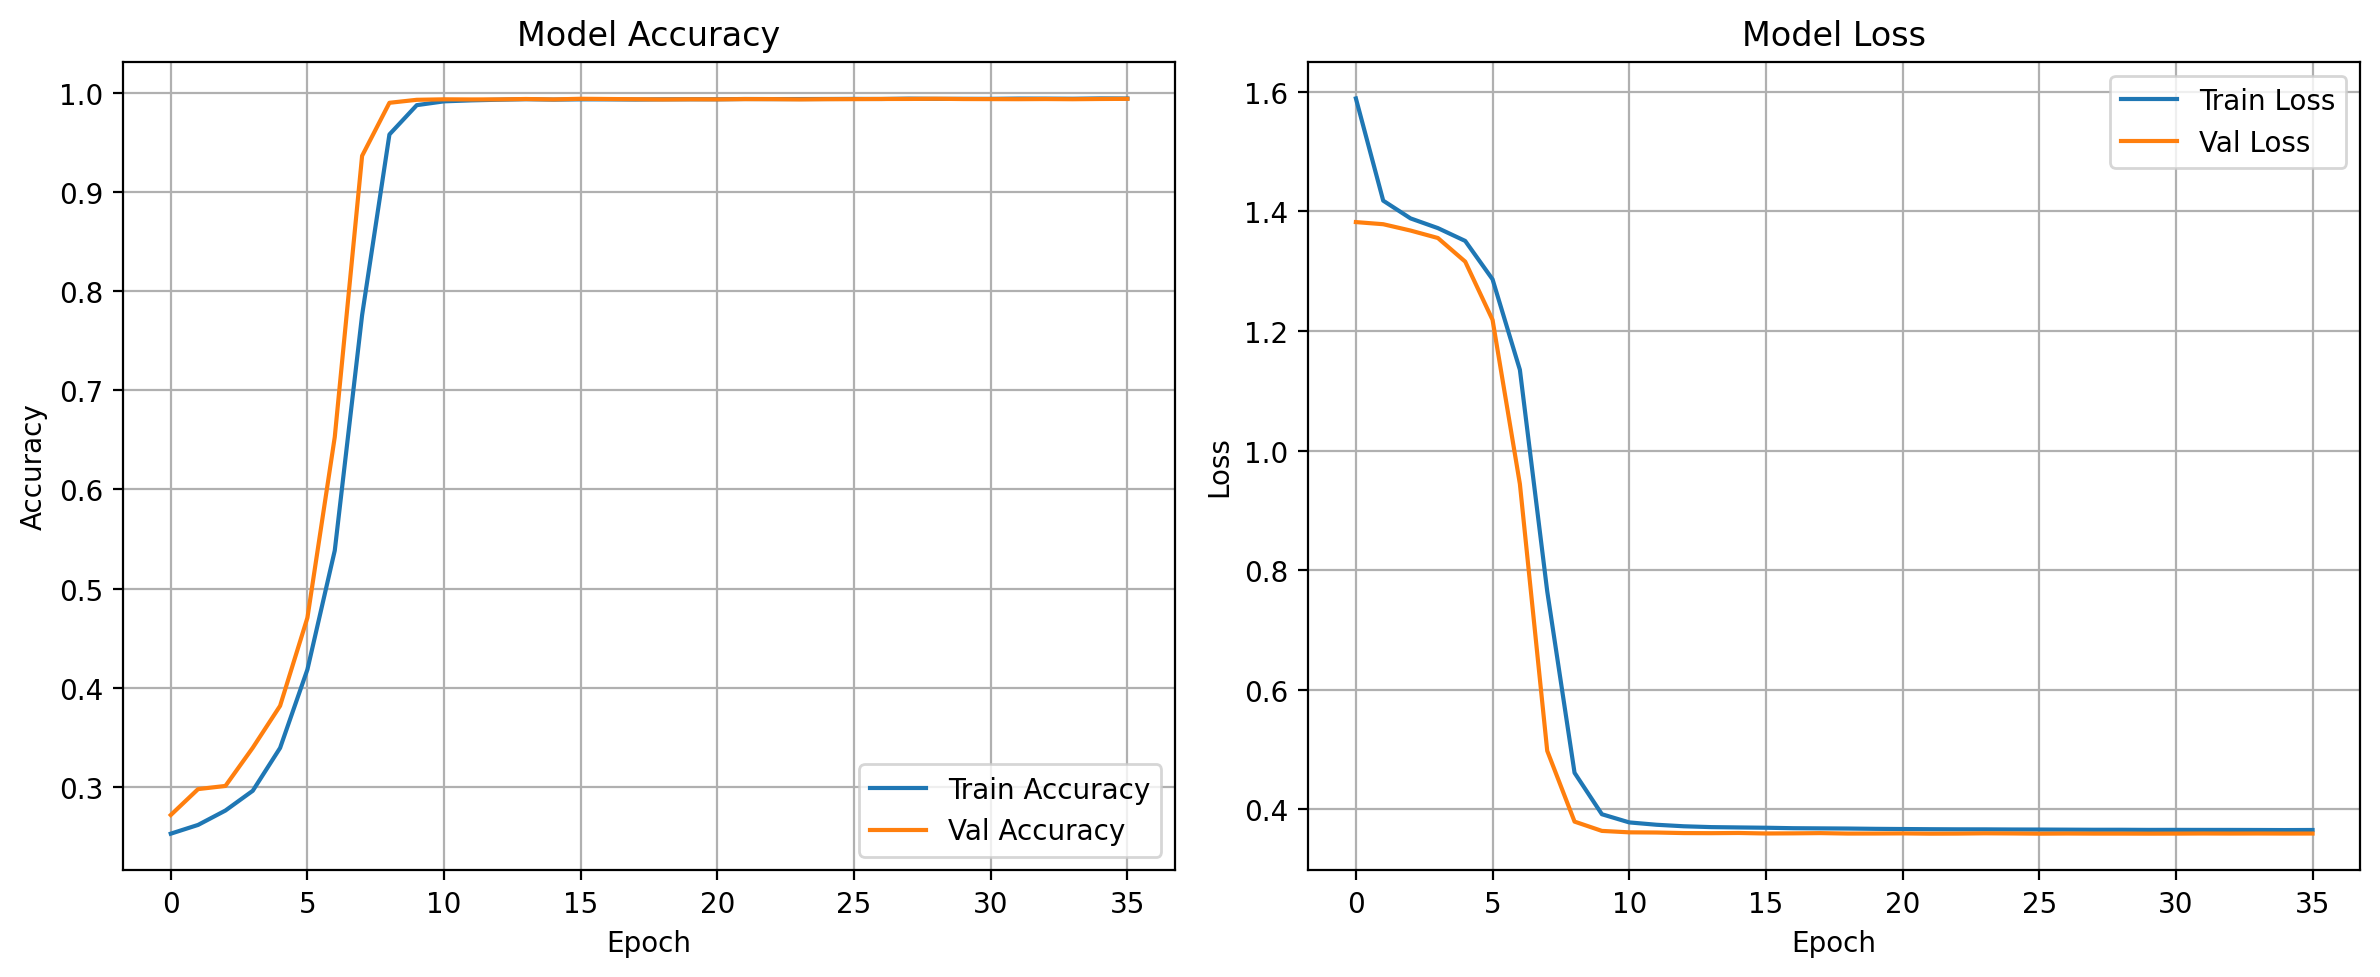

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 682ms/step


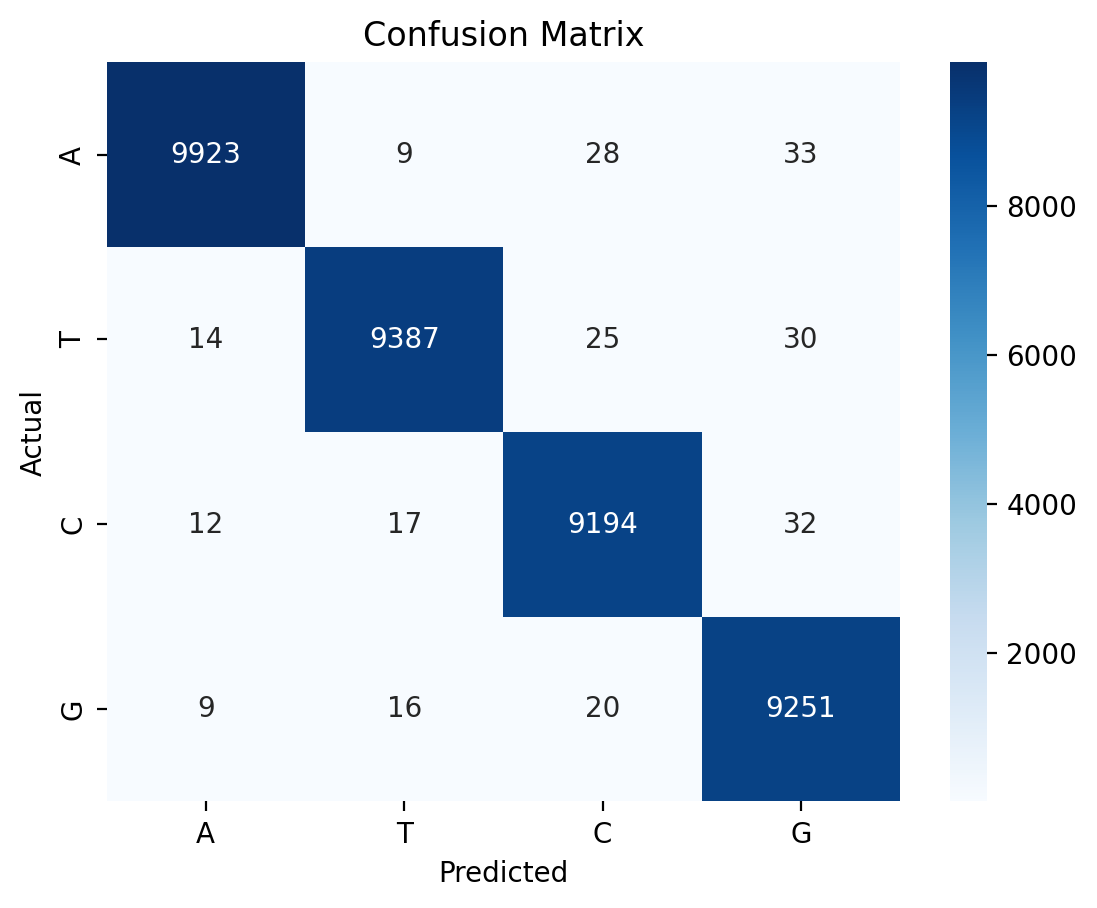


Classification Report:
               precision    recall  f1-score   support

           A       1.00      0.99      0.99      9993
           T       1.00      0.99      0.99      9456
           C       0.99      0.99      0.99      9255
           G       0.99      1.00      0.99      9296

    accuracy                           0.99     38000
   macro avg       0.99      0.99      0.99     38000
weighted avg       0.99      0.99      0.99     38000

All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LayerNormalization, GlobalAveragePooling1D, Add, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Positional Encoding
def positional_encoding(length, depth):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(depth)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(depth))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# ✅ Transformer Encoder Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output))

# ✅ Main class
class TransformerDNAMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length + 1]
                    X.append(self.dna_to_numeric(chunk[:-1]))
                    y.append(self.dna_to_numeric(chunk[1:]))  # full next-token sequence
        X = np.array(X)
        y = np.array(y)
        y = to_categorical(y, num_classes=4)
        return X, y

    def build_model(self):
        inputs = Input(shape=(self.sequence_length,))
        x = Embedding(input_dim=4, output_dim=self.embedding_dim)(inputs)
        pos_encoding = positional_encoding(self.sequence_length, self.embedding_dim)
        x = Add()([x, pos_encoding])

        for _ in range(3):  # deeper encoder
            x = TransformerBlock(self.embedding_dim, num_heads=4, ff_dim=128)(x)

        x = Dropout(0.3)(x)
        outputs = TimeDistributed(Dense(4, activation='softmax'))(x)
        model = Model(inputs, outputs, name="TransformerDNA")
        return model

    def train(self, model, X_train, y_train, X_val, y_val, epochs=50):
        model.compile(optimizer=Adam(0.001),
                      loss=CategoricalCrossentropy(label_smoothing=0.1),
                      metrics=['accuracy'])
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ]
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1,
                            callbacks=callbacks)
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=-1).flatten()
        y_pred = np.argmax(model.predict(X_test), axis=-1).flatten()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

# ✅ Run the full pipeline
modeler = TransformerDNAMusic()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']
sequences = modeler.load_fasta(fasta_files)

print("Preparing dataset...")
X, y = modeler.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Building Transformer model...")
model = modeler.build_model()

print("Training model...")
model, history = modeler.train(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
modeler.plot_training(history)

print("Evaluating model...")
modeler.evaluate(model, X_test, y_test)

print("All tasks completed successfully!")

# New Section

In [ ]:
#T5(encoder-decoder)

Saving sequence.fasta to sequence.fasta
Loading FASTA sequences...
Preparing dataset...
Building T5-style model...
Training model...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 719ms/step - accuracy: 0.2497 - loss: 1.7017 - val_accuracy: 0.2486 - val_loss: 1.3880 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 721ms/step - accuracy: 0.2566 - loss: 1.4080 - val_accuracy: 0.2923 - val_loss: 1.3787 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 718ms/step - accuracy: 0.2878 - loss: 1.3838 - val_accuracy: 0.3288 - val_loss: 1.3515 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 822ms/step - accuracy: 0.3296 - loss: 1.3552 - val_accuracy: 0.3653 - val_loss: 1.3306 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 878ms/step - accuracy: 0.3651 - loss: 1.3310 - val_accuracy: 0.4021 - val_loss: 1.2947 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 821ms/step - accuracy: 0.4284 - loss: 1.2657 - val_accuracy:

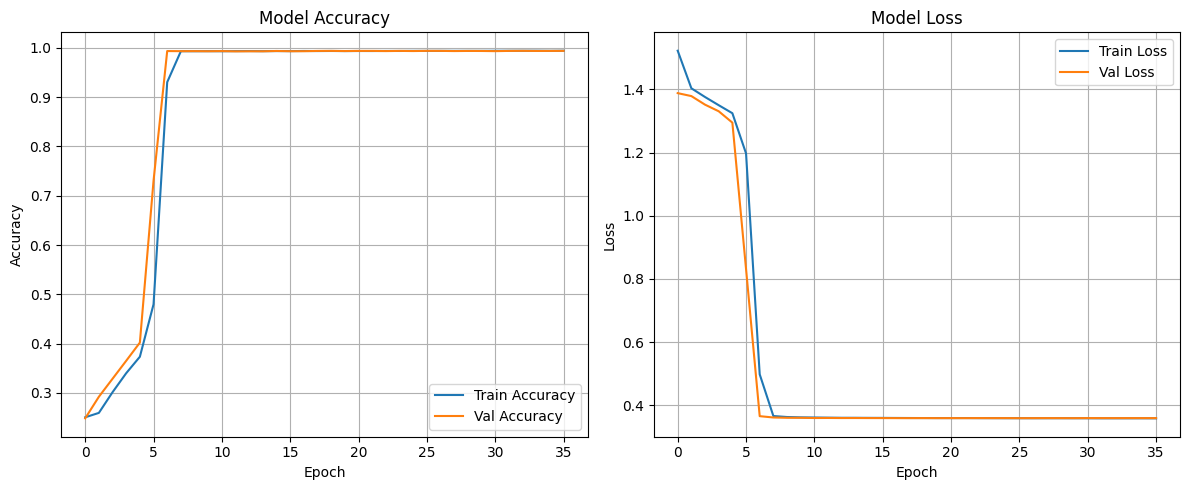

Evaluating model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step


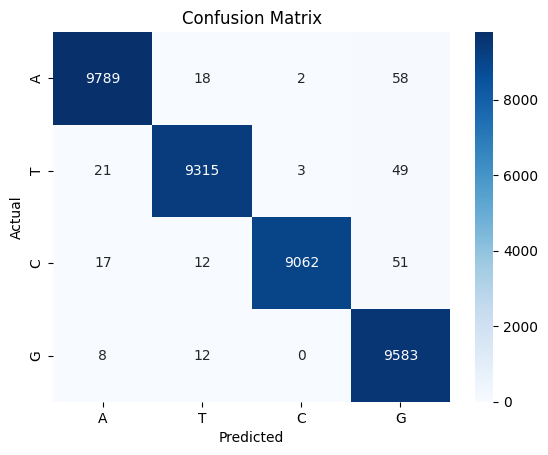


Classification Report:
               precision    recall  f1-score   support

           A       1.00      0.99      0.99      9867
           T       1.00      0.99      0.99      9388
           C       1.00      0.99      1.00      9142
           G       0.98      1.00      0.99      9603

    accuracy                           0.99     38000
   macro avg       0.99      0.99      0.99     38000
weighted avg       0.99      0.99      0.99     38000

All tasks completed successfully!


In [ ]:
# ✅ Install Biopython if needed
!pip install biopython

# ✅ Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# ✅ Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LayerNormalization, Add
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import warnings
warnings.filterwarnings('ignore')

# ✅ Positional Encoding
def positional_encoding(length, depth):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(depth)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(depth))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# ✅ Encoder Block
def encoder_block(embed_dim, num_heads, ff_dim, rate=0.1):
    def block(x):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + Dropout(rate)(attn_output))
        ffn_output = Dense(ff_dim, activation='relu')(x)
        ffn_output = Dense(embed_dim)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + Dropout(rate)(ffn_output))
        return x
    return block

# ✅ Decoder Block
def decoder_block(embed_dim, num_heads, ff_dim, rate=0.1):
    def block(x, enc_output):
        attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + Dropout(rate)(attn1))
        attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, enc_output)
        x = LayerNormalization(epsilon=1e-6)(x + Dropout(rate)(attn2))
        ffn_output = Dense(ff_dim, activation='relu')(x)
        ffn_output = Dense(embed_dim)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + Dropout(rate)(ffn_output))
        return x
    return block

# ✅ Main class
class T5DNAMusic:
    def __init__(self):
        self.nucleotides = ['A', 'T', 'C', 'G']
        self.sequence_length = 100
        self.embedding_dim = 64

    def load_fasta(self, file_paths):
        sequences = []
        for file_path in file_paths:
            for record in SeqIO.parse(file_path, "fasta"):
                seq = str(record.seq).upper()
                if all(n in self.nucleotides for n in seq):
                    sequences.append(seq)
        return sequences

    def dna_to_numeric(self, sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return [mapping[n] for n in sequence]

    def prepare_dataset(self, sequences):
        X, y = [], []
        for seq in sequences:
            if len(seq) >= self.sequence_length + 1:
                for i in range(0, len(seq) - self.sequence_length - 1, 10):
                    chunk = seq[i:i + self.sequence_length + 1]
                    X.append(self.dna_to_numeric(chunk[:-1]))
                    y.append(self.dna_to_numeric(chunk[1:]))  # full next-token sequence
        X = np.array(X)
        y = np.array(y)
        y = to_categorical(y, num_classes=4)
        return X, y

    def build_model(self):
        encoder_inputs = Input(shape=(self.sequence_length,))
        decoder_inputs = Input(shape=(self.sequence_length,))

        enc_embed = Embedding(input_dim=4, output_dim=self.embedding_dim)(encoder_inputs)
        dec_embed = Embedding(input_dim=4, output_dim=self.embedding_dim)(decoder_inputs)

        pos_enc = positional_encoding(self.sequence_length, self.embedding_dim)
        enc_embed = Add()([enc_embed, pos_enc])
        dec_embed = Add()([dec_embed, pos_enc])

        for _ in range(3):
            enc_embed = encoder_block(self.embedding_dim, num_heads=4, ff_dim=128)(enc_embed)
            dec_embed = decoder_block(self.embedding_dim, num_heads=4, ff_dim=128)(dec_embed, enc_embed)

        outputs = Dense(4, activation='softmax')(dec_embed)
        model = Model([encoder_inputs, decoder_inputs], outputs, name="T5DNA")
        return model

    def train(self, model, X_train, y_train, X_val, y_val, epochs=50):
        model.compile(optimizer=Adam(0.001),
                      loss=CategoricalCrossentropy(label_smoothing=0.1),
                      metrics=['accuracy'])
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        ]
        history = model.fit([X_train, X_train], y_train,
                            validation_data=([X_val, X_val], y_val),
                            epochs=epochs,
                            batch_size=32,
                            verbose=1,
                            callbacks=callbacks)
        return model, history

    def plot_training(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate(self, model, X_test, y_test):
        y_true = np.argmax(y_test, axis=-1).flatten()
        y_pred = np.argmax(model.predict([X_test, X_test]), axis=-1).flatten()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.nucleotides,
                    yticklabels=self.nucleotides)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        report = classification_report(y_true, y_pred, target_names=self.nucleotides)
        print("\nClassification Report:\n", report)

# ✅ Run the full pipeline
modeler = T5DNAMusic()

print("Loading FASTA sequences...")
fasta_files = ['sequence.fasta']
sequences = modeler.load_fasta(fasta_files)

print("Preparing dataset...")
X, y = modeler.prepare_dataset(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Building T5-style model...")
model = modeler.build_model()

print("Training model...")
model, history = modeler.train(model, X_train, y_train, X_val, y_val)

print("Plotting training curves...")
modeler.plot_training(history)

print("Evaluating model...")
modeler.evaluate(model, X_test, y_test)

print("All tasks completed successfully!")